In [ ]:
# Loading some libraries

In [1]:
%%capture --no-display
! pip install scipy
! pip install matplotlib 
! pip install seaborn
! pip install plotly

In [2]:
%load_ext autoreload

import json
import numpy as np
import pandas as pd
from src.pyipums.parse_xml import read_ipums_ddi
from src.pyipums.clean_data import IpumsCleaner
from ipumspy import readers, ddi
from matplotlib import pyplot as plt
import plotly
import plotly.io as pio

import seaborn as sns
import matplotlib as mpl
from IPython.core.display import display

plt.rcParams["figure.figsize"]=12,8  # Set figure size for the notebook
sns.set(style="whitegrid")           # set seaborn whitegrid theme

plotly.offline.init_notebook_mode(connected=True)

# pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab'
# pio.renderers.default = 'jupyterlab'
# This is the one that works
pio.renderers.default = 'iframe'

KeyboardInterrupt: 

In [ ]:
def cdf_plot_by_x(
    xdf,
    groupbyvar,
    xvar,
    wvar,
    k=None,
    bbox=(0.5, -0.1),
    legend_ncol=3,
    max_percentile=1.,
):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    if k is not None:
        sdf = xdf[groupbyvar].value_counts()
        top_k = sdf[0:(k-1)].index.tolist()
        xdfss = xdf[xdf.eval(f'{groupbyvar} == "' + f'" | {groupbyvar} == "'.join(top_k) + '"')].reset_index(drop=True)
        print(f'reducing records from {xdf.shape[0]} to {xdfss.shape[0]}')
        print(f"reducing groups from {xdf[groupbyvar].nunique()} to {k}")
    else:
        xdfss = xdf
    
    max_percentile_value = xdfss[xvar].quantile(max_percentile)
    xdfss = xdfss[xdfss[xvar] < max_percentile_value]
    groups = xdfss[groupbyvar].unique()
    pal = sns.color_palette("bright", len(groups))
    sns.ecdfplot(
        data=xdfss,
        weights=wvar, 
        x=xvar, 
        hue=groupbyvar, 
        alpha=0.8, 
        ax=ax,
        palette=pal,
    ).set(title=f'Cumulative Distribution of Total Income by {groupbyvar}')
    label = ddi_codebook.get_variable_info(xvar.replace("_2", "")).label.title().replace("'S", "'s")
    ax.set_xlabel(f"{label}")
    ax.set_ylabel(f"Cumulative Percent of ASEC Data")
    ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))
    ax.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
    ax.get_legend().set_visible(False)
    fig.legend(labels=groups, loc='lower center', bbox_to_anchor=bbox, ncol=legend_ncol)
    fig.show()
    
def den_cdf_plot_by_x(
    xdf,
    groupbyvar,
    xvar,
    wvar,
    k=None,
    bbox=(0.5, -0.1),
    legend_ncol=3,
    max_percentile=1.,
    den_title=None,
):
    fig, (ax1, ax) = plt.subplots(1, 2, figsize=(16, 8))
    if k is not None:
        sdf = xdf[groupbyvar].value_counts()
        top_k = sdf[0:(k-1)].index.tolist()
        xdfss = xdf[xdf.eval(f'{groupbyvar} == "' + f'" | {groupbyvar} == "'.join(top_k) + '"')].reset_index(drop=True)
        print(f'reducing records from {xdf.shape[0]} to {xdfss.shape[0]}')
        print(f"reducing groups from {xdf[groupbyvar].nunique()} to {k}")
    else:
        xdfss = xdf
    
    if den_title is None:
        den_title = f'Estimated Density Function of Total Income by {groupbyvar}'
    max_percentile_value = xdfss[xvar].quantile(max_percentile)
    xdfss = xdfss[xdfss[xvar] < max_percentile_value]
    groups = xdfss[groupbyvar].unique()
    pal = sns.color_palette("bright", len(groups))

    sns.kdeplot(
        data=xdfss,
        weights=wvar, 
        x=xvar, 
        hue=groupbyvar, 
        cut=0, fill=True, 
        common_norm=False, 
        alpha=0.2, 
        ax=ax1,
        palette=pal,
    ).set(title=den_title)
    try:
        label = ddi_codebook.get_variable_info(xvar.replace("_2", "")).label.title().replace("'S", "'s")
    except:
        label = xvar
    ax1.set_xlabel(f"{label}")
    ax1.set_ylabel(f"Percent of ASEC Data")
    ax1.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))
    ax1.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
    ax1.get_legend().set_visible(False)

    sns.ecdfplot(
        data=xdfss,
        weights=wvar, 
        x=xvar, 
        hue=groupbyvar, 
        alpha=0.8, 
        ax=ax,
        palette=pal,
    ).set(title=f'Cumulative Distribution of Total Income by {groupbyvar}')
    label = ddi_codebook.get_variable_info(xvar.replace("_2", "")).label.title().replace("'S", "'s")
    ax.set_xlabel(f"{label}")
    ax.set_ylabel(f"Cumulative Percent of ASEC Data")
    ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.3f}'))
    ax.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
    ax.get_legend().set_visible(False)
    fig.legend(labels=groups, loc='lower center', bbox_to_anchor=bbox, ncol=legend_ncol)
    fig.show()
    
def denbyplot(df, colname, byvar, weightvar):
    f, ax = plt.subplots(1, figsize=(12, 8))
    groups = df[byvar].unique()
    labels = []
    for i, g in enumerate(groups):
        f = (df[colname].isnull()==False) & (df[byvar]==g)    
        ax = df[f][f"{colname}_2"].plot(weight=df[f][weightvar], kind='density', grid=True)
        ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
    #     ax.set_xlim([0, 1e6])
        label = ddi_codebook.get_variable_info(colname.replace("_2", "")).label.title().replace("'S", "'s")
        labels.append(label)
        ax.set_xlabel(f"{label}")

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.set_ylabel(f"Percentage of ASEC Data")
    ax.legend(labels, 
              loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=2)
    plt.show()
    
def den_plot_by_x(
    xdf,
    groupbyvar,
    xvar,
    wvar,
    k=None,
    bbox=(0.5, -0.1),
    legend_ncol=3,
    max_percentile=1.,
    addvline=False,
    den_title=None,
):
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))
    if k is not None:
        sdf = xdf[groupbyvar].value_counts()
        top_k = sdf[0:(k-1)].index.tolist()
        xdfss = xdf[xdf.eval(f'{groupbyvar} == "' + f'" | {groupbyvar} == "'.join(top_k) + '"')].reset_index(drop=True)
        print(f'reducing records from {xdf.shape[0]} to {xdfss.shape[0]}')
        print(f"reducing groups from {xdf[groupbyvar].nunique()} to {k}")
    else:
        xdfss = xdf
    
    if den_title is None:
        den_title = f'Estimated Density Function of Total Income by {groupbyvar}'
    max_percentile_value = xdfss[xvar].quantile(max_percentile)
    xdfss = xdfss[xdfss[xvar] < max_percentile_value]
    groups = xdfss[groupbyvar].unique()
    pal = sns.color_palette("bright", len(groups))

    sns.kdeplot(
        data=xdfss,
        weights=wvar, 
        x=xvar, 
        hue=groupbyvar, 
        cut=0, fill=True, 
        common_norm=False, 
        alpha=0.2, 
        ax=ax1,
        palette=pal,
    ).set(title=den_title)
    try:
        label = ddi_codebook.get_variable_info(xvar.replace("_2", "")).label.title().replace("'S", "'s")
    except:
        label = xvar
    
    ax1.set_xlabel(f"{label}")
    ax1.set_ylabel(f"Percent of ASEC Data")
    ax1.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.2f}'))
    ax1.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
    ax1.get_legend().set_visible(False)
    fig.legend(labels=groups, loc='lower center', bbox_to_anchor=bbox, ncol=legend_ncol)
    if addvline:
        tmp = xdfss[[xvar, groupbyvar, wvar]]
        tmp['XWEIGHT'] = xdfss[xvar] * xdfss[wvar]
        x = tmp[
            [groupbyvar, 'XWEIGHT', wvar]
        ].groupby(by=groupbyvar).agg({
            'XWEIGHT': [len, np.sum, np.mean], 
            wvar: [np.sum]
        }, as_index=False)

        x.columns = ['_'.join([y for y in j if y != '']) for j in x.columns]
        x['final'] = x['XWEIGHT_sum'] / x[f'{wvar}_sum']
        display(x[['final']].sort_values(by='final', ascending=False))
        for i, xval in enumerate(x['final']):
            ax1.axvline(x = xval,
               ymin = 0, color=pal[i],
               ymax = 1, linestyle='--')
    
    fig.show()

In [ ]:
ddi_file_path = "./cps_00003.xml"
data_file_path = "./cps_00003.dat.gz"

In [ ]:
cps_ddi = read_ipums_ddi(ddi_file_path)
ddi_codebook = readers.read_ipums_ddi(ddi_file_path)

In [ ]:
print(ddi_codebook.ipums_citation)

In [ ]:
xvars = [
    'AGE', 
    'ADJGINC', 
    'ASECWT', 
    'ASECWTH', 
    'ASIAN', 
    'ASECFWT', 
    'STATEFIP', 
    'TAXINC', 
    'UHRSWORK1', 
    'RACE', 
    'SEX', 
    'SRCWELFR', 
    'YEAR',
    'FOODSTAMP', 
    'STAMPVAL', 
    'WTFINL', 
    'BPL', 
    'HISPAN', 
    'EMPSTAT', 
    'LABFORCE', 
    'OCC', 
    'OCC2010',
    'MARST',
    'VETSTAT',
    'CITIZEN',
    'NATIVITY',
    'CLASSWKR',
    'WKSTAT',
    'EDUC',
    'OFFPOV',
    'EARNWT',
    'INCWAGE',
    'INCBUS',
    'INCFARM',
    'INCSS',
    'INCWELFR',
    'INCRETIR',
    'INCSSI',
    'INCINT',
    'INCUNEMP',
    'INCWKCOM',
    'INCVET',
    'INCSURV',
    'INCDISAB',
    'INCDIVID',
    'INCRENT',
    'INCEDUC',
    'INCCHILD',
    'INCASIST',
    'INCOTHER',
    'INCRANN',
    'INCPENS',
    'INCTOT',
    'STATECENSUS',
]
ipums_df = readers.read_microdata(
    ddi_codebook,
    data_file_path,
    nrows=1e7,
    subset=xvars,
)

In [ ]:
print(ipums_df.head())

# Data Processing

In [9]:
# Dropping any records withought a weight
wdf = ipums_df[ipums_df['ASECWT'].isnull()==False].reset_index(drop=True)

In [18]:
income_buckets = {
            'INCSS': 'Government',
            'INCWELFR': 'Government',
            'INCRETIR': 'Investment',
            'INCSSI': 'Government',
            'INCINT': 'Investment',
            'INCUNEMP': 'Government',
            'INCWKCOM': 'Wage',
            'INCVET': 'Government',
            'INCSURV': 'Government',
            'INCDISAB': 'Government',
            'INCDIVID': 'Investment',
            'INCRENT': 'Investment',
            'INCEDUC': 'Government',
            'INCCHILD': 'Government',
            'INCASIST': 'Government',
            'INCOTHER': 'Unknown',
            'INCRANN': 'Investment',
            'INCPENS': 'Wage',
            'INCWAGE': 'Wage',
            'INCBUS': 'Wage',
            'INCFARM': 'Wage',
        }

In [19]:
column_to_bucket_map = {}
for bucket in set([income_buckets[k] for k in income_buckets]):
    for k in income_buckets:
        if income_buckets[k] == bucket:
            if bucket not in column_to_bucket_map:
                column_to_bucket_map[bucket] = [f"{k}"]
            else:
                column_to_bucket_map[bucket].append(f"{k}")


In [21]:
for k in column_to_bucket_map:
    wdf[f"{k} Income"] = wdf[column_to_bucket_map[k]].sum(axis=1)


In [10]:
%load_ext autoreload

from src.pyipums.clean_data import IpumsCleaner

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
df = IpumsCleaner(wdf, ddi_codebook).clean_data()

# Helper Functions

In [12]:
def clean_dollars(x: str) -> str:
    y = x.split(", ")
    left = round(float(y[0].replace("(", "")))
    right = round(float(y[1].replace("]", "")))
    output = f"(\${left:,}, \${right:,}]"
    return output

def pt(ddi: ddi.Codebook, df: pd.DataFrame, xvar: str, wvar: str=None) -> pd.DataFrame:
    if ddi:
        codex = pd.DataFrame.from_dict(ddi.get_variable_info(xvar).codes, orient='index', columns=['code'])
        codex.reset_index(inplace=True)
        codex.rename({"index": xvar}, axis=1, inplace=True)
    if wvar:
        aggdf = df[[xvar, wvar]].groupby(by=xvar, as_index=False).agg({wvar: [np.sum, len]})
        aggdf.columns = ['_'.join([y for y in j if y != '']) for j in aggdf.columns]
        aggdf.rename({xvar: "code", f"{wvar}_sum": "count", f"{wvar}_len": "raw_count"}, inplace=True, axis=1)
        aggdf['raw_percent'] = aggdf['raw_count'] / aggdf['raw_count'].sum()
    else:
        aggdf = pd.DataFrame(
            df[xvar].value_counts().reset_index()
        ).rename({"index": 'code', xvar: 'count'}, axis=1)
        
    aggdf['Percent'] = aggdf['count'] / aggdf['count'].sum()
    if ddi:
        outdf = aggdf.merge(codex, how='left', left_on='code', right_on='code')    
    else:
        outdf = aggdf.rename({"code": xvar}, axis=1)
    outdf.sort_values(by='count', ascending=False, inplace=True)
    outdf.reset_index(drop=True, inplace=True)
    if ddi:
        outdf = outdf[[xvar] + outdf.columns[0:-1].to_list()]
    return outdf

def ptbarplot(ddi, df, xvar, wvar, color='blue', out=False):
    x = pt(ddi, df, xvar, wvar)
    try:
        ylabel = ddi.get_variable_info(xvar).label.title()
    except:
        ylabel = xvar
    x['Percent'] = (x['Percent'] * 100.).round(2)

    y = x[['Percent', xvar]].sort_values(by='Percent', ascending=False).reset_index(drop=True).loc[0:30]
    ax = y.sort_values(by='Percent').plot.barh(x=xvar, color=color, figsize=(12, 8))

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f%%', padding=2)

    plt.legend(loc='lower right')
    plt.ylabel(ylabel)
    plt.xlabel("Percent of ASEC Sample")
    plt.show()    
    if out:
        return x

# America

In [13]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}   

In [14]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

In [15]:
def gen_state_df(ddi, xdf, gvar, wvar, xvar):
    t1 = pt(ddi=ddi, df=xdf, xvar=gvar, wvar=xvar)
    t2 = pt(ddi=ddi, df=xdf, xvar=gvar, wvar=wvar)
    t3 = t1.merge(t2, on=gvar)
    t3['avg_x'] = t3['count_x'] / t3['count_y']
    t3['STATE_ABBREV'] = [us_state_to_abbrev[r] for r in t3[gvar]]
    return t3

In [16]:
ttl_inc_df = gen_state_df(ddi_codebook, df, 'STATEFIP', 'ASECWT', 'Weighted Total Income')
gov_inc_df = gen_state_df(ddi_codebook, df, 'STATEFIP', 'ASECWT', 'Weighted Government Income')
inv_inc_df = gen_state_df(ddi_codebook, df, 'STATEFIP', 'ASECWT', 'Weighted Investment Income')
wage_inc_df = gen_state_df(ddi_codebook, df, 'STATEFIP', 'ASECWT', 'Weighted Wage Income')

gov_inc_prcnt_df = gen_state_df(ddi_codebook, df, 'STATEFIP', 'ASECWT', 'Weighted Government Income as Percent of Total Income')
inv_inc_prcnt_df = gen_state_df(ddi_codebook, df, 'STATEFIP', 'ASECWT', 'Weighted Investment Income as Percent of Total Income')
wage_inc_prcnt_df = gen_state_df(ddi_codebook, df, 'STATEFIP', 'ASECWT', 'Weighted Wage Income as Percent of Total Income')

In [17]:
fig = go.Figure(data=go.Choropleth(
        locations=inv_inc_df['STATE_ABBREV'],
        z=inv_inc_df['avg_x'].astype(float),
        locationmode='USA-states',
        colorscale='Reds',
        colorbar_title='Average Investment Income',
))
fig.update_layout(
    title_text='The USA by Average Investment Income',
    geo_scope='usa',
)
fig.show()

In [18]:
fig = go.Figure(data=go.Choropleth(
        locations=gov_inc_df['STATE_ABBREV'],
        z=gov_inc_df['avg_x'].astype(float),
        locationmode='USA-states',
        colorscale='Blues',
        colorbar_title='Average Government Income',
))
fig.update_layout(
    title_text='The USA by Average Government Income',
    geo_scope='usa',
)
fig.show()

In [19]:
fig = go.Figure(data=go.Choropleth(
        locations=wage_inc_df['STATE_ABBREV'],
        z=wage_inc_df['avg_x'].astype(float),
        locationmode='USA-states',
        colorscale='Greens',
        colorbar_title='Average Wage Income',
))
fig.update_layout(
    title_text='The USA by Average Wage Income',
    geo_scope='usa',
)
fig.show()

In [20]:
fig = go.Figure(data=go.Choropleth(
        locations=inv_inc_prcnt_df['STATE_ABBREV'],
        z=inv_inc_prcnt_df['avg_x'].astype(float),
        locationmode='USA-states',
        colorscale='Reds',
        colorbar_title='Average Investment Income as Percent of Total Income',
))
fig.update_layout(
    title_text='The USA by Average Investment Income as a Percent of Total Income',
    geo_scope='usa',
)
fig.show()

In [21]:
fig = go.Figure(data=go.Choropleth(
        locations=gov_inc_prcnt_df['STATE_ABBREV'],
        z=gov_inc_prcnt_df['avg_x'].astype(float),
        locationmode='USA-states',
        colorscale='Blues',
        colorbar_title='Average Government Income as Percent of Total Income',
))
fig.update_layout(
    title_text='The USA by Average Government Income as a Percent of Total Income',
    geo_scope='usa',
)
fig.show()

In [22]:
fig = go.Figure(data=go.Choropleth(
        locations=wage_inc_prcnt_df['STATE_ABBREV'],
        z=wage_inc_prcnt_df['avg_x'].astype(float),
        locationmode='USA-states',
        colorscale='Greens',
        colorbar_title='Average Wage Income as Percent of Total Income',
))
fig.update_layout(
    title_text='The USA by Average Wage Income as a Percent of Total Income',
    geo_scope='usa',
)
fig.show()

# Summing Up Wages

## Some Validation

In [23]:
df['Investment Income'].describe().round(0)

count      152732.0
mean      6213039.0
std      12152555.0
min         -9999.0
25%             0.0
50%            35.0
75%         20010.0
max      29999997.0
Name: Investment Income, dtype: float64

In [24]:
df['Government Income'].describe().round(0)

count      152732.0
mean      8283313.0
std      16203767.0
min             0.0
25%             0.0
50%             0.0
75%         24582.0
max      39999996.0
Name: Government Income, dtype: float64

In [25]:
df['Wage Income'].describe().round(0)

count     152732.0
mean       32010.0
std        65814.0
min        -9999.0
25%            0.0
50%         5000.0
75%        45000.0
max      1939999.0
Name: Wage Income, dtype: float64

# Wage Decomp

In [26]:
inc_cols = [c for c in df.columns if 'INC' in c and 'TOT' not in c and 'ADJGINC' not in c and 'TAXINC' not in c]

In [27]:
inc_cols

['INCWAGE',
 'INCBUS',
 'INCFARM',
 'INCSS',
 'INCWELFR',
 'INCRETIR',
 'INCSSI',
 'INCINT',
 'INCUNEMP',
 'INCWKCOM',
 'INCVET',
 'INCSURV',
 'INCDISAB',
 'INCDIVID',
 'INCRENT',
 'INCEDUC',
 'INCCHILD',
 'INCASIST',
 'INCOTHER',
 'INCRANN',
 'INCPENS']

In [32]:
wd_buckets = {
    "Income From Worker's Compensation": "Wage",
    'Income From Other Source Not Specified': "Unknown",
    'Farm Income': "Wage",
    'Welfare (Public Assistance) Income': "Government",
    'Retirement Income From Annuities': "Investment",
    "Income From Survivor's Benefits": "Government",
    'Income From Disability Benefits': "Government",
    'Income From Assistance': "Government",
    'Income From Child Support': "Government",
    "Income From Veteran's Benefits": "Government",
    'Income From Rent': "Investment",
    'Retirement Income': "Investment",
    'Income From Dividends': "Investment",
    'Income From Educational Assistance': "Government",
    'Income From Unemployment Benefits': "Government",
    'Supplemental Security Income (SSI)': "Government",
    'Pension Income': "Wage",
    'Non-Farm Business Income': "Wage",
    'Income From Interest': "Investment",
    'Social Security Income': "Government",
    'Wage And Salary Income': "Wage",
}

wage_decomp_tmp = df[
    [f"{k}" for k in inc_cols] + ["INCTOT"]
].div(np.where(df["INCTOT"]!=0, df["INCTOT"], np.nan), axis=0).multiply(df['ASECWT'], axis=0).div(df['ASECWT'], axis=0)
wage_decomp_tmp.columns = [f"PRCNT_{k}" for k in wage_decomp_tmp.columns]
wage_decomp = wage_decomp_tmp[wage_decomp_tmp['PRCNT_INCTOT'].isnull()==False].fillna(0).mean().drop({"PRCNT_INCTOT"}).sort_values() * 100.
wage_decomp.index = [
    ddi_codebook.get_variable_info(
        x.replace("PRCNT_", "")
    ).label.title().replace("Income From Ssi", "Supplemental Security Income (SSI)").replace("'S", "'s")
    for x in wage_decomp.index
]

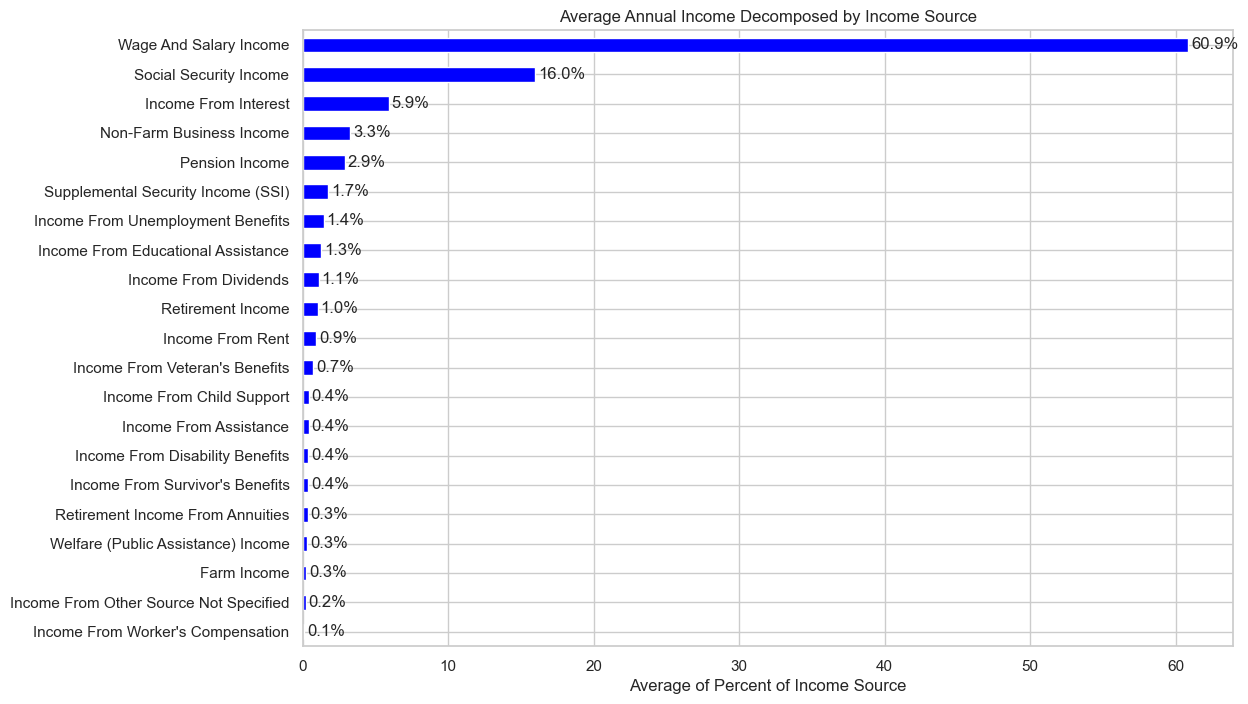

In [35]:
ax = wage_decomp.plot(kind='barh', color='blue', title="Average Annual Income Decomposed by Income Source")

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=2)

plt.xlabel("Average of Percent of Income Source")
plt.show()

## Aggregate Wage Decomp

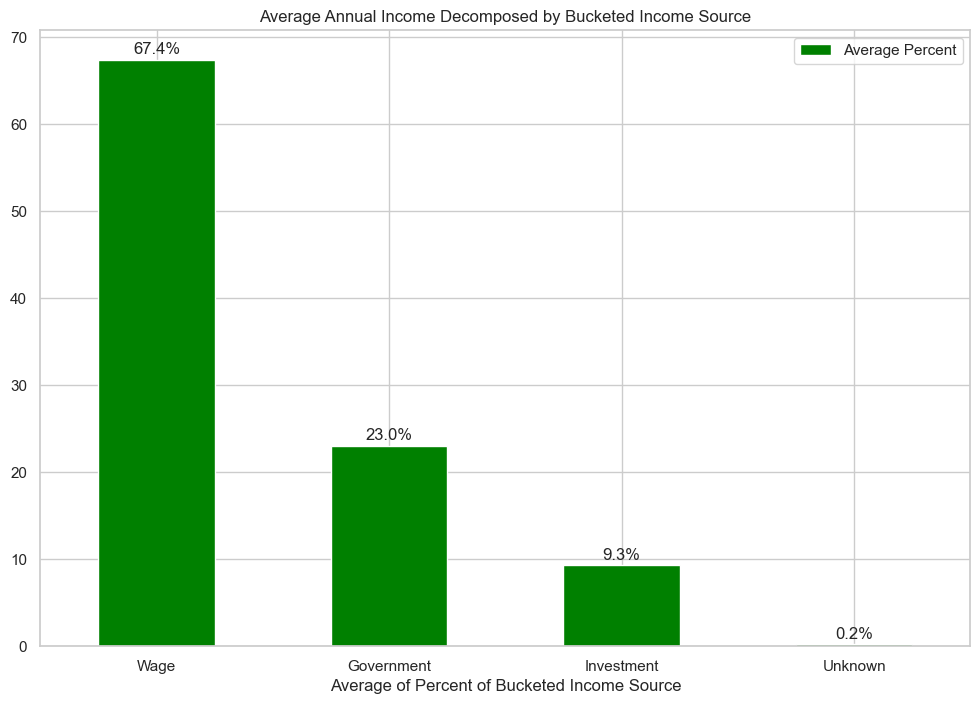

In [36]:
wdf = pd.DataFrame(wage_decomp, columns=['percent'])
wdf['Bucketed Income Source']= [wd_buckets[d] for d in wdf.index]
wdf2 = pd.DataFrame(wdf.groupby(by='Bucketed Income Source').sum()).sort_values(by='percent', ascending=False)
wdf2.rename({"percent": "Average Percent"}, axis=1, inplace=True)
ax = wdf2.plot(kind='bar', color='green', title="Average Annual Income Decomposed by Bucketed Income Source")

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=2)

plt.xlabel("Average of Percent of Bucketed Income Source")
plt.xticks(rotation='horizontal')
plt.show()

In [37]:
df['RACE_ORIGINAL'] = df['RACE']

x = pt(None, df, 'Race', 'ASECWT')

races = list(x.iloc[0:4,0].values)

df['Race_top_5'] = df['Race'].apply(lambda x: x if x in races else 'Other')
df['Race_full'] = np.where(df['Hispanic']!='Not Hispanic', 'Hispanic', df['Race_top_5'])

In [38]:
df['INCTOT_3'] = np.where(
    df['INCTOT'].fillna(0) < 0, 
    0, 
    df['INCTOT'].fillna(0)
)

df['Income Buckets'] = pd.qcut(df['INCTOT_3'], 10, duplicates='drop')

# Labor Force Deep Dive

In [39]:
pt(ddi_codebook, df, 'LABFORCE')

LABFORCE  code  count   Percent
0     Yes, in the labor force     2  73863  0.483612
1  No, not in the labor force     1  46751  0.306098
2                         NIU     0  32118   0.21029

In [40]:
df2 = df[df.LABFORCE==2].reset_index(drop=True)

In [2]:
sdf = pd.crosstab(
    df2['Income Buckets'].astype(str).apply(lambda x: clean_dollars(x)), 
    df2['Race_full'], 
    df2['ASECWT'], 
    aggfunc = len
).rename_axis(None, axis=1)

NameError: name 'pd' is not defined

In [1]:
print('Percent of Total')
(sdf.div(sdf.sum().sum()) * 100).round(1).style.background_gradient(axis=None, cmap='coolwarm').format('{:,.1f}%')

Percent of Total


NameError: name 'sdf' is not defined

In [43]:
print('Percent Down Columns')
(sdf.div(sdf.sum(axis=0)) * 100).round(1).style.background_gradient(axis=0, cmap='coolwarm').format('{:,.1f}%')

Percent Down Columns


In [44]:
print('Percent Across Rows')
(sdf.divide(sdf.sum(axis=1), axis=0) * 100).round(1).style.background_gradient(
    axis=1, cmap='coolwarm').format('{:,.1f}%')

Percent Across Rows


# Population By Occupation Code

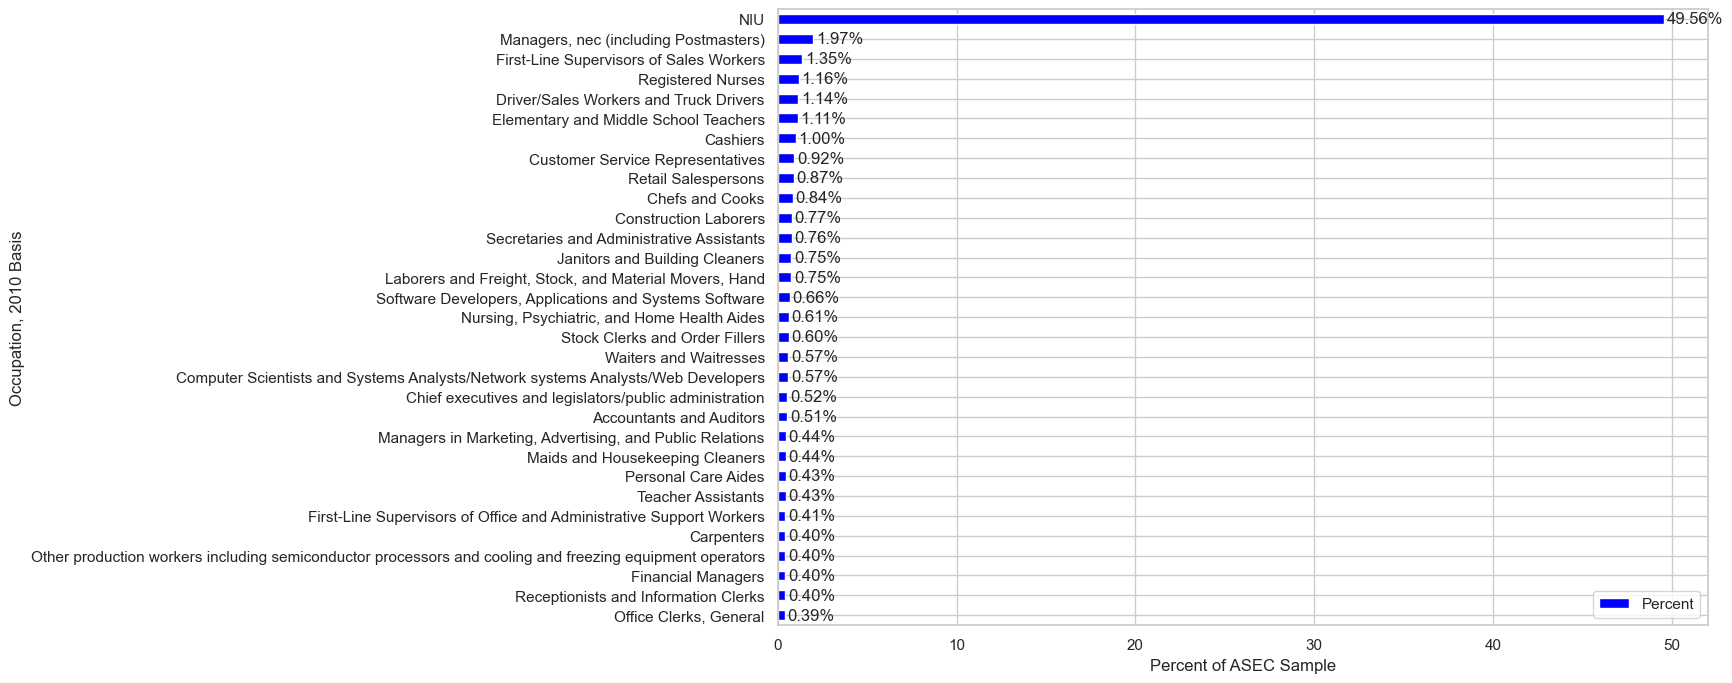

In [45]:
# ptbarplot(ddi_codebook, df[df['OCC2010']!=9999], 'OCC2010', 'ASECWT', color='blue')
ptbarplot(ddi_codebook, df, 'OCC2010', 'ASECWT', color='blue')

# Population by Race

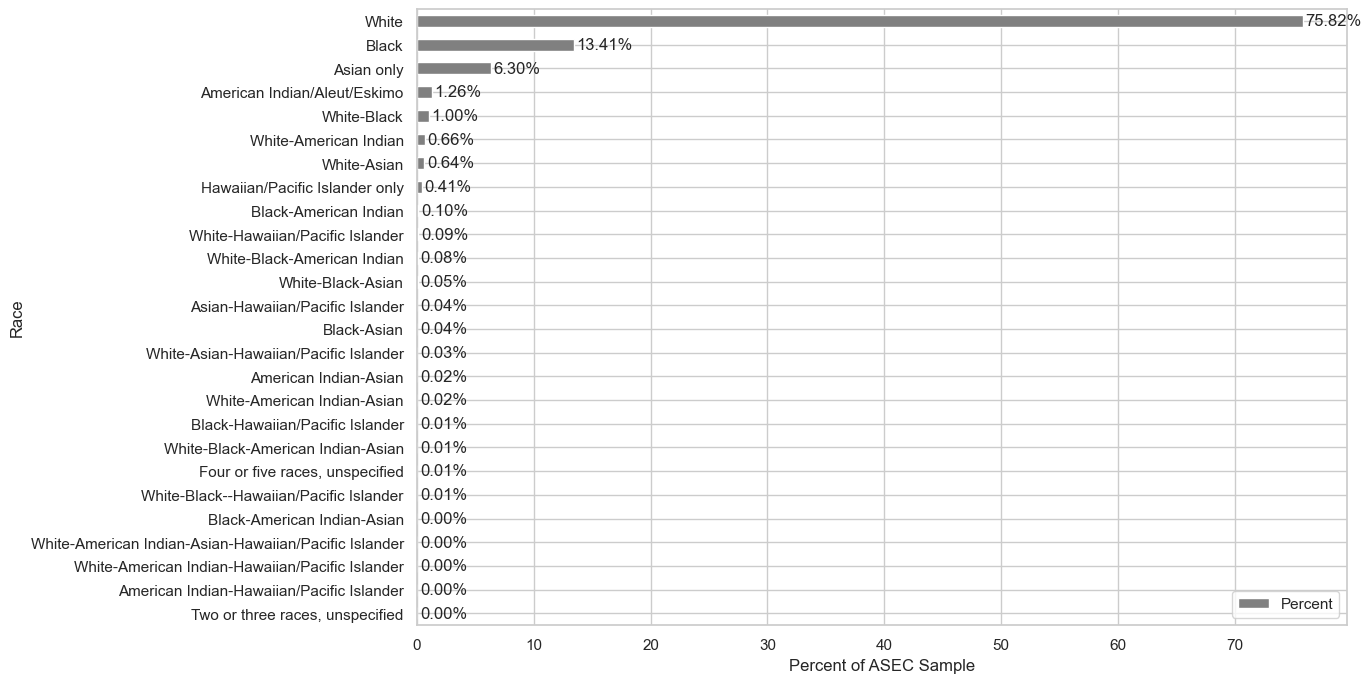

In [46]:
ptbarplot(ddi_codebook, df, 'RACE', 'ASECWT', color='gray')

# Population by Worker Status

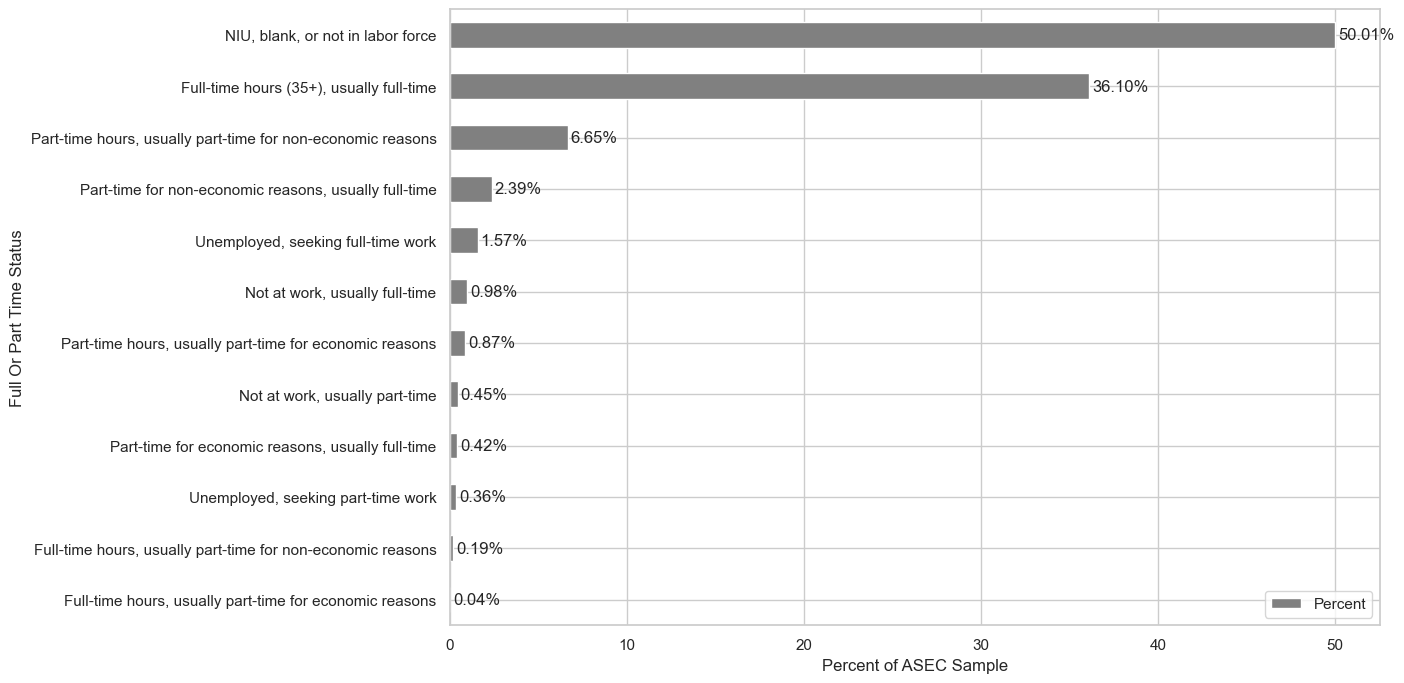

In [47]:
ptbarplot(ddi_codebook, df, 'WKSTAT', 'ASECWT', color='gray')

# Population by Class of Worker

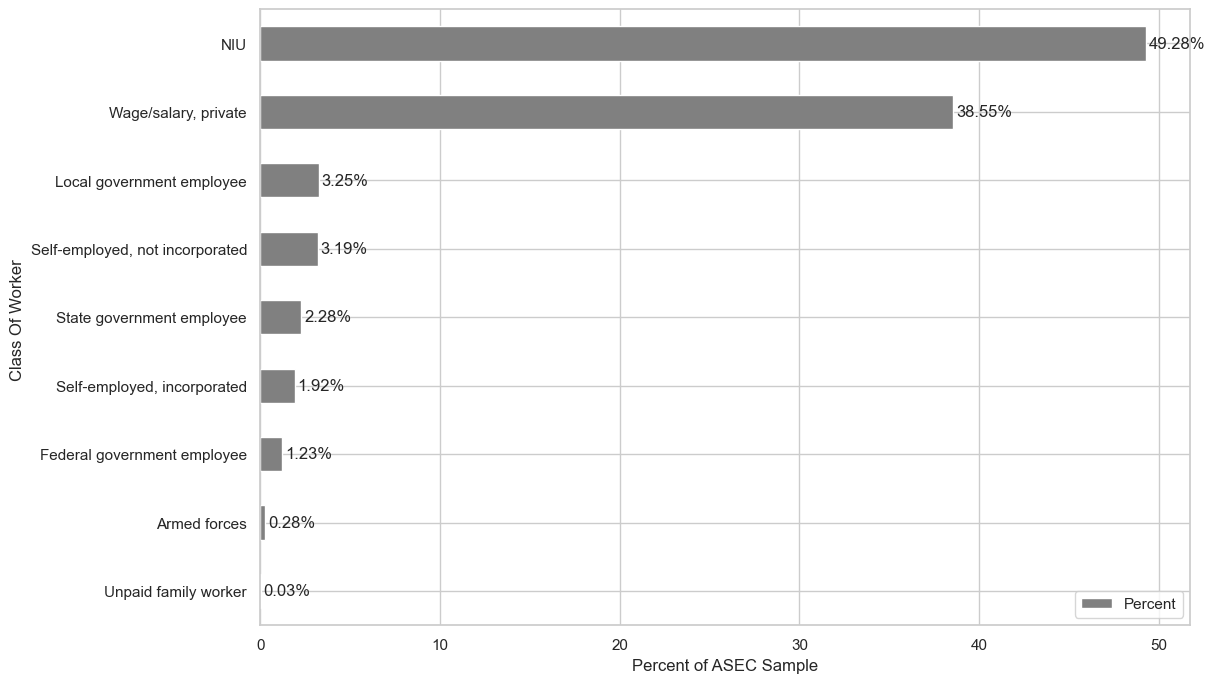

In [48]:
ptbarplot(ddi_codebook, df, 'CLASSWKR', 'ASECWT', color='gray')

# Population by Nativity

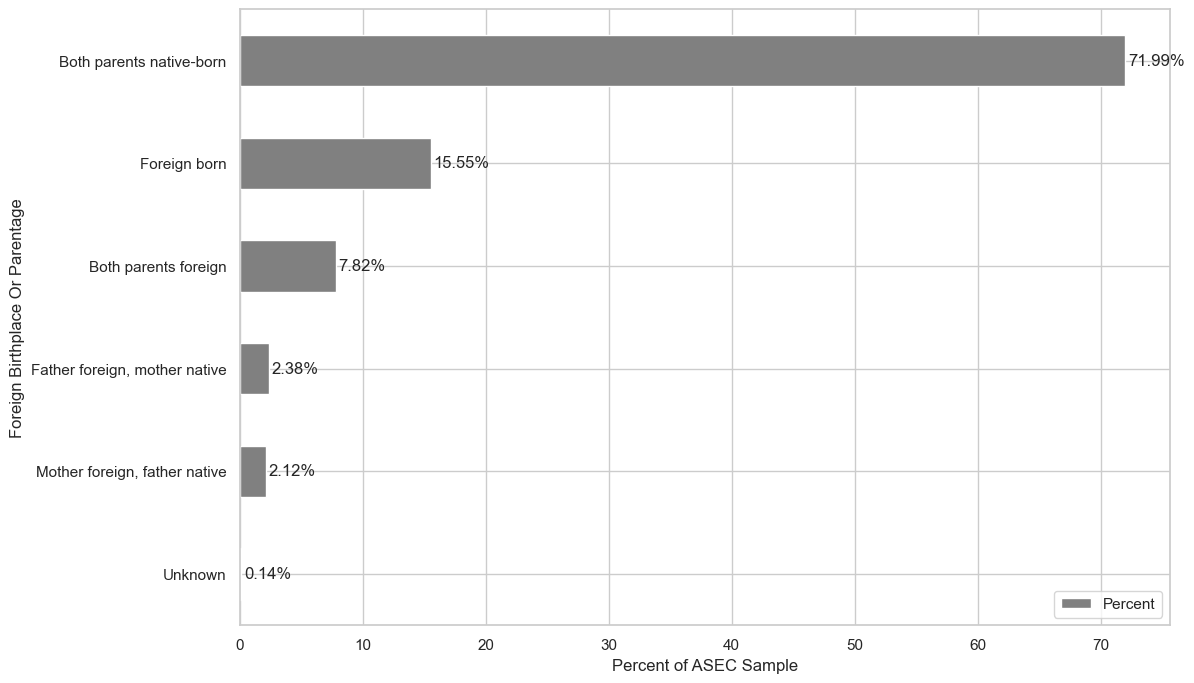

In [49]:
ptbarplot(ddi_codebook, df, 'NATIVITY', 'ASECWT', color='gray')

# Population by Citizenship

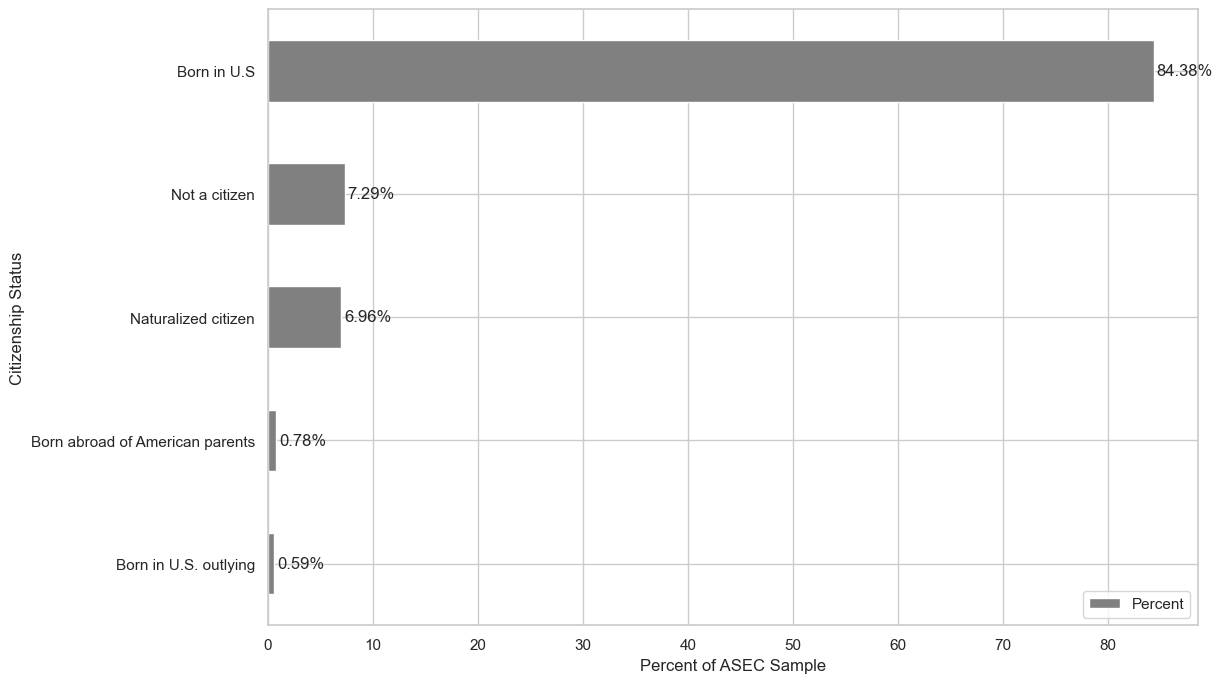

In [50]:
ptbarplot(ddi_codebook, df, 'CITIZEN', 'ASECWT', color='gray')

# Population by Veteran's Status

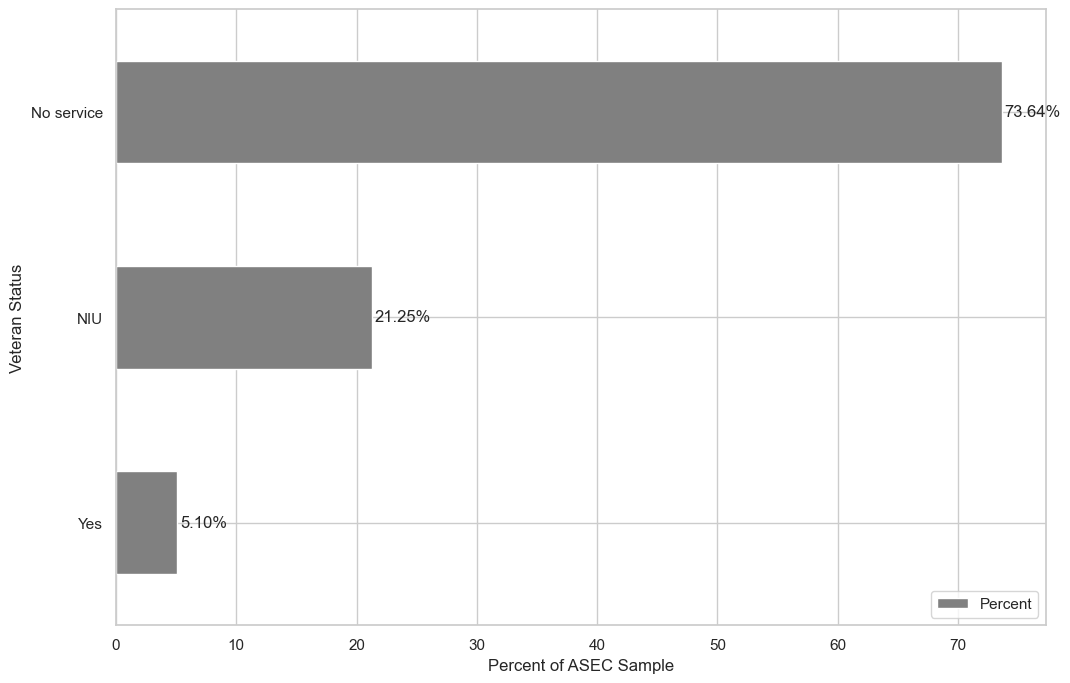

In [51]:
ptbarplot(ddi_codebook, df, 'VETSTAT', 'ASECWT', color='gray')

# Population by Marital Status

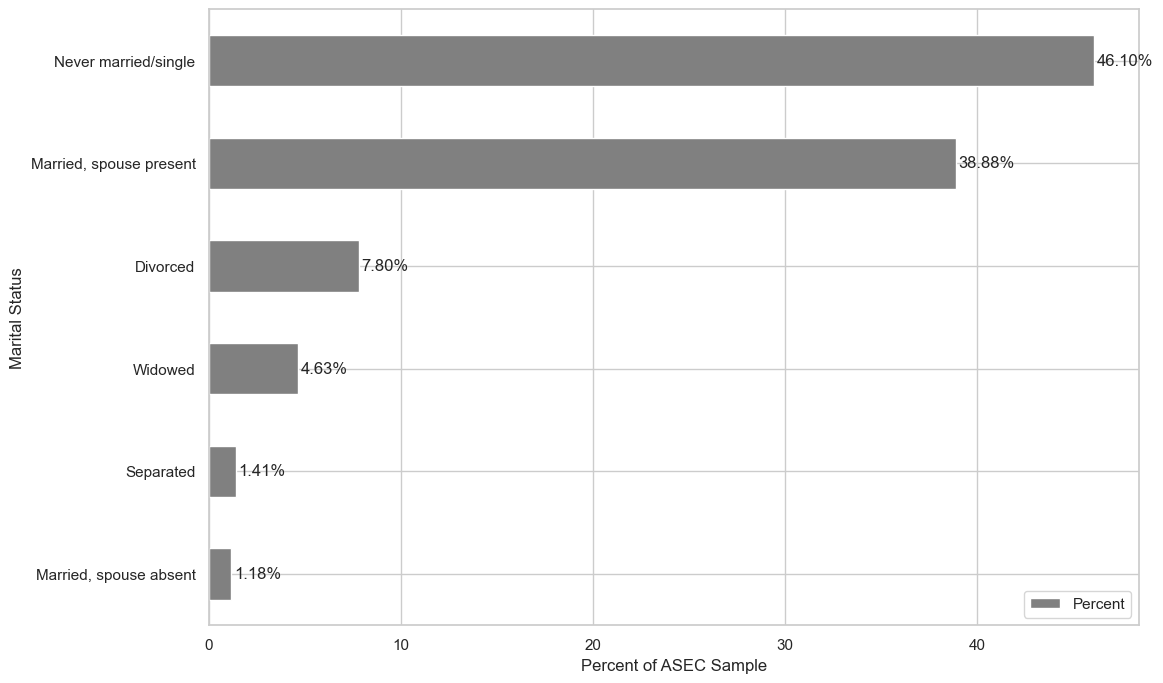

In [52]:
ptbarplot(ddi_codebook, df, 'MARST', 'ASECWT', color='gray')

# Population by Employment Status

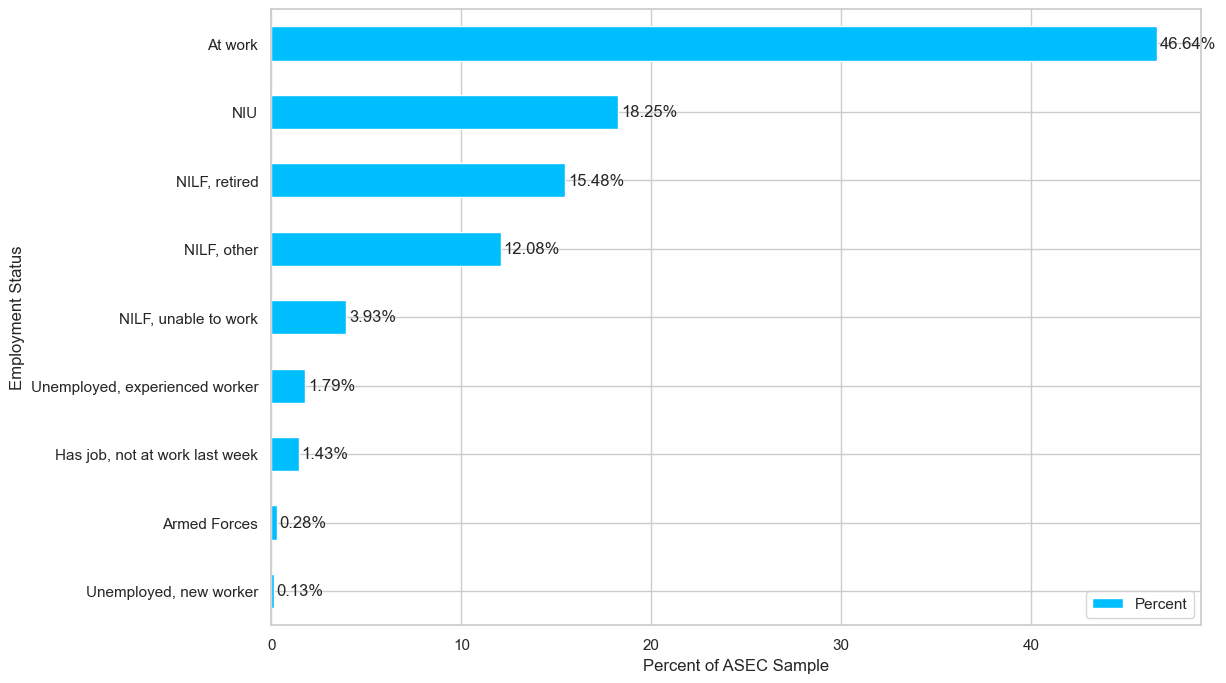

In [53]:
ptbarplot(ddi_codebook, df, 'EMPSTAT', 'ASECWT', color='deepskyblue')

# Population by Labor Force

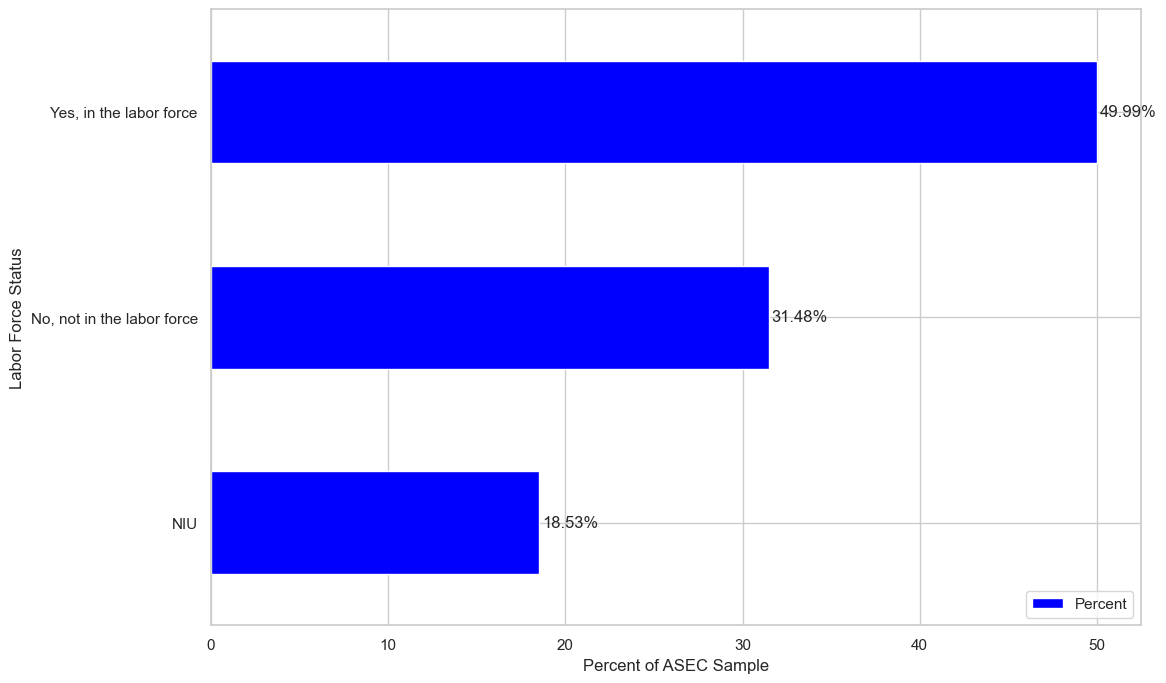

In [54]:
ptbarplot(ddi_codebook, df, 'LABFORCE', 'ASECWT', color='blue')

# Population by Poverty Line

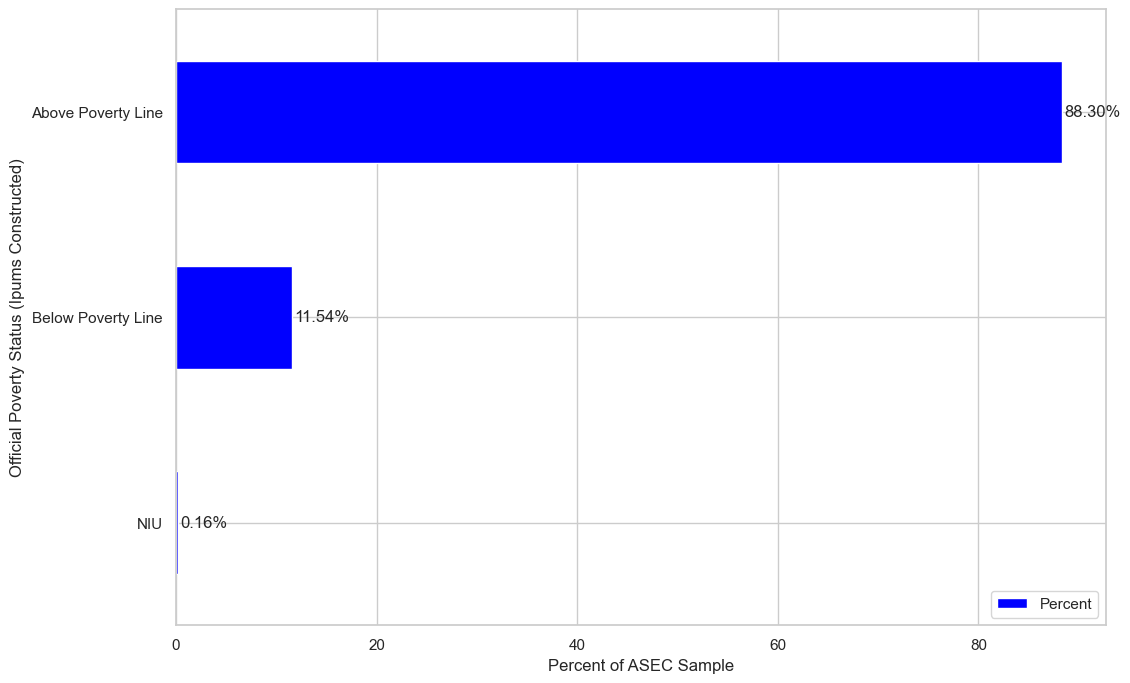

In [55]:
ptbarplot(ddi_codebook, df, 'OFFPOV', 'ASECWT', color='blue')

# Population by Highest Level of Education

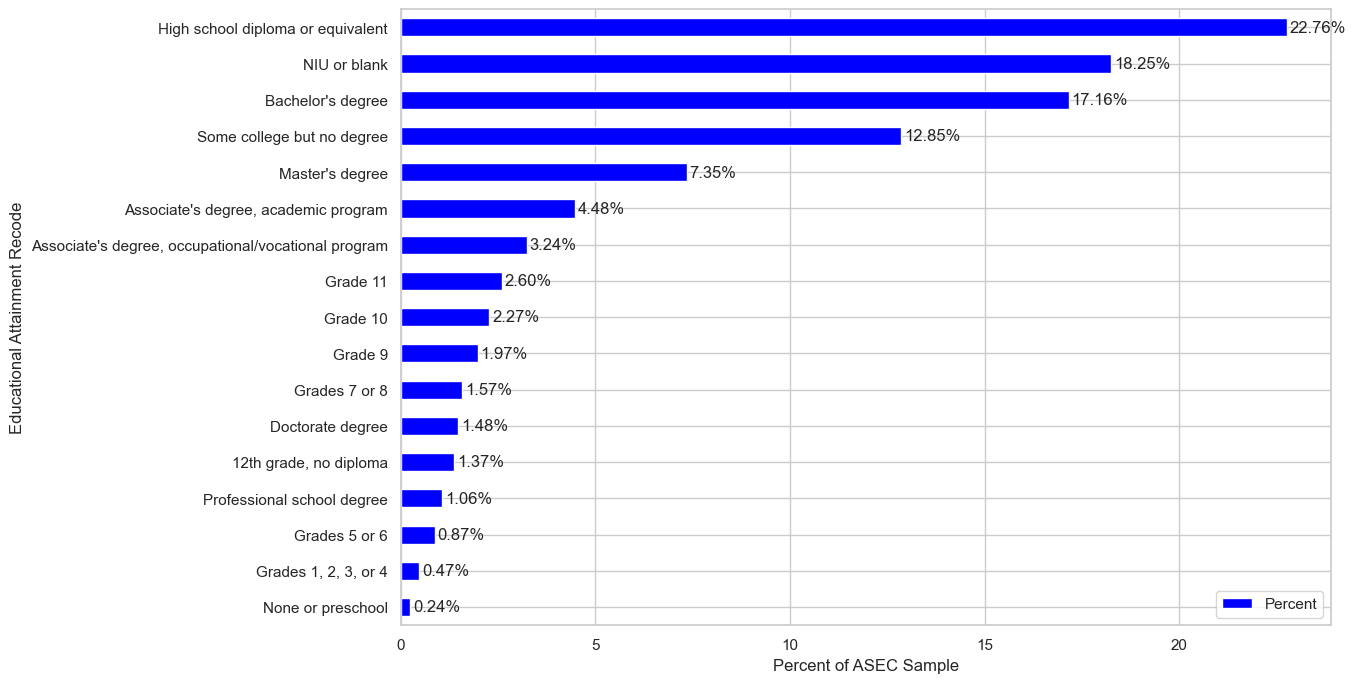

In [56]:
ptbarplot(ddi_codebook, df, 'EDUC', 'ASECWT',  color='blue')

# Population by Race

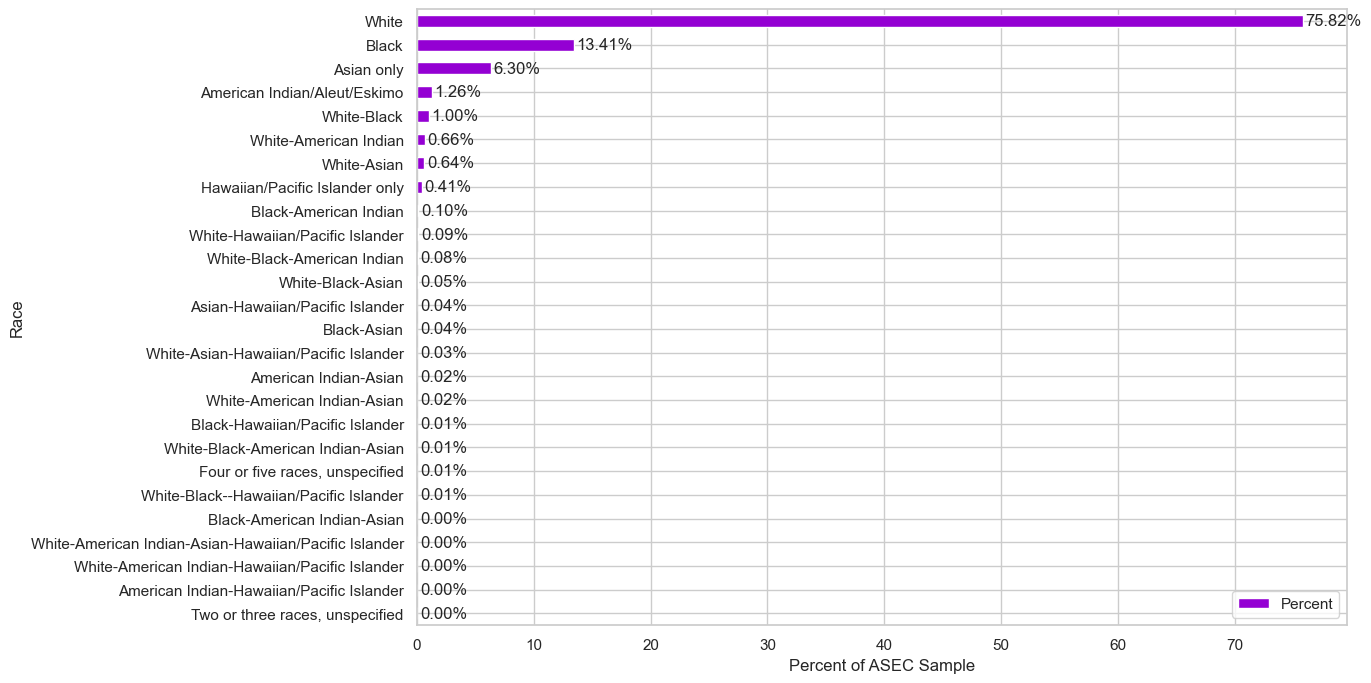

In [57]:
ptbarplot(ddi_codebook, df, 'RACE', 'ASECWT', color='darkviolet')

# Population by Hispanic Group

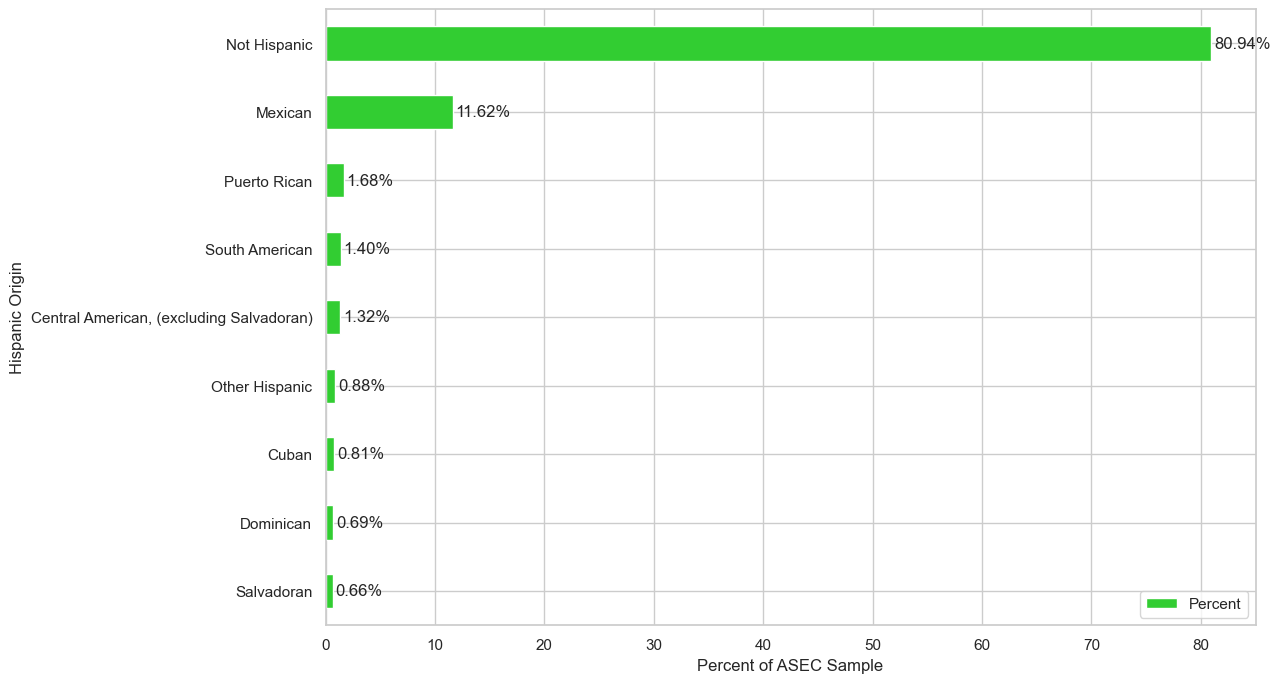

In [58]:
ptbarplot(ddi_codebook, df, 'HISPAN', 'ASECWT', color='limegreen')

# Population by Asian Group

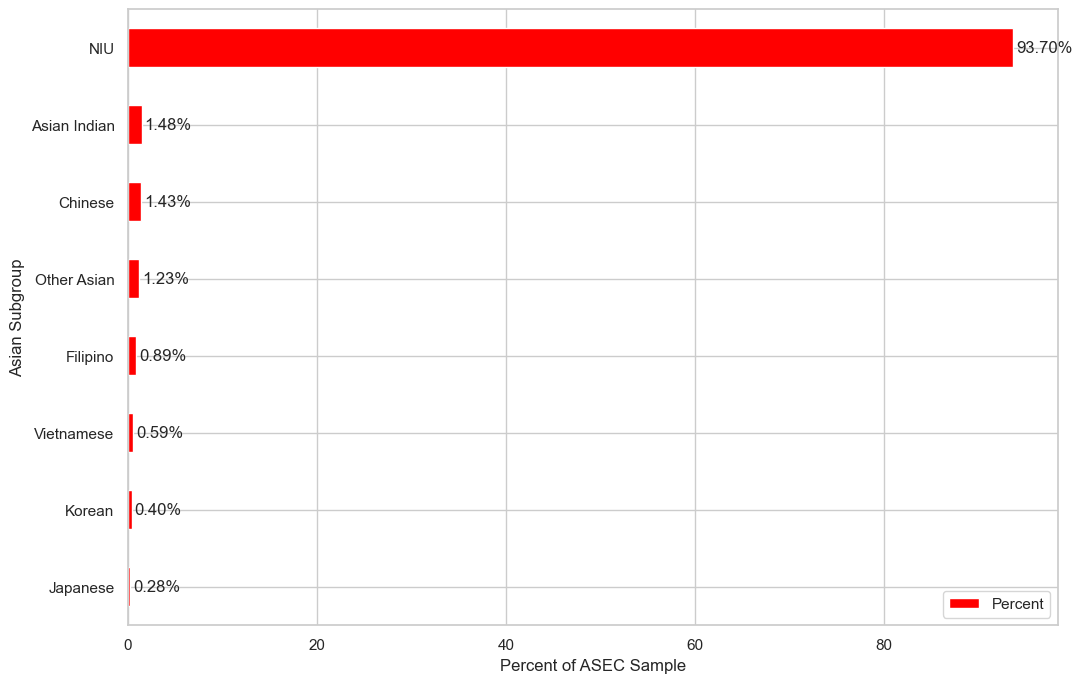

In [59]:
ptbarplot(ddi_codebook, df, 'ASIAN', 'ASECWT', color='red')

# Population by Birthplace

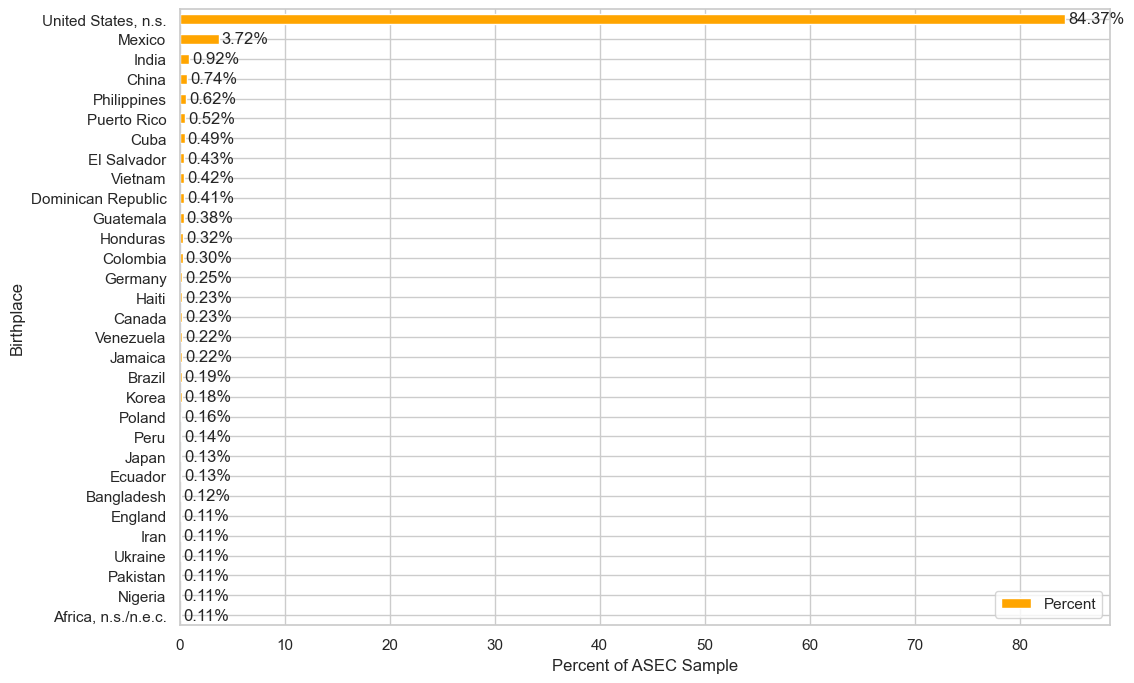

In [60]:
ptbarplot(ddi_codebook, df, 'BPL', 'ASECWT', color='orange')

# Population by Age

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/1279072071.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0, 0.5, 'Cumulative Percent of ASEC Sample')

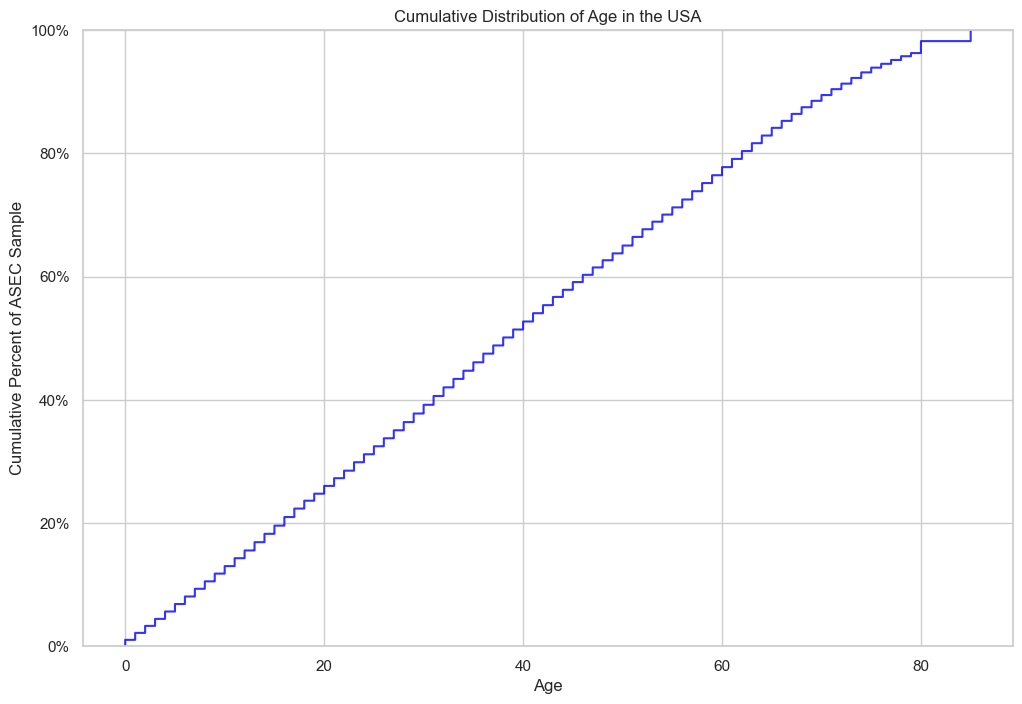

In [61]:
p = sns.ecdfplot(
    data=df,
    # stat='cumulative',
    weights='ASECWT',
    x='Age',
    color='blue',
    alpha=0.8,
)
p.set_yticklabels([f'{x*100:.0f}%' for x in p.get_yticks()])
# p#.axes.yaxis.set_major_formatter(PercentFormatter(1))
p.set(title="Cumulative Distribution of Age in the USA")
p.set_ylabel("Cumulative Percent of ASEC Sample")

/Users/franciscojavierarceo/.pyenv/versions/3.8.16/lib/python3.8/site-packages/seaborn/distributions.py:416: UserWarning:

`bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/3028629219.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0, 0.5, 'Percent of ASEC Sample')

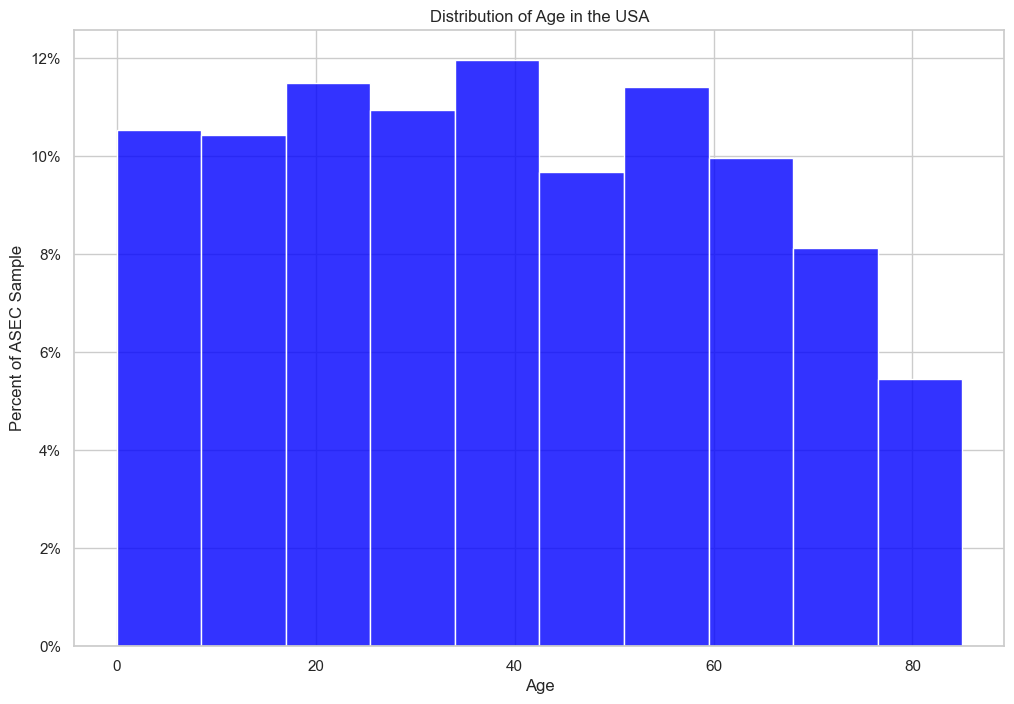

In [62]:
p = sns.histplot(
    data=df,
    stat='percent',
    weights='ASECWT',
    x='Age',
    color='blue',
    alpha=0.8,
)
p.set_yticklabels([f'{x:.0f}%' for x in p.get_yticks()])
# p#.axes.yaxis.set_major_formatter(PercentFormatter(1))
p.set(title="Distribution of Age in the USA")
p.set_ylabel("Percent of ASEC Sample")

[Text(0.5, 1.0, 'Age by Educational Attainment')]

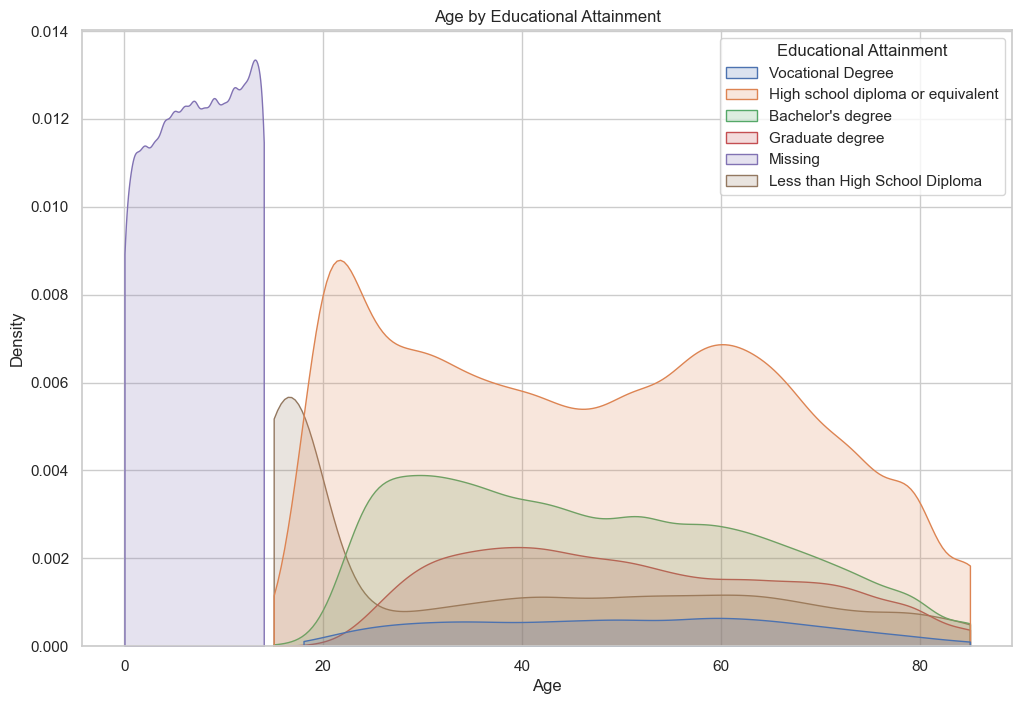

In [63]:
sns.kdeplot(
    data=df,
    weights='ASECWT', 
    x='Age', 
    hue='Educational Attainment', 
    color='blue',
    cut=0, 
    fill=True, 
    # common_norm=False, 
    alpha=0.2, 
    # ax=ax1,
    # palette=pal,
).set(title='Age by Educational Attainment')

count     121119.0
mean       50075.0
std        78828.0
min        -9999.0
25%        10092.0
50%        30445.0
75%        62538.0
max      2082782.0
Name: INCTOT, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



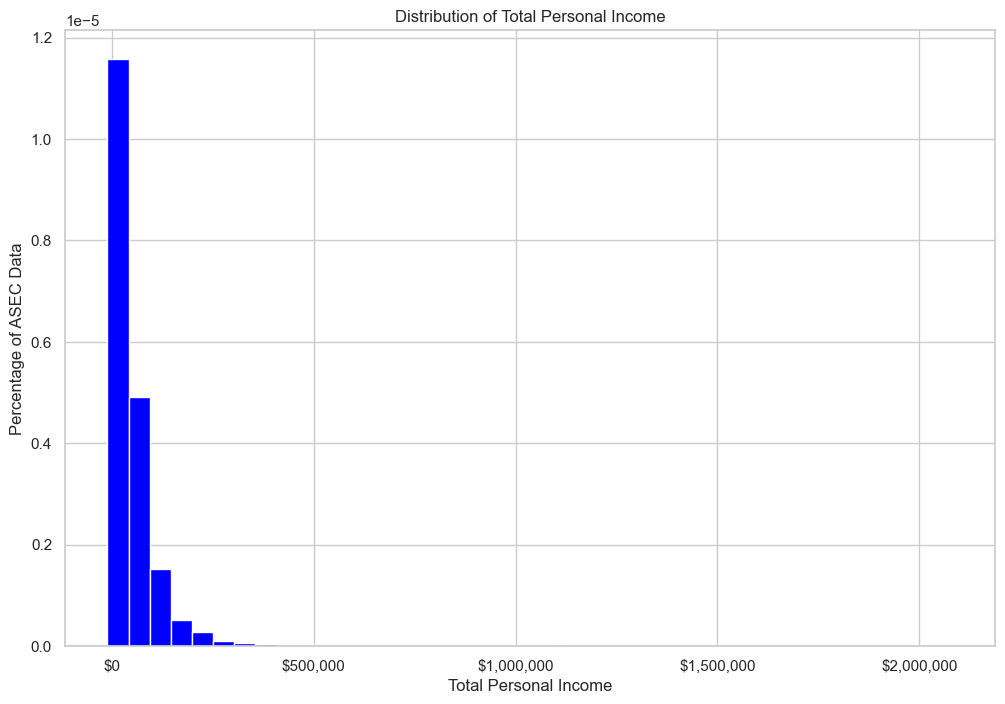

count     121119.0
mean       36800.0
std        68924.0
min            0.0
25%            0.0
50%        15000.0
75%        52000.0
max      1550000.0
Name: INCWAGE, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



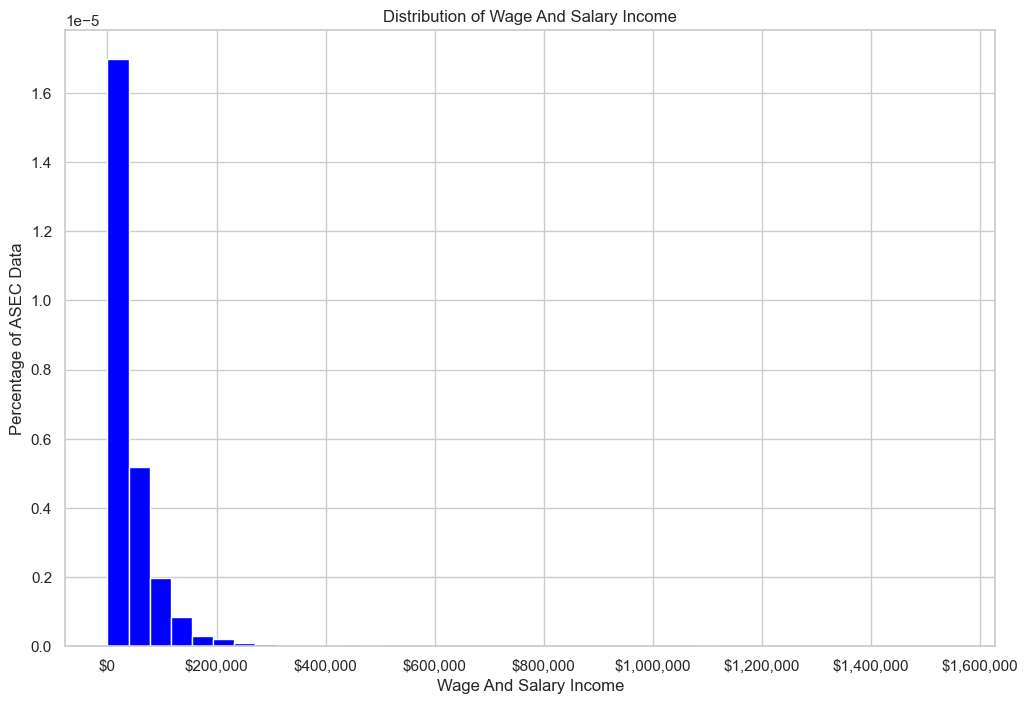

count     121119.0
mean        1861.0
std        18673.0
min        -9999.0
25%            0.0
50%            0.0
75%            0.0
max      1099999.0
Name: INCBUS, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



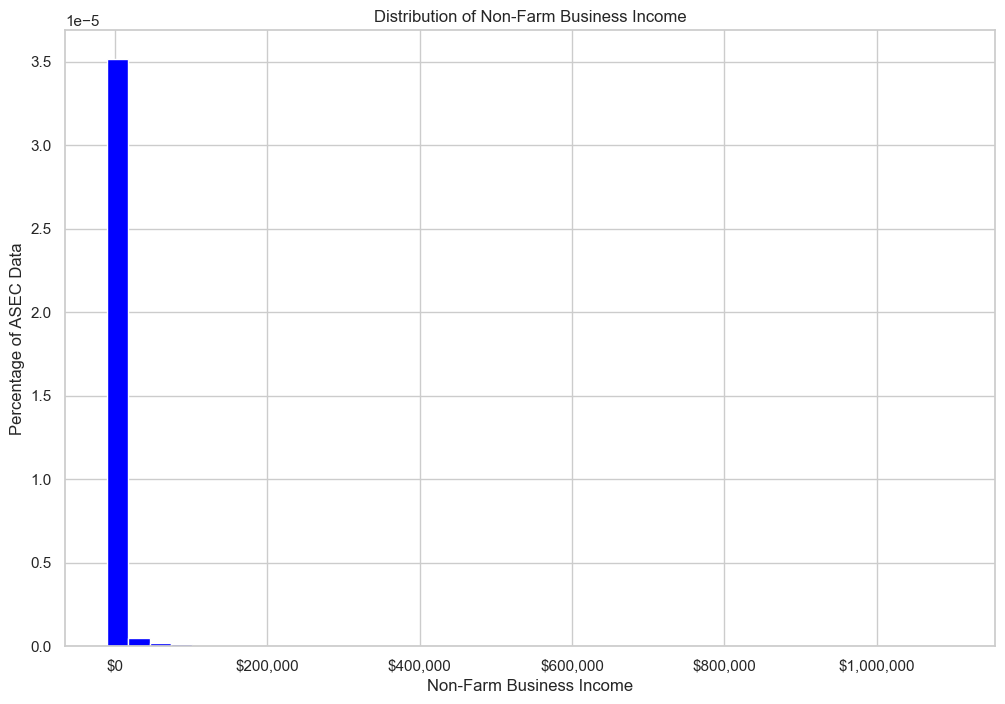

count     121119.0
mean         189.0
std         5823.0
min       -10000.0
25%            0.0
50%            0.0
75%            0.0
max      1099999.0
Name: INCFARM, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



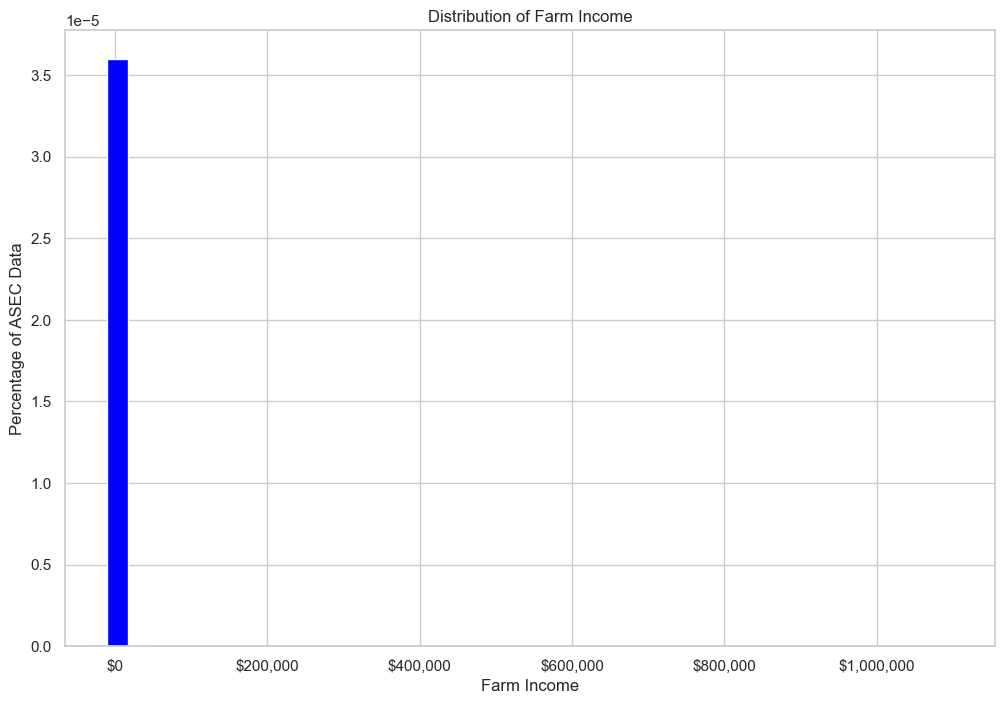

count    121119.0
mean       3445.0
std        7903.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max       62400.0
Name: INCSS, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



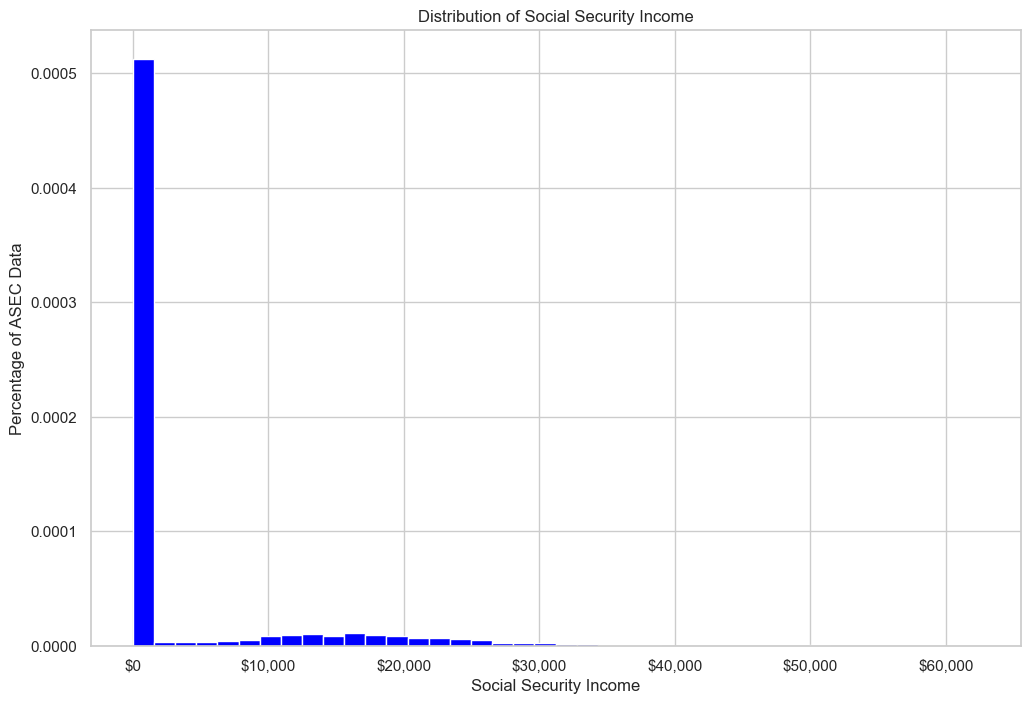

count    121119.0
mean         26.0
std         501.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max       25000.0
Name: INCWELFR, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



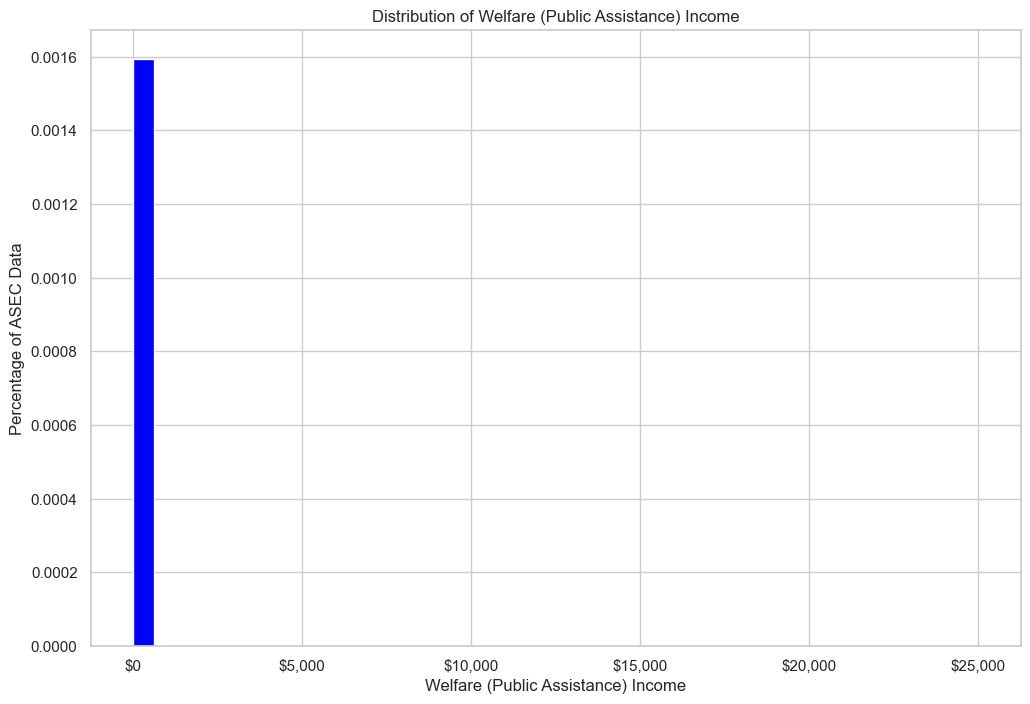

count     152726.0
mean         552.0
std         6997.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max      1035999.0
Name: INCRETIR, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



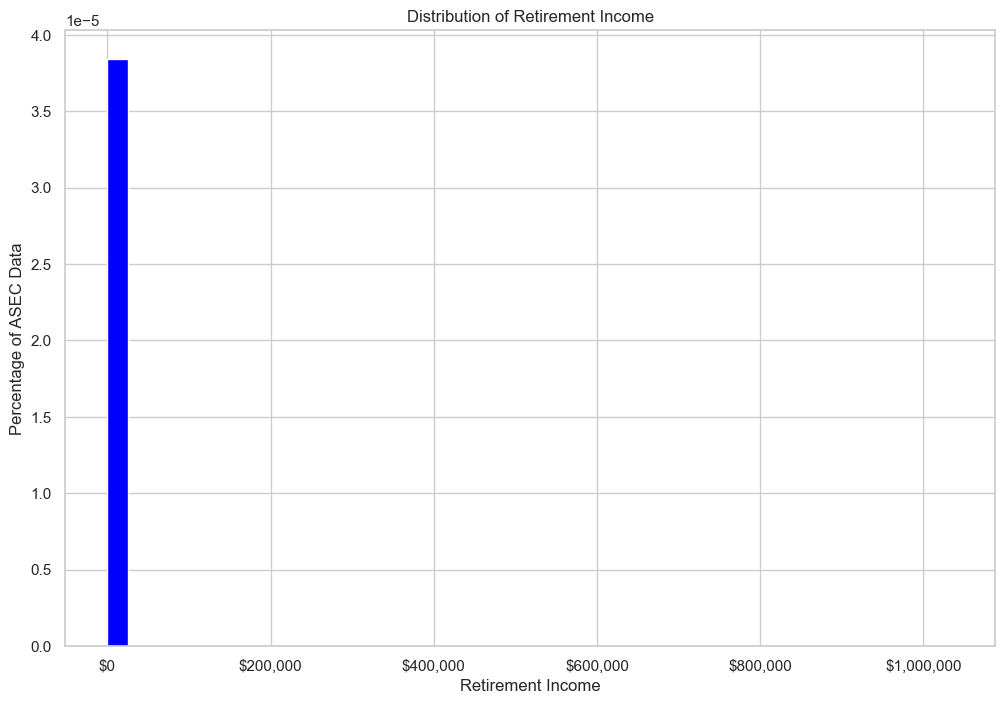

count    121119.0
mean        193.0
std        1541.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max       30000.0
Name: INCSSI, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



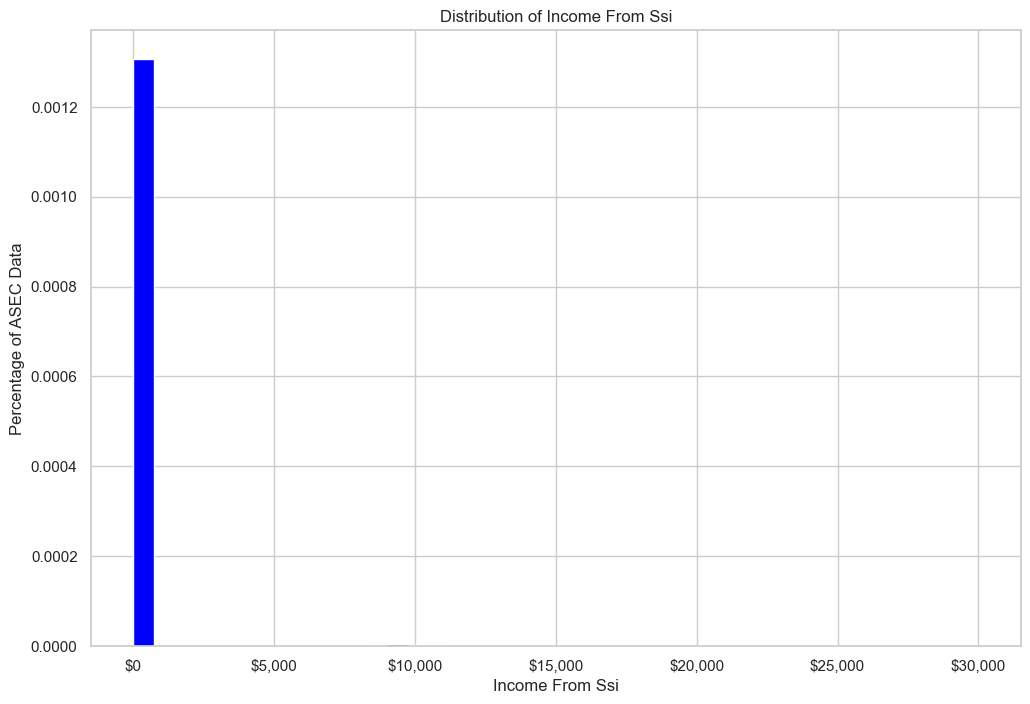

count     152732.0
mean     2071533.0
std      4050591.0
min            0.0
25%            0.0
50%           14.0
75%         8120.0
max      9999999.0
Name: INCINT, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



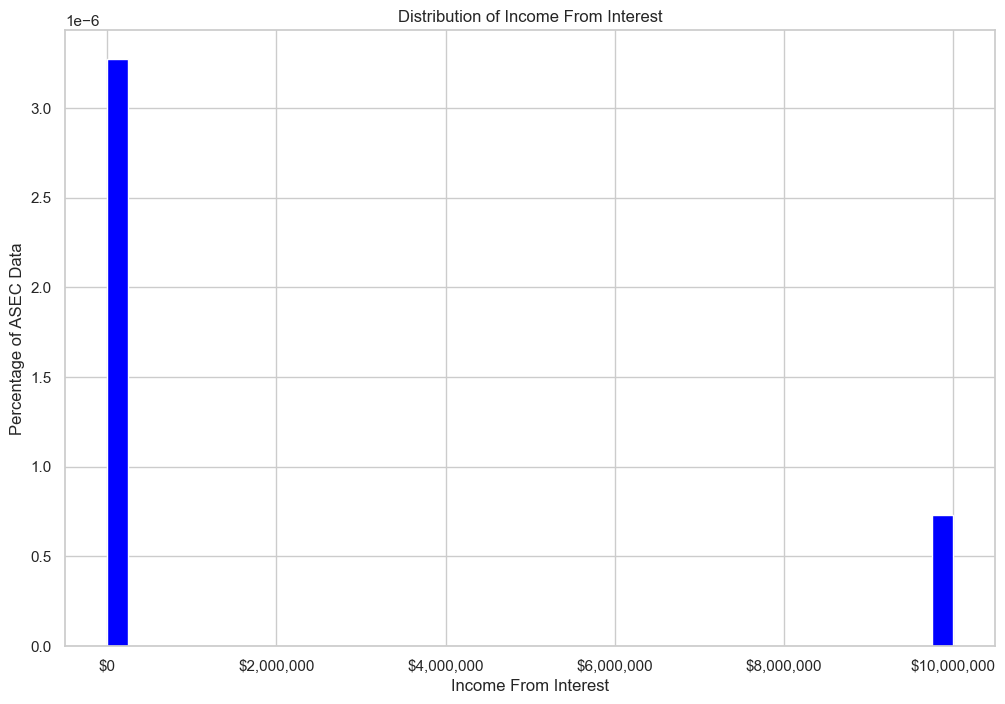

count    121119.0
mean        305.0
std        2347.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max       99999.0
Name: INCUNEMP, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



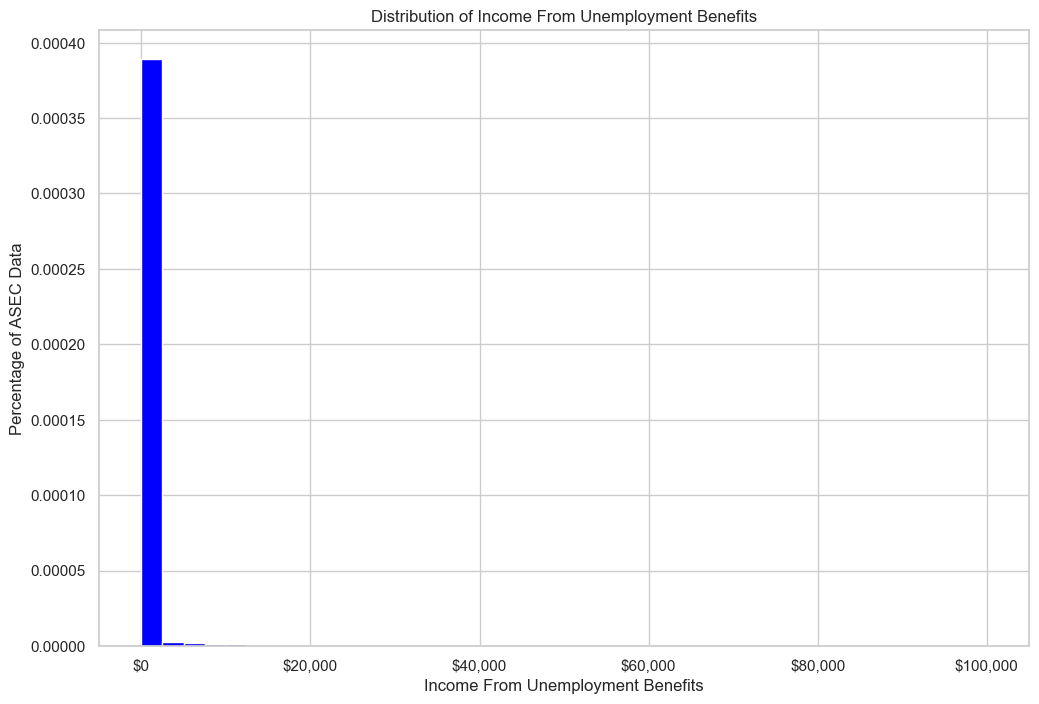

count    121119.0
mean         37.0
std        1031.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max       99999.0
Name: INCWKCOM, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



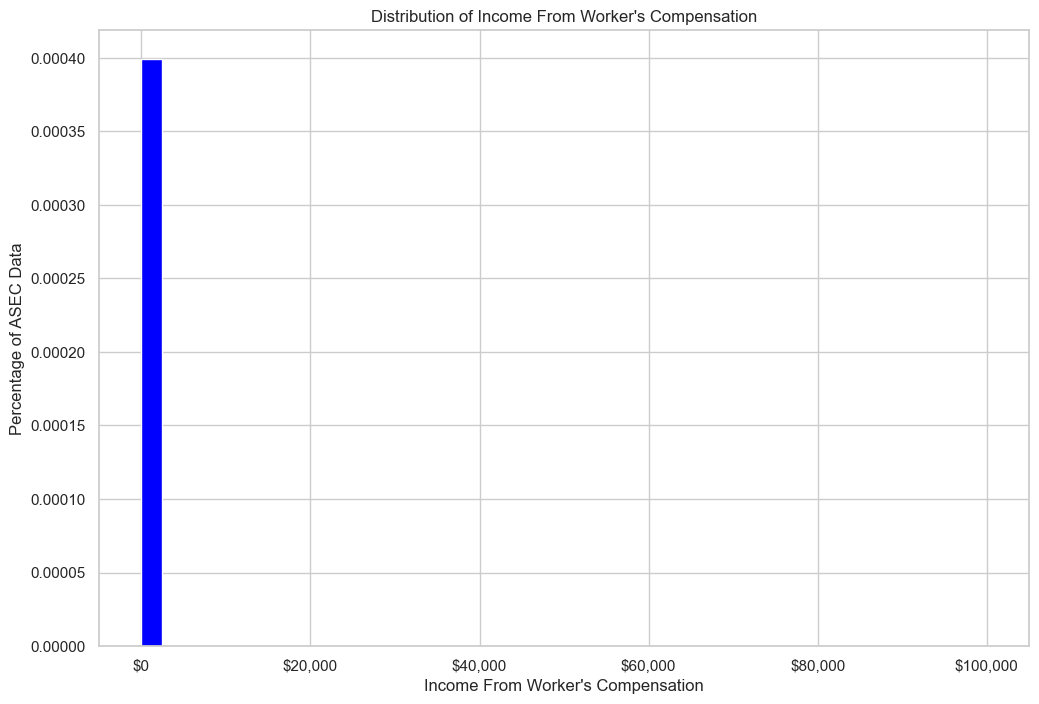

count     152732.0
mean     2070108.0
std      4051310.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max      9999999.0
Name: INCVET, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



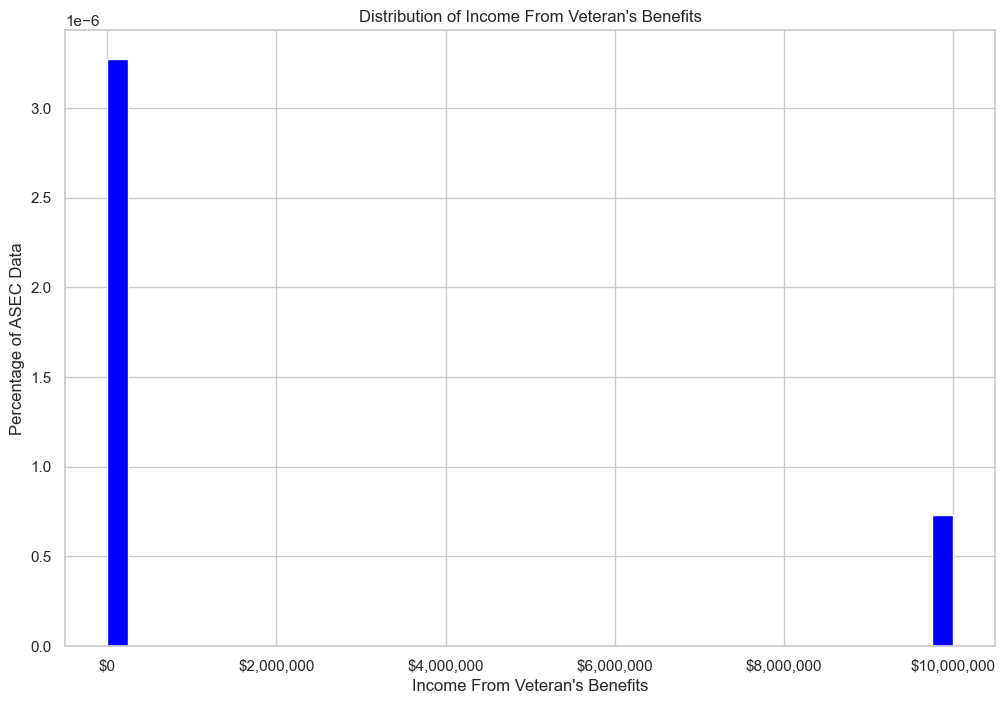

count     152732.0
mean     2069992.0
std      4051369.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max      9999999.0
Name: INCSURV, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



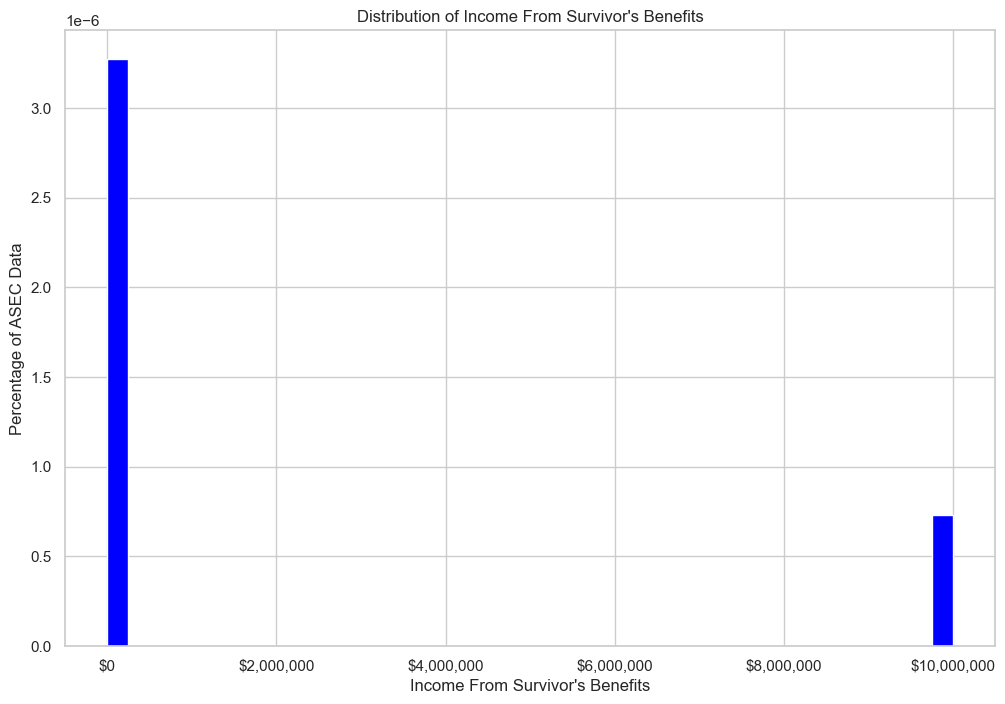

count     152732.0
mean     2069930.0
std      4051400.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max      9999999.0
Name: INCDISAB, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



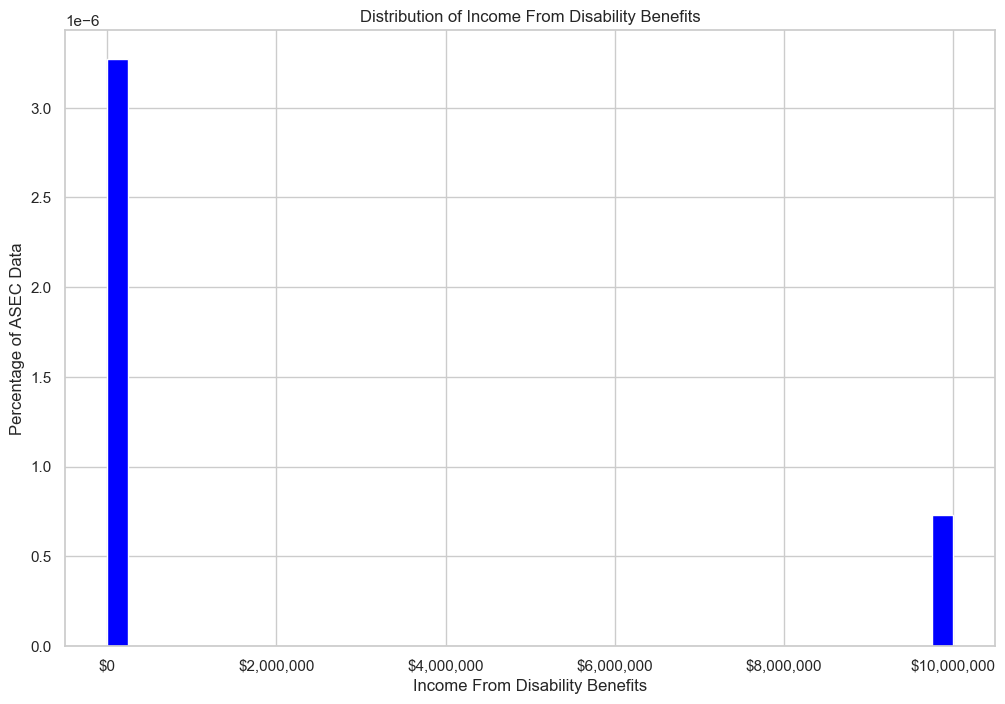

count     152728.0
mean     2070433.0
std      4051218.0
min            0.0
25%            0.0
50%            0.0
75%         1000.0
max      9999999.0
Name: INCDIVID, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



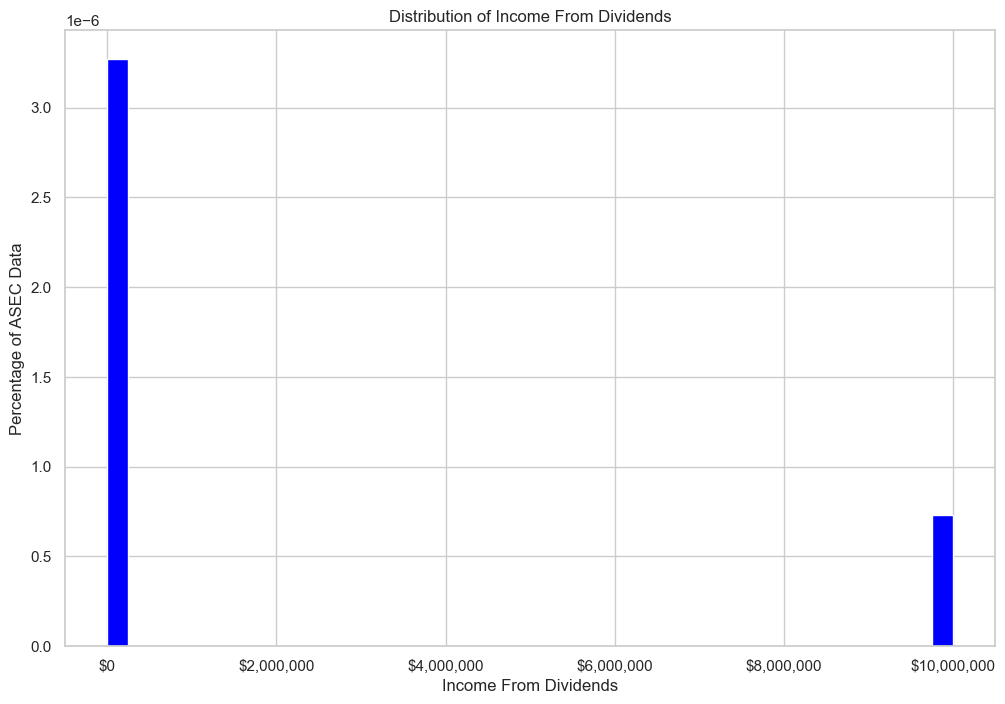

count     152728.0
mean     2070483.0
std      4051199.0
min        -9999.0
25%            0.0
50%            0.0
75%            0.0
max      9999999.0
Name: INCRENT, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



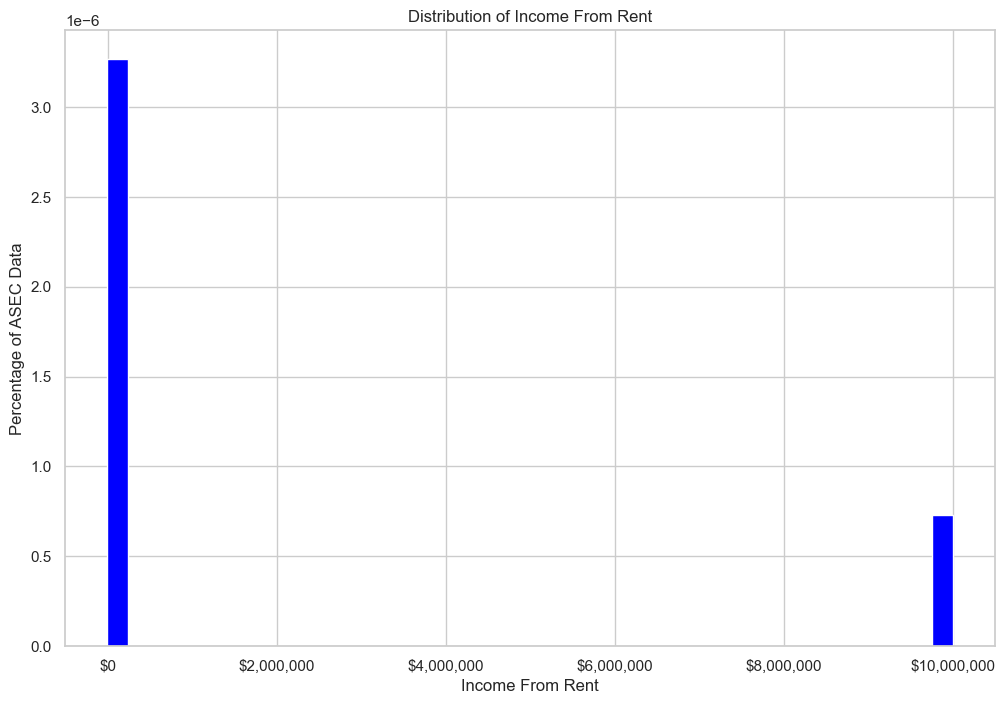

count    121119.0
mean        216.0
std        2181.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max      150000.0
Name: INCEDUC, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



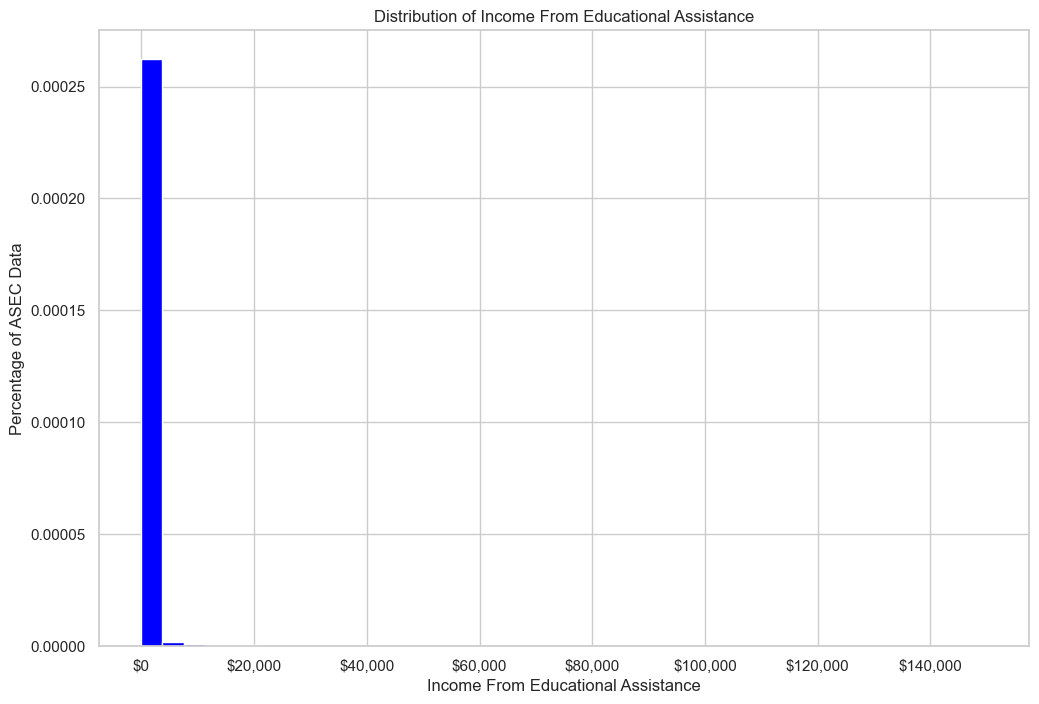

count    121119.0
mean         89.0
std        1198.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max       99999.0
Name: INCCHILD, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



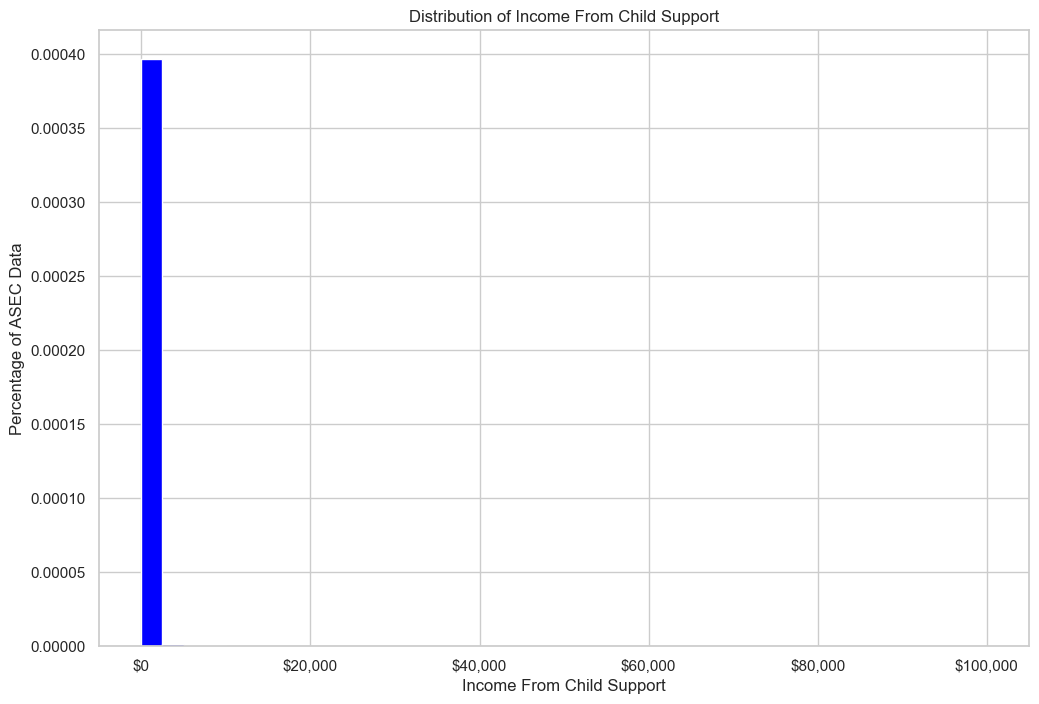

count     152732.0
mean     2069894.0
std      4051419.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max      9999999.0
Name: INCASIST, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



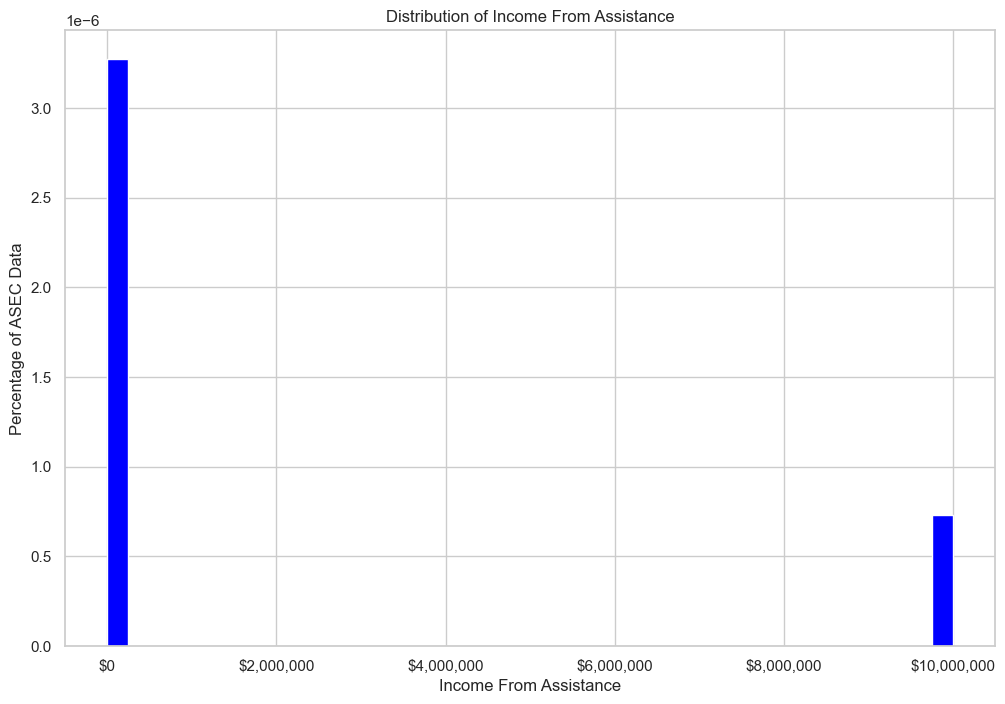

count    152732.0
mean         53.0
std        2271.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max      345000.0
Name: INCOTHER, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



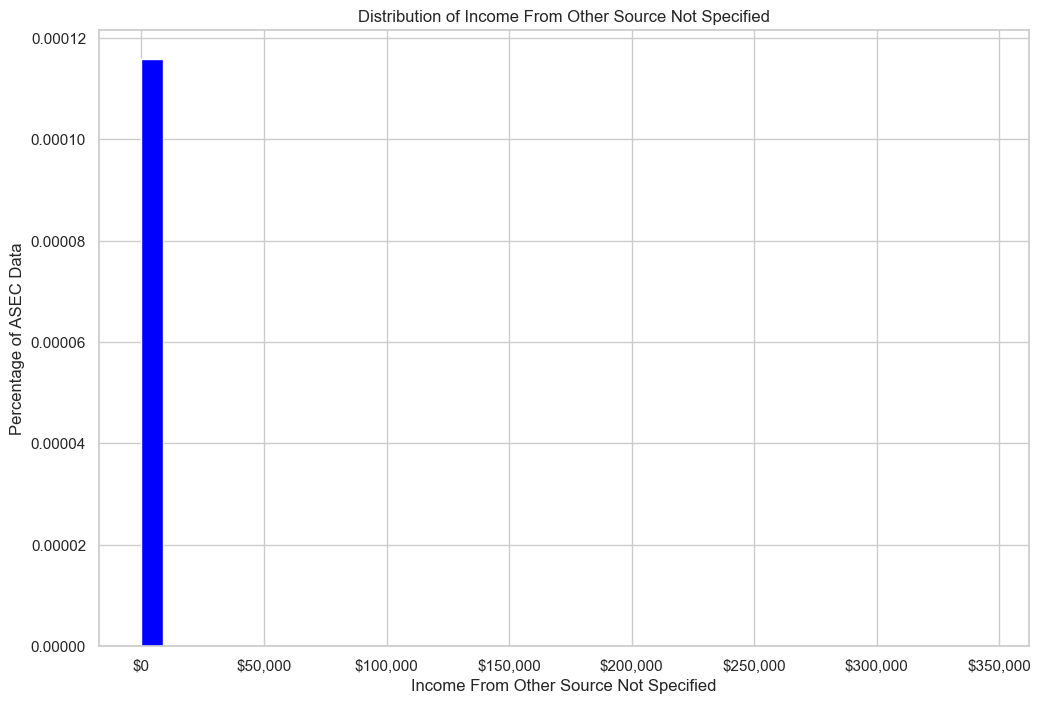

count    152730.0
mean        148.0
std        2848.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max      350000.0
Name: INCRANN, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



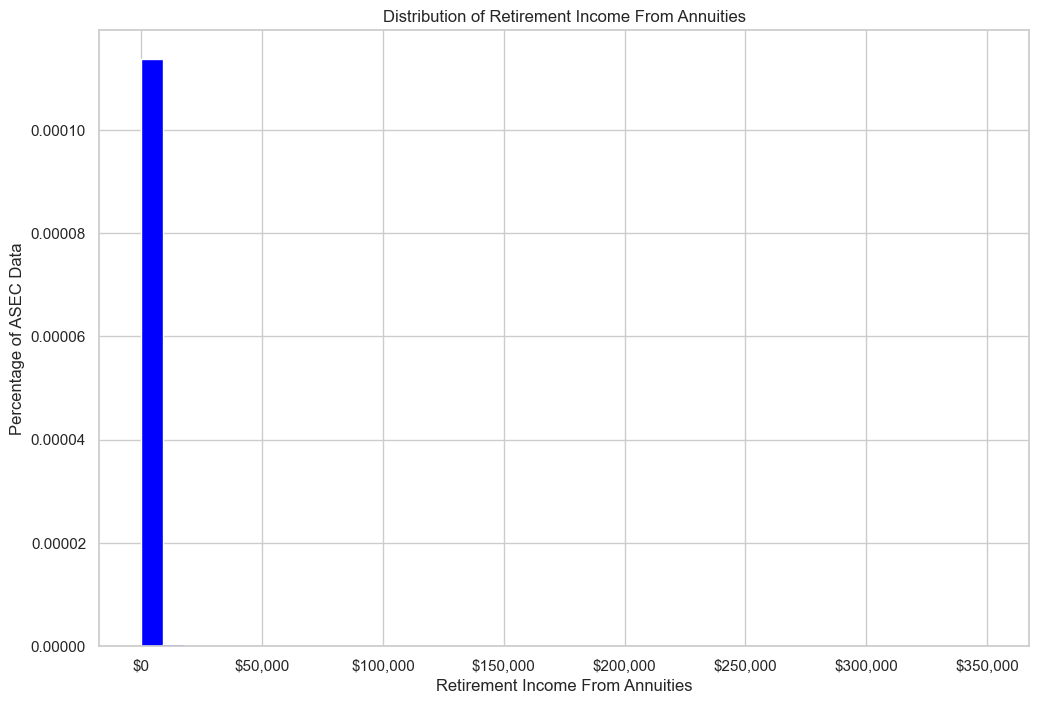

count    152727.0
mean       1172.0
std        8607.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max      999060.0
Name: INCPENS, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



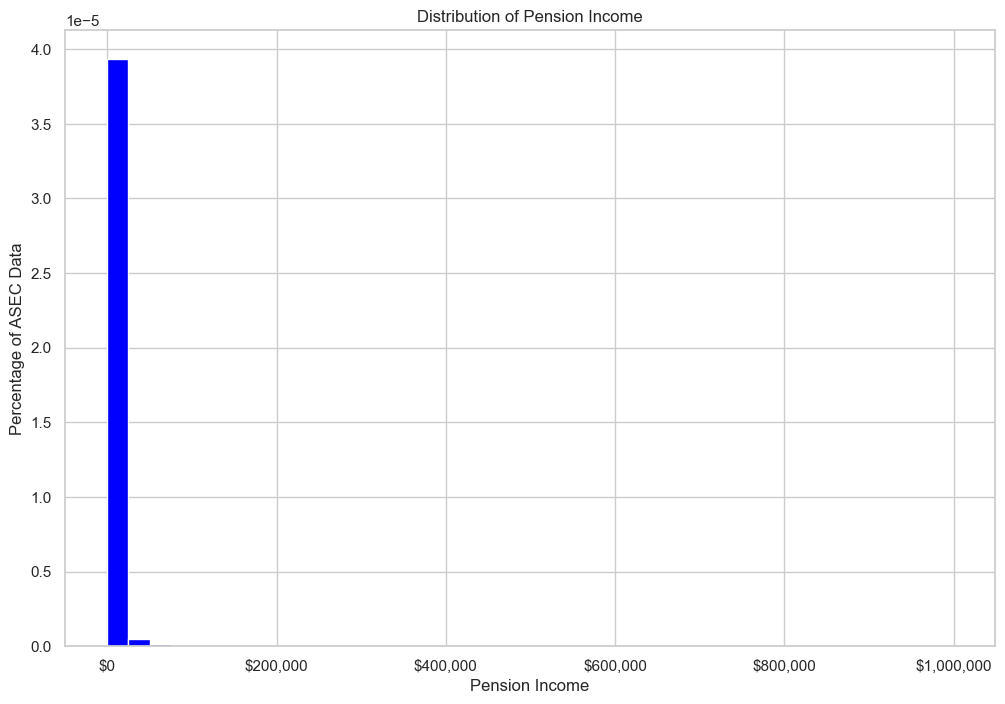

count     121119.0
mean       47189.0
std        97490.0
min      -141217.0
25%            0.0
50%         9140.0
75%        60000.0
max      3240777.0
Name: ADJGINC, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



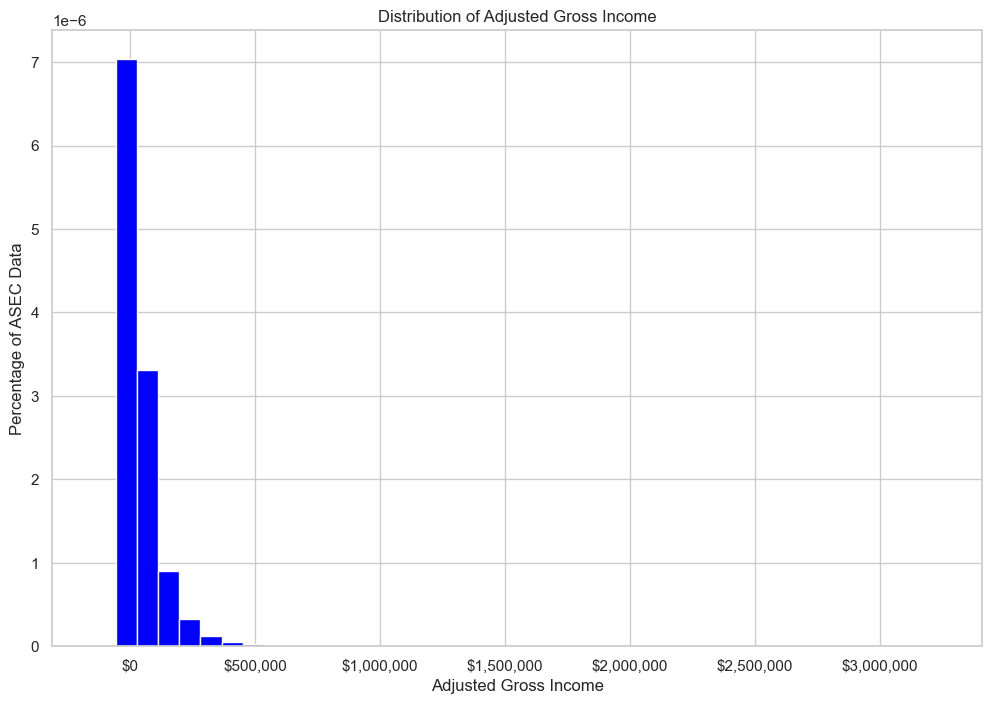

count     152732.0
mean     2098775.0
std      4037451.0
min            0.0
25%            0.0
50%        16202.0
75%       158080.0
max      9999999.0
Name: TAXINC, dtype: float64


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2977059858.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



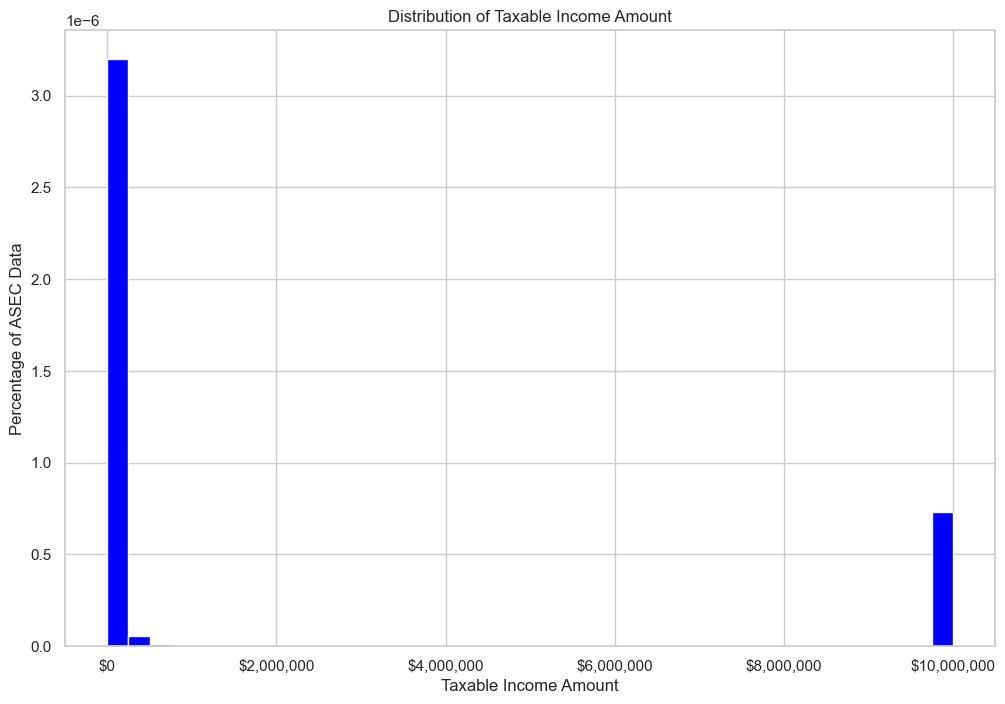

count     152732.0
mean       39715.0
std        73068.0
min            0.0
25%            0.0
50%        19868.0
75%        52005.0
max      2082782.0
Name: INCTOT_3, dtype: float64


ValueError: No description found for INCTOT_3.

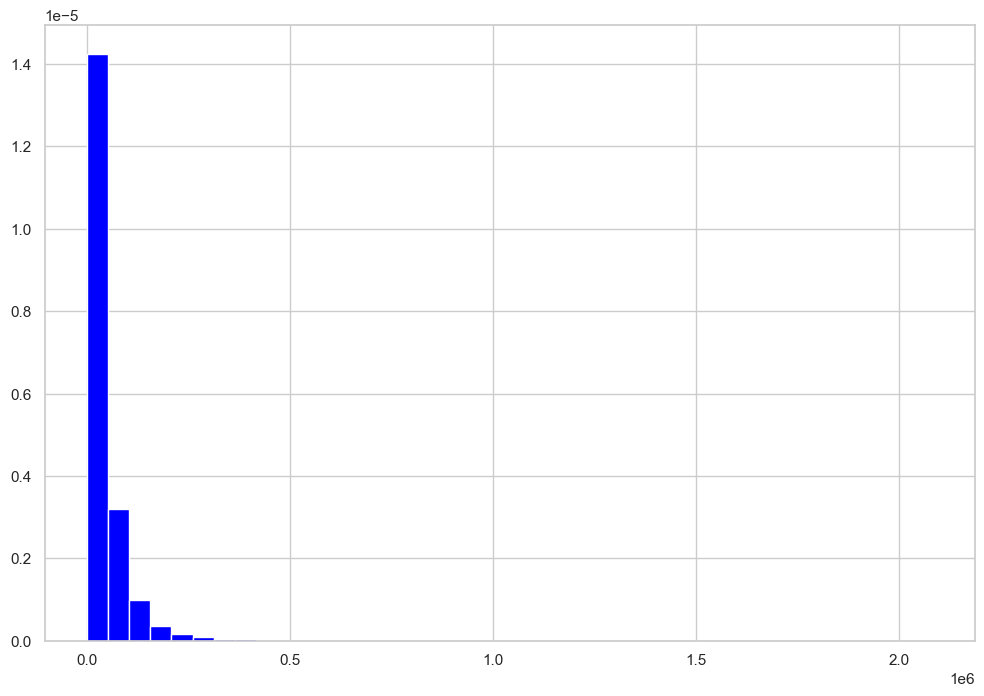

In [68]:
for col in df.columns:
    if 'INC' in col and '2' not in col:
        colname = f"{col}"
        f = df[colname].isnull()==False
        print(df.loc[f, colname].describe().round(0))
        ax = df.loc[f, colname].hist(weights=df.loc[f, 'ASECWT'], figsize=(12, 8), color='blue', bins=40, density=True)
        label = ddi_codebook.get_variable_info(col).label.title().replace("'S", "'s")
        ax.set_title(f"Distribution of {label}")
        ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
        ax.set_xlabel(f"{label}")
        ax.set_ylabel(f"Percentage of ASEC Data")
        plt.show()

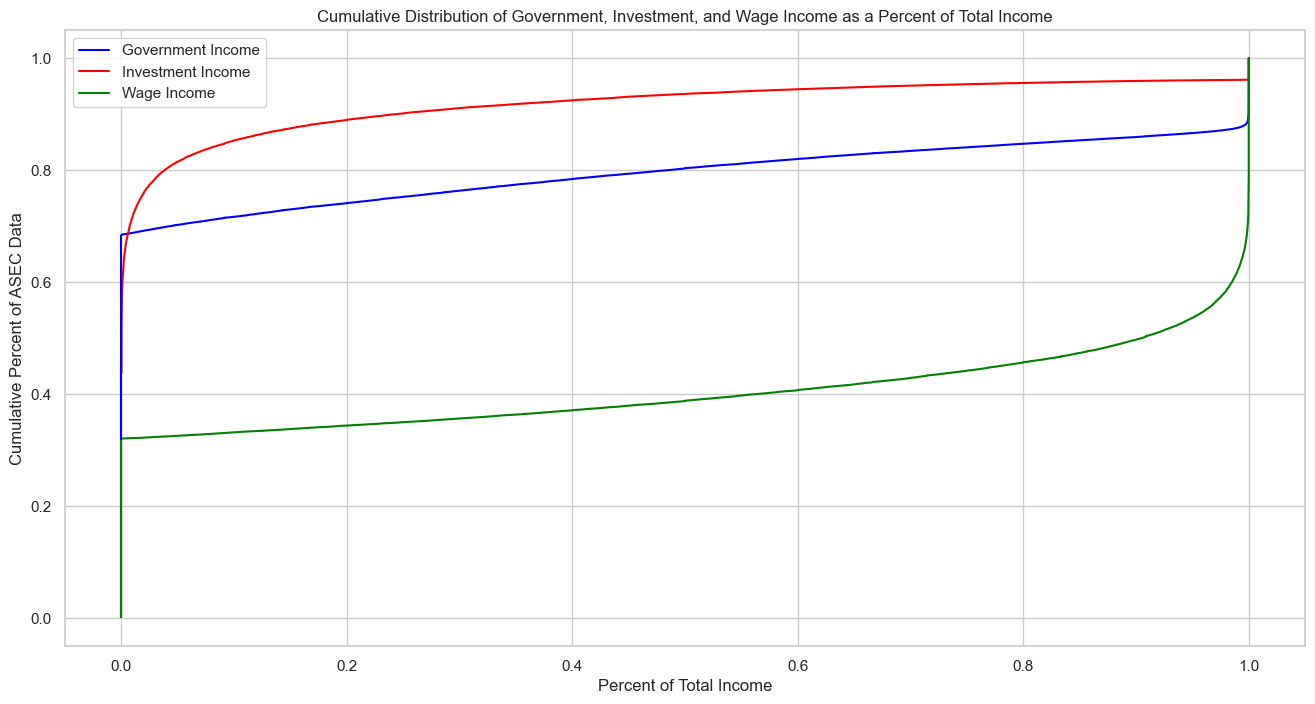

In [69]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))
x = pt(None, df, 'Government Income as Percent of Total Income', 'ASECWT')
x = x.sort_values(by='Government Income as Percent of Total Income')
x['cumulative percent'] = x['Percent'].cumsum()

x2 = pt(None, df, 'Investment Income as Percent of Total Income', 'ASECWT')
x2 = x2.sort_values(by='Investment Income as Percent of Total Income')
x2['cumulative percent'] = x2['Percent'].cumsum()

x3 = pt(None, df, 'Wage Income as Percent of Total Income', 'ASECWT')
x3 = x3.sort_values(by='Wage Income as Percent of Total Income')
x3['cumulative percent'] = x3['Percent'].cumsum()

x.plot(x='Government Income as Percent of Total Income', y='cumulative percent', ax=ax1, label='Government Income', color='blue')
x2.plot(x='Investment Income as Percent of Total Income', y='cumulative percent', ax=ax1, label='Investment Income', color='red',)
x3.plot(x='Wage Income as Percent of Total Income', y='cumulative percent', ax=ax1, label='Wage Income', color='green')
ax1.vlines(x=0, ymin=0, ymax=x2['raw_percent'].values[0], color='red')
ax1.vlines(x=0, ymin=0, ymax=x['raw_percent'].values[0]-0.006, color='blue')
ax1.vlines(x=0, ymin=0, ymax=x3['raw_percent'].values[0]-0.006, color='green')
ax1.set_ylabel('Cumulative Percent of ASEC Data')
ax1.set_xlabel('Percent of Total Income')
ax1.set_title("Cumulative Distribution of Government, Investment, and Wage Income as a Percent of Total Income")
plt.show()

In [70]:
np.average(df['Government Income'] > 0, weights=df['ASECWT'])

0.4401389710298773

In [71]:
np.average(df[df['Government Income'] > 0]['Government Income'], weights=df[df['Government Income'] > 0]['ASECWT'])

16597161.003927616

In [75]:
np.average(
    df[df['Government Income'] > 0]['Government Income as Percent of Total Income'].fillna(0), 
    weights=df[df['Government Income'] > 0]['ASECWT'],
)

0.3801281763626225

In [73]:
df['Has Government Income'] = df['Government Income'] > 0

In [74]:
pt(ddi=None, df=df, xvar='Has Government Income', wvar='ASECWT')

Has Government Income         count  raw_count  raw_percent   Percent
0                  False  1.840386e+08      83572     0.547181  0.559861
1                   True  1.446833e+08      69160     0.452819  0.440139

In [462]:
df['Has Invesment Income'] = df['Investment Income'] > 0 

In [470]:
np.average(df['Investment Income'] > 0, weights=df['ASECWT'])

0.45959411485223955

In [464]:
np.average(df['Investment Income'], weights=df['ASECWT'])

3773.9806655736957

In [76]:
tmp = df[['Has Government Income', 'Educational Attainment', 'ASECWT']]
tmp['XWEIGHT'] = df['Has Government Income'] * df['ASECWT']
x = tmp[
    ['Educational Attainment', 'XWEIGHT', 'ASECWT']
].groupby(by='Educational Attainment').agg({
    'XWEIGHT': [len, np.sum, np.mean], 
    'ASECWT': [np.sum]
}, as_index=False)

x.columns = ['_'.join([y for y in j if y != '']) for j in x.columns]
x['final'] = x['XWEIGHT_sum'] / x['ASECWT_sum']

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2159685760.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [77]:
x

XWEIGHT_len  XWEIGHT_sum  XWEIGHT_mean  \
Educational Attainment                                                      
Bachelor's degree                        24438  14782651.89    604.904325   
Graduate degree                          14545   8880631.72    610.562511   
High school diploma or equivalent        58755  48017391.74    817.247753   
Less than High School Diploma            18478   9413016.69    509.417507   
Missing                                  31613  59998514.81   1897.906393   
Vocational Degree                         4903   3591103.78    732.429896   

                                     ASECWT_sum     final  
Educational Attainment                                     
Bachelor's degree                  5.640483e+07  0.262081  
Graduate degree                    3.250910e+07  0.273174  
High school diploma or equivalent  1.318132e+08  0.364284  
Less than High School Diploma      3.733442e+07  0.252127  
Missing                            5.999851e+07  1.000000  
Vocational Degree                  1.066183e+07  0.336819

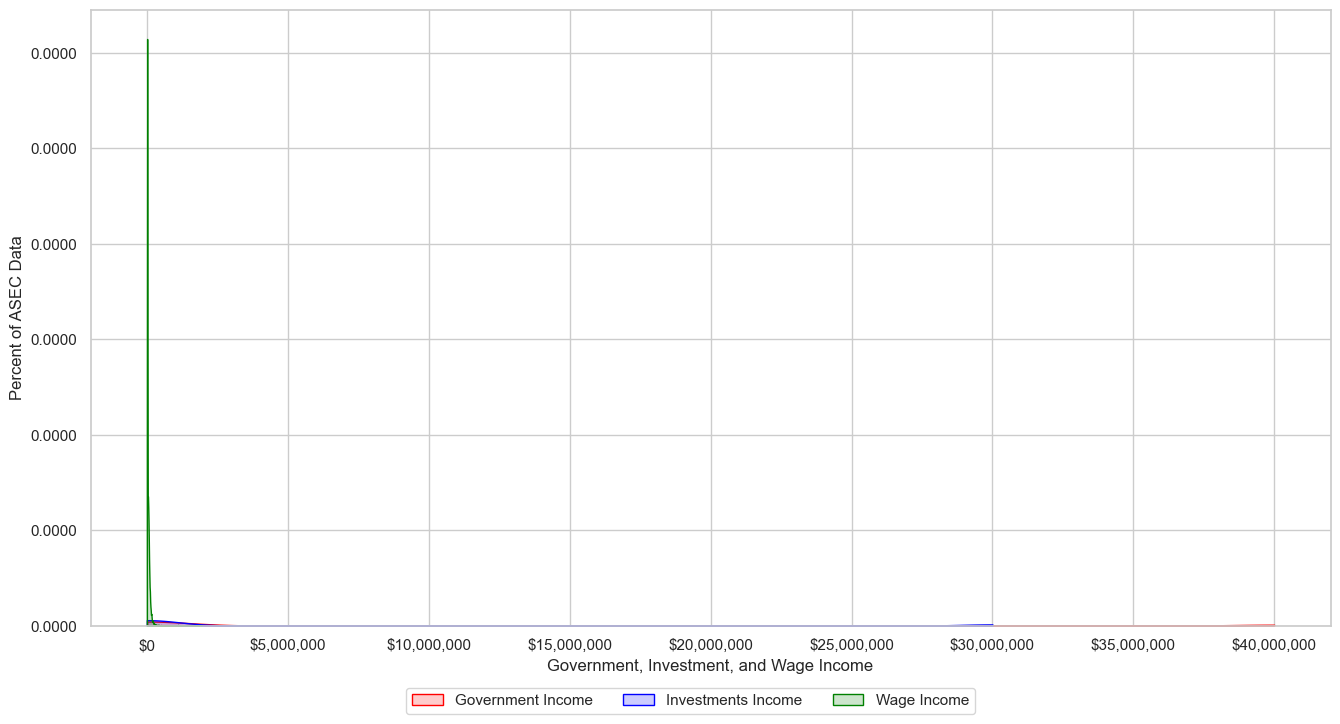

In [78]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))
sns.kdeplot(
    data=df,
    x='Government Income',
    weights='ASECWT',
    color='red',
    ax=ax1,
    cut=0, 
    fill=True, 
    common_norm=False, 
    alpha=0.2, 
    
)
sns.kdeplot(
    data=df,
    x='Investment Income',
    weights='ASECWT',
    color='blue',
    ax=ax1,
    cut=0, 
    fill=True, 
    common_norm=False, 
    alpha=0.2, 
)
sns.kdeplot(
    data=df,
    x='Wage Income',
    weights='ASECWT',
    color='green',
    ax=ax1,
    cut=0, 
    fill=True, 
    common_norm=False, 
    alpha=0.2, 
)
ax1.set_xlabel(f"Government, Investment, and Wage Income")
ax1.set_ylabel(f"Percent of ASEC Data")
ax1.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.4f}'))
ax1.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
fig.legend(labels=['Government Income', 'Investments Income', 'Wage Income'], loc='lower center', bbox_to_anchor=(0.5, -0.01), ncol=3)

In [79]:
df['Educational Attainment'].value_counts(False)

High school diploma or equivalent    58755
Missing                              31613
Bachelor's degree                    24438
Less than High School Diploma        18478
Graduate degree                      14545
Vocational Degree                     4903
Name: Educational Attainment, dtype: int64

In [80]:
def den_plot_by_x(
    xdf,
    groupbyvar,
    xvar,
    wvar,
    k=None,
    bbox=(0.5, -0.1),
    legend_ncol=3,
    max_percentile=1.,
    addvline=False,
    den_title=None,
):
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 8))
    if k is not None:
        sdf = xdf[groupbyvar].value_counts()
        top_k = sdf[0:(k-1)].index.tolist()
        xdfss = xdf[xdf.eval(f'{groupbyvar} == "' + f'" | {groupbyvar} == "'.join(top_k) + '"')].reset_index(drop=True)
        print(f'reducing records from {xdf.shape[0]} to {xdfss.shape[0]}')
        print(f"reducing groups from {xdf[groupbyvar].nunique()} to {k}")
    else:
        xdfss = xdf
    
    if den_title is None:
        den_title = f'Estimated Density Function of Total Income by {groupbyvar}'
    max_percentile_value = xdfss[xvar].quantile(max_percentile)
    xdfss = xdfss[xdfss[xvar] < max_percentile_value]
    groups = xdfss[groupbyvar].unique().tolist()
    pal = sns.color_palette("bright", len(groups))
    
    if addvline:    
        tmp = xdfss[[xvar, groupbyvar, wvar]]
        tmp['XWEIGHT'] = xdfss[xvar] * xdfss[wvar]
        x = tmp[
            [groupbyvar, 'XWEIGHT', wvar]
        ].groupby(by=groupbyvar).agg({
            'XWEIGHT': [len, np.sum, np.mean], 
            wvar: [np.sum]
        }, as_index=False)
        x.columns = ['_'.join([y for y in j if y != '']) for j in x.columns]
        x['final'] = x['XWEIGHT_sum'] / x[f'{wvar}_sum']

    test = sns.kdeplot(
        data=xdfss,
        weights=wvar, 
        x=xvar, 
        hue=groupbyvar, 
        hue_order=x.index.tolist(),
        cut=0, fill=True, 
        common_norm=False, 
        alpha=0.2, 
        # ax=ax1,
        palette=pal,
    ).set(title=den_title)

    try:
        label = ddi_codebook.get_variable_info(xvar.replace("_2", "")).label.title().replace("'S", "'s")
    except:
        label = xvar
    
    ax1.set_xlabel(f"{label}")
    ax1.set_ylabel(f"Percent of ASEC Data")
    ax1.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.5f}'))
    ax1.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
    if addvline:
        display(x[['final']].rename({"final": xvar}, axis=1))
        for i, xval in enumerate(x['final']):
            ax1.axvline(x = xval,
               ymin = 0, color=pal[i],
               ymax = 1, linestyle='--')
    fig.show()

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:42: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



Wage Income
Age Bucket              
15-24       11122.309256
25-54       48509.528553
55-64       42564.086663
65+         16129.680872
<15             0.000000

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:70: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



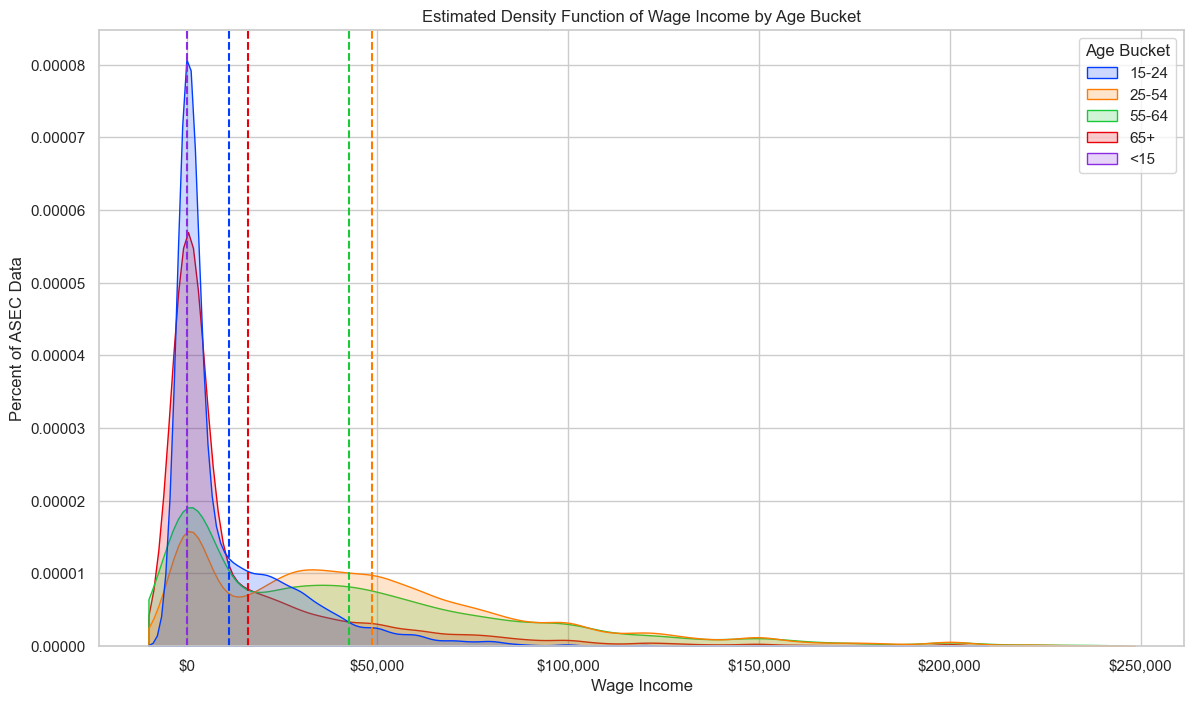

In [81]:
den_plot_by_x(
    df, 
    'Age Bucket',
    'Wage Income', 
    'ASECWT', 
    k=None, bbox=(0.5, -0.01), 
    legend_ncol=10,
    max_percentile=.99, 
    addvline=True, 
    den_title='Estimated Density Function of Wage Income by Age Bucket',
)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Investment Income
Age Bucket                   
15-24              130.885544
25-54             2894.563786
55-64             7366.767290
65+               9934.928430

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:70: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



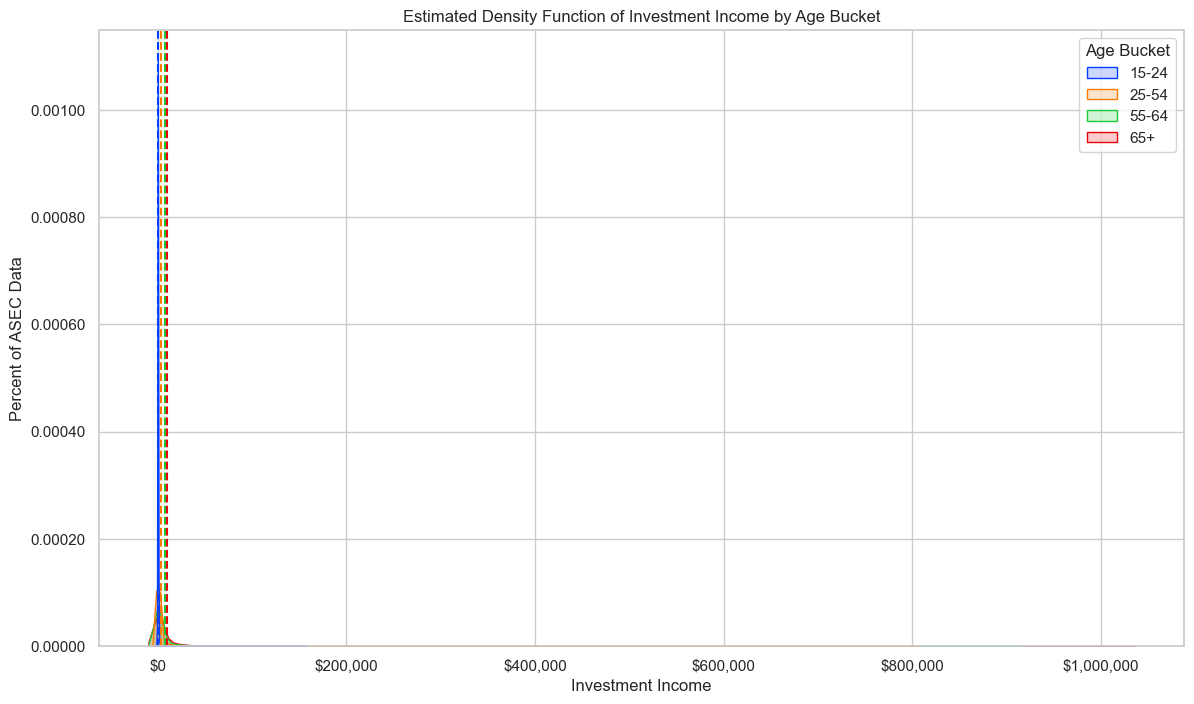

In [82]:
den_plot_by_x(
    df, 
    'Age Bucket',
    'Investment Income', 
    'ASECWT', 
    k=None, bbox=(0.5, -0.01), 
    legend_ncol=10,
    max_percentile=.99, 
    addvline=True, 
    den_title='Estimated Density Function of Investment Income by Age Bucket',
)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Government Income
Age Bucket                   
15-24             1659.024699
25-54             1989.666337
55-64             3934.788187
65+              16033.656384

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:70: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



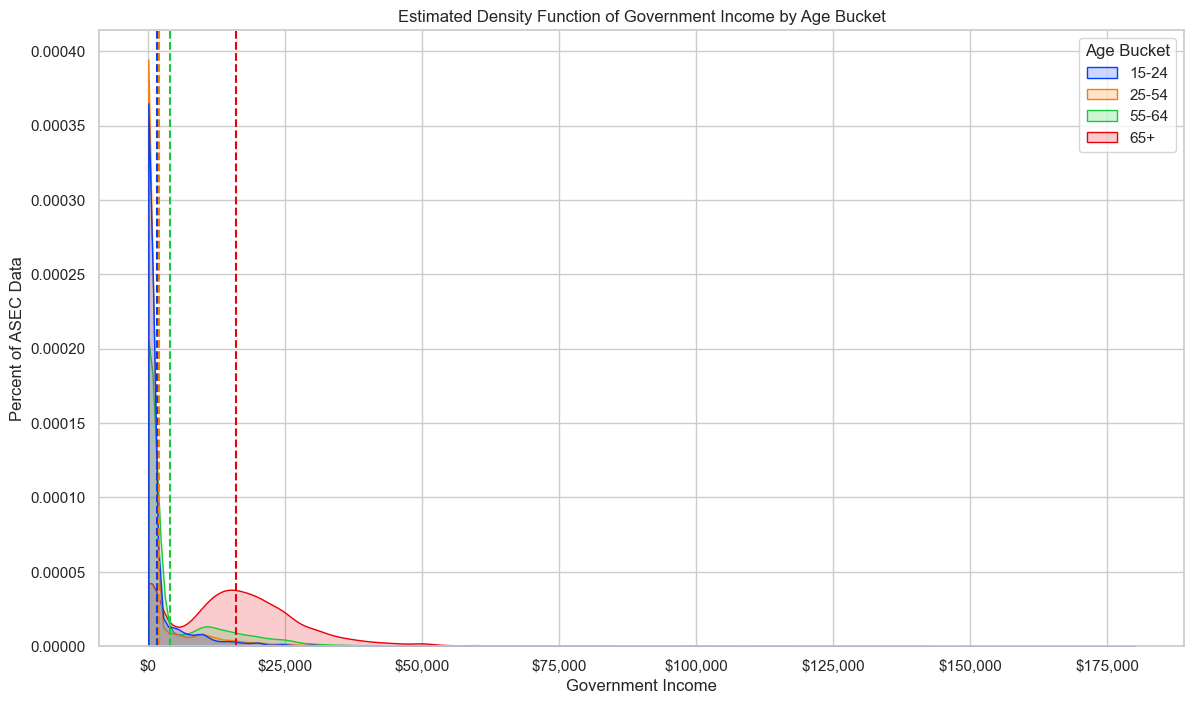

In [83]:
den_plot_by_x(
    df, 
    'Age Bucket',
    'Government Income', 
    'ASECWT', 
    k=None, bbox=(0.5, -0.01), 
    legend_ncol=10,
    max_percentile=.99, 
    addvline=True, 
    den_title='Estimated Density Function of Government Income by Age Bucket',
)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



INCTOT
Age Bucket              
15-24       12999.194205
25-54       54708.169978
55-64       53581.074750
65+         40972.554838

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:70: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



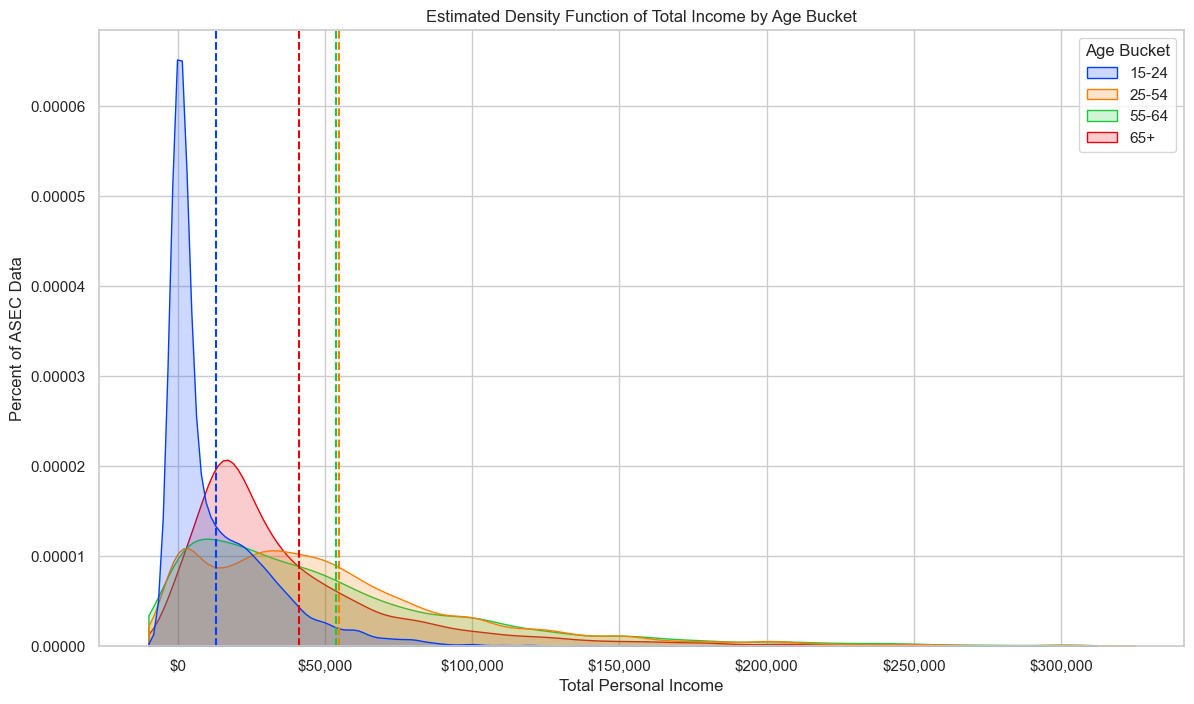

In [88]:
den_plot_by_x(
    df, 
    'Age Bucket',
    'INCTOT', 
    'ASECWT', 
    k=None, bbox=(0.5, -0.01), 
    legend_ncol=10,
    max_percentile=.99, 
    addvline=True, 
    den_title='Estimated Density Function of Total Income by Age Bucket',
)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Government Income
Educational Attainment                              
Bachelor's degree                        4078.962309
Graduate degree                          4763.967587
High school diploma or equivalent        5087.004586
Less than High School Diploma            3073.145057
Vocational Degree                        4870.073643

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:70: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



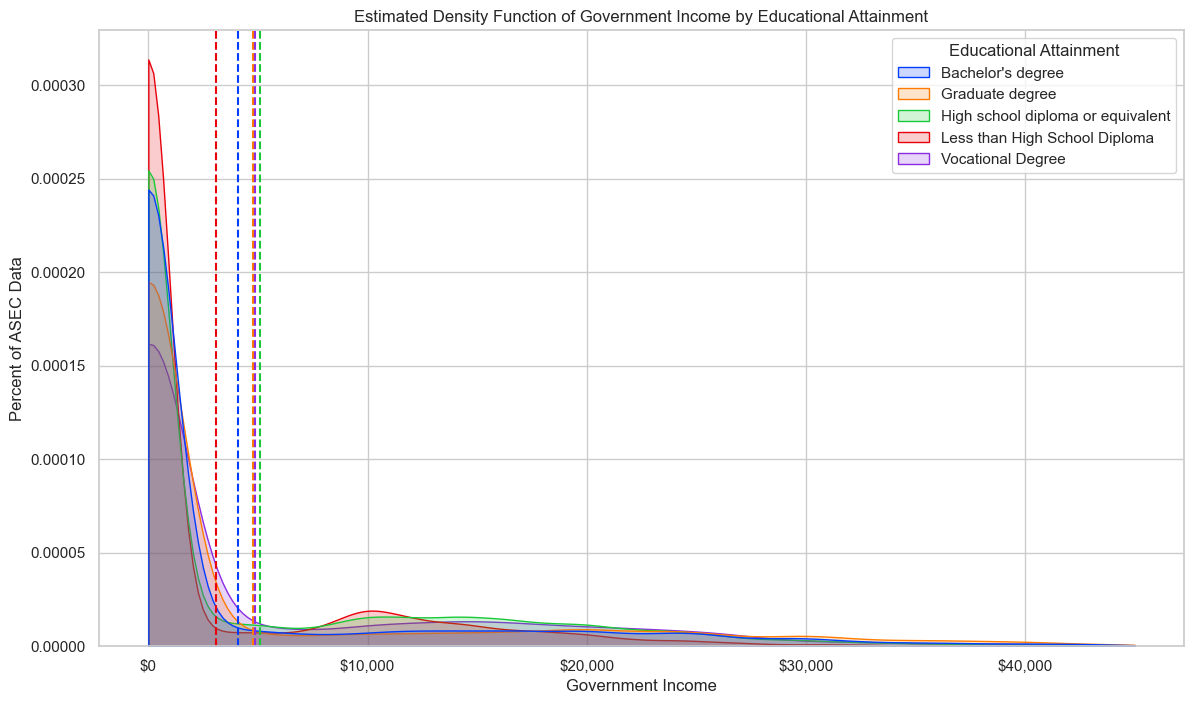

In [89]:
den_plot_by_x(
    df[df['Educational Attainment']!='Missing'], 
    'Educational Attainment',
    'Government Income', 
    'ASECWT', 
    k=None, bbox=(0.5, -0.01), 
    legend_ncol=10,
    max_percentile=.99, 
    addvline=True, 
    den_title='Estimated Density Function of Government Income by Educational Attainment',
)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Investment Income
Educational Attainment                              
Bachelor's degree                        5082.280930
Graduate degree                          7241.475003
High school diploma or equivalent        1831.341547
Less than High School Diploma             326.880658
Vocational Degree                        2495.619765

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:70: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



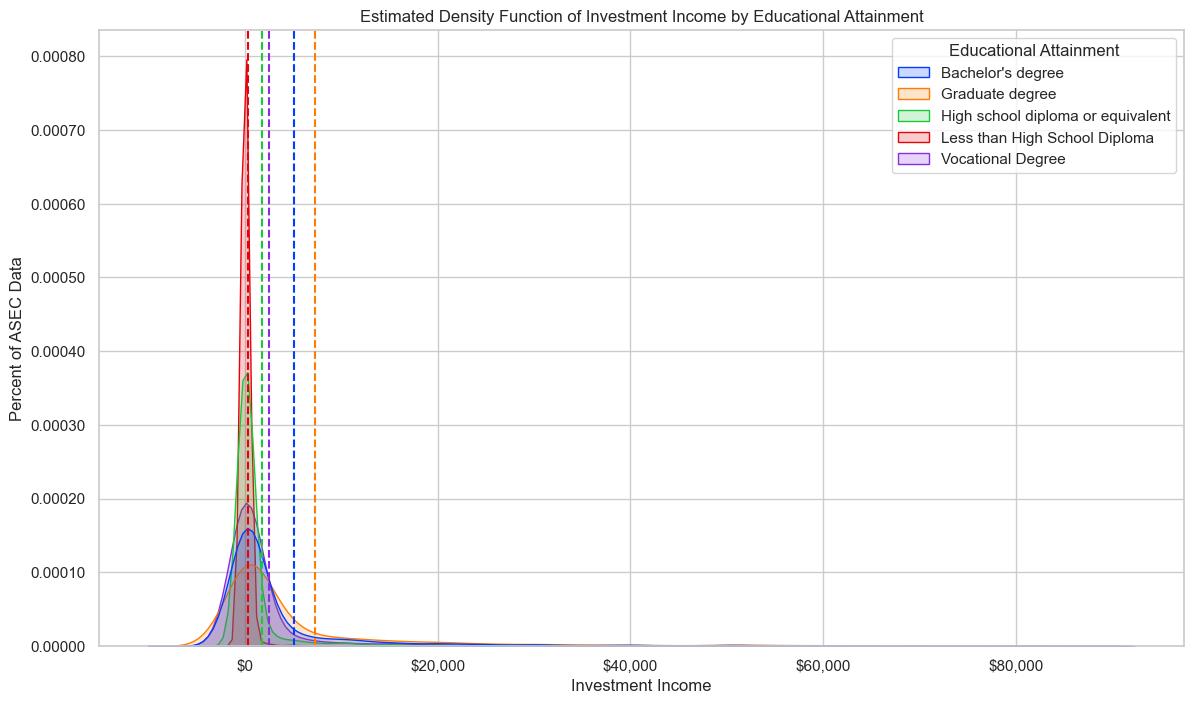

In [90]:
den_plot_by_x(
    df[df['Educational Attainment']!='Missing'], 
    'Educational Attainment',
    'Investment Income', 
    'ASECWT', 
    k=None, bbox=(0.5, -0.01), 
    legend_ncol=10,
    max_percentile=.99, 
    addvline=True, 
    den_title='Estimated Density Function of Investment Income by Educational Attainment',
)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Wage Income
Educational Attainment                         
Bachelor's degree                  61703.385126
Graduate degree                    87413.028697
High school diploma or equivalent  28626.982048
Less than High School Diploma       9887.130759
Vocational Degree                  38084.893385

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:70: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



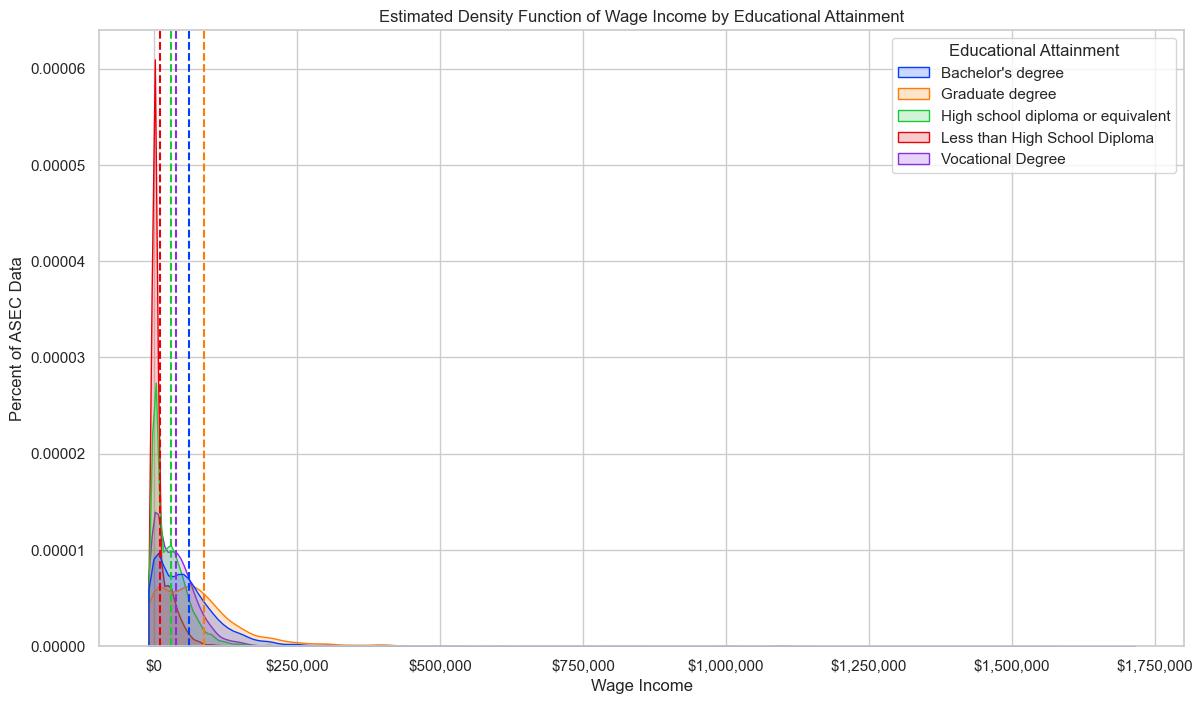

In [91]:
den_plot_by_x(
    df[df['Educational Attainment']!='Missing'], 
    'Educational Attainment',
    'Wage Income', 
    'ASECWT', 
    k=None, bbox=(0.5, -0.01), 
    legend_ncol=10,
    max_percentile=1., 
    addvline=True, 
    den_title='Estimated Density Function of Wage Income by Educational Attainment',
)

KeyError: 'INCTOT_2'

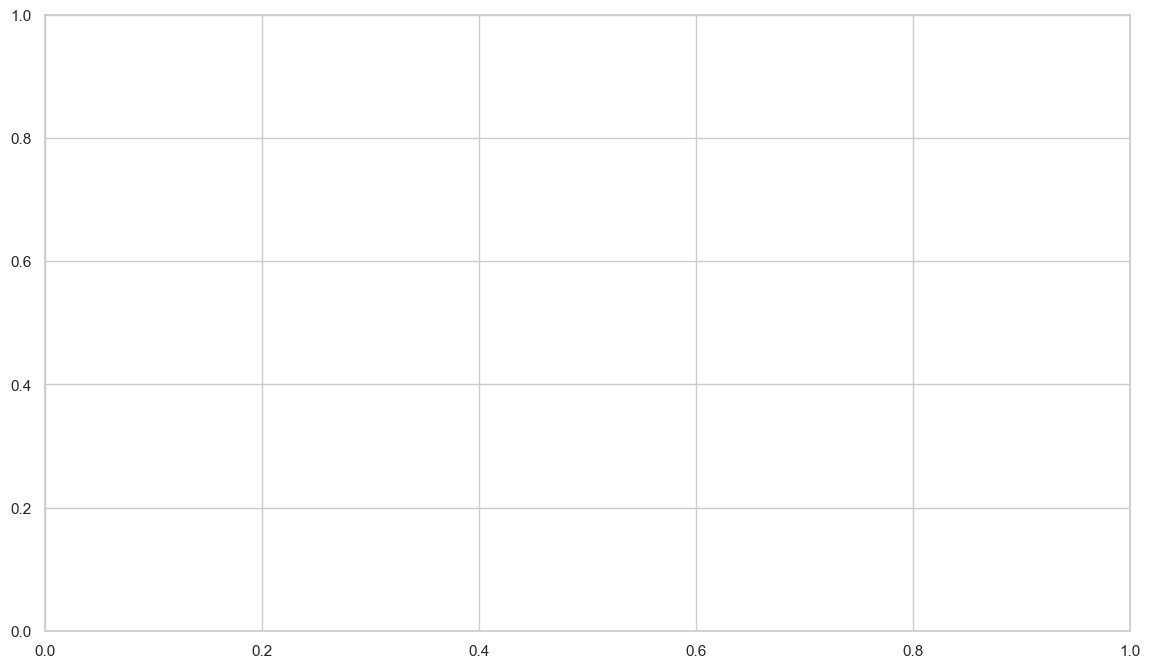

In [92]:
den_plot_by_x(df[df['Educational Attainment']!='Missing'], 
              'Educational Attainment', 
              'INCTOT_2', 'ASECWT', 
k=None, bbox=(0.5, -0.01), legend_ncol=10, max_percentile=0.99, addvline=True)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



INCTOT
Educational Attainment                          
Bachelor's degree                   80312.732940
Graduate degree                    105934.037183
High school diploma or equivalent   46359.228608
Less than High School Diploma       25755.238572
Vocational Degree                   55799.883486

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:70: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



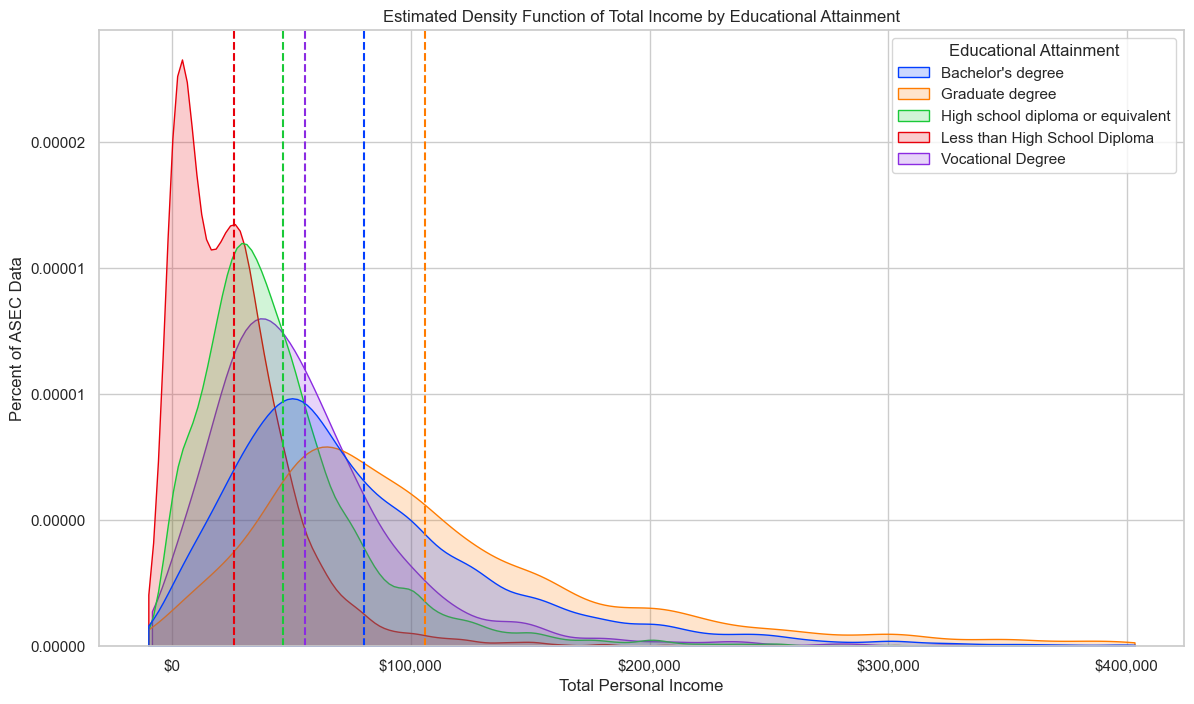

In [93]:
den_plot_by_x(df[df['LABFORCE']==2], 'Educational Attainment', 'INCTOT', 'ASECWT', 
                  k=None, bbox=(0.5, -0.01), legend_ncol=10, max_percentile=0.99, addvline=True)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



INCTOT
Class_of_worker                              
Federal government employee      87669.291991
Local government employee        63621.642520
NIU                               4277.086577
Self-employed, incorporated      91659.093360
Self-employed, not incorporated  51116.360821
State government employee        65609.792527
Unpaid family worker             15435.825097
Wage/salary, private             60603.051702

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:70: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



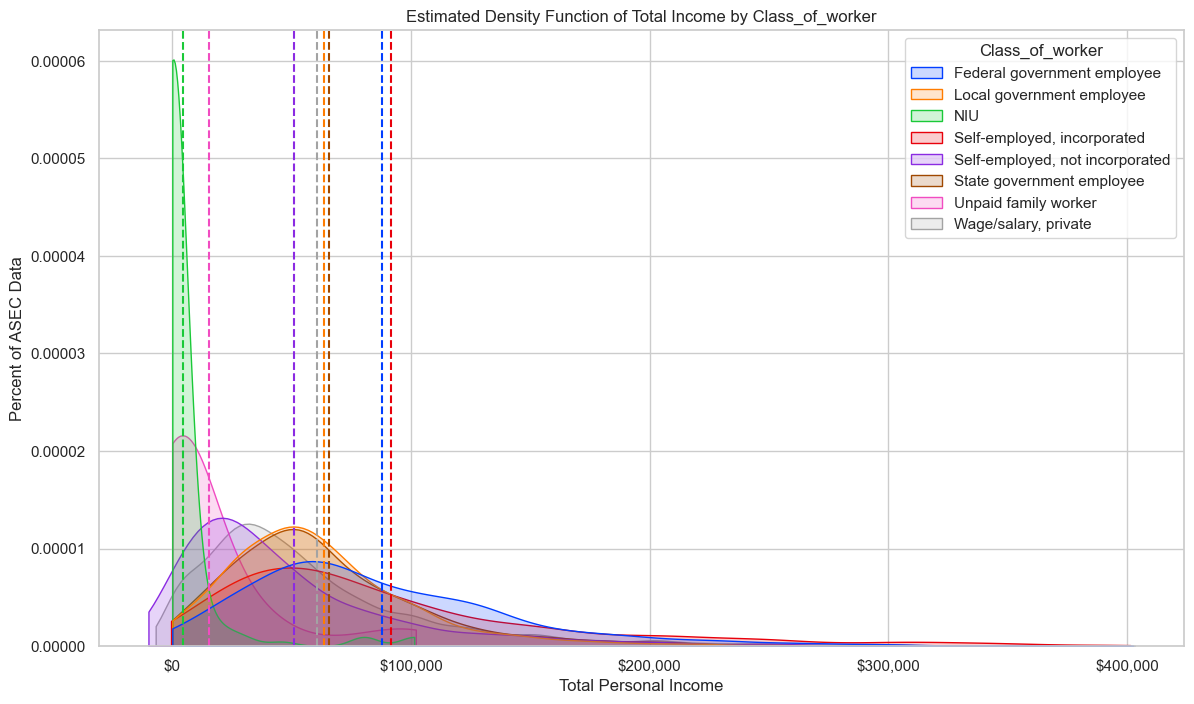

In [94]:
den_plot_by_x(df[df['LABFORCE']==2], 'Class_of_worker', 'INCTOT', 'ASECWT', 
                  k=None, bbox=(0.5, -0.04), legend_ncol=4, max_percentile=0.99, addvline=True)

reducing records from 73863 to 71682
reducing groups from 26 to 5


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



INCTOT
Race                                      
American Indian/Aleut/Eskimo  42603.081472
Asian only                    76507.130368
Black                         49329.397855
White                         63716.517622

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/2986280503.py:70: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



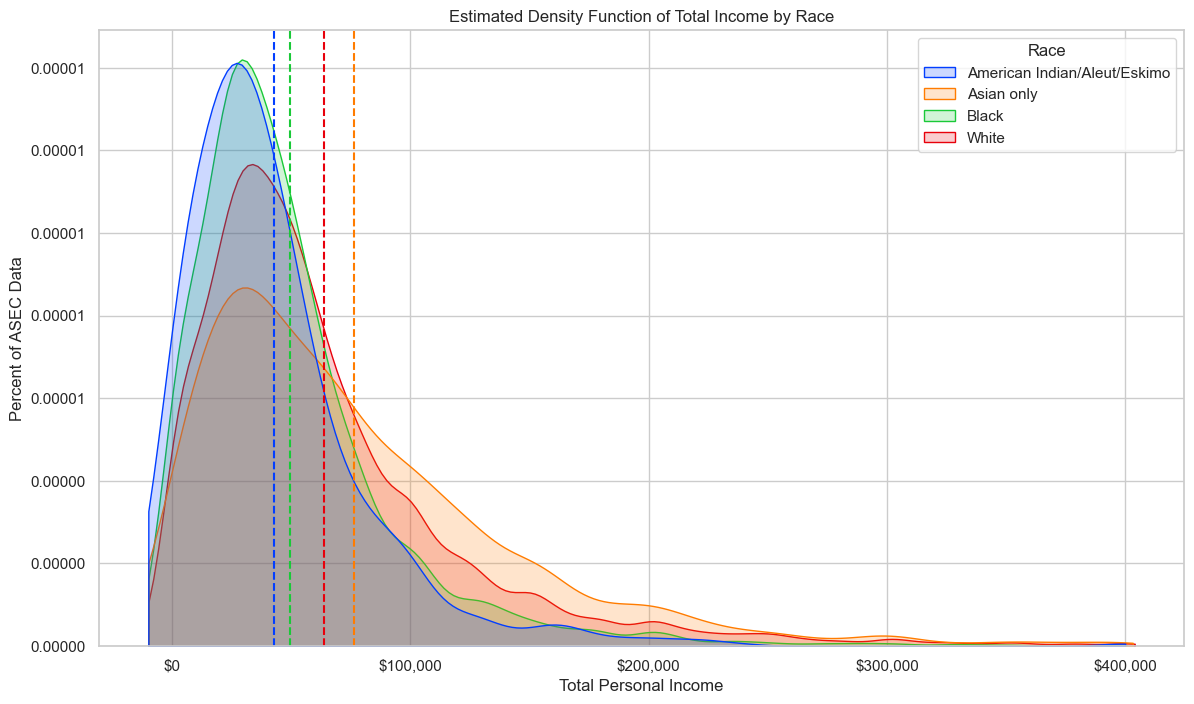

In [96]:
den_plot_by_x(df[df['LABFORCE']==2], 'Race', 'INCTOT', 'ASECWT', 
                  k=5, bbox=(0.5, -0.04), legend_ncol=4, max_percentile=0.99, addvline=True)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/3067462159.py:41: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



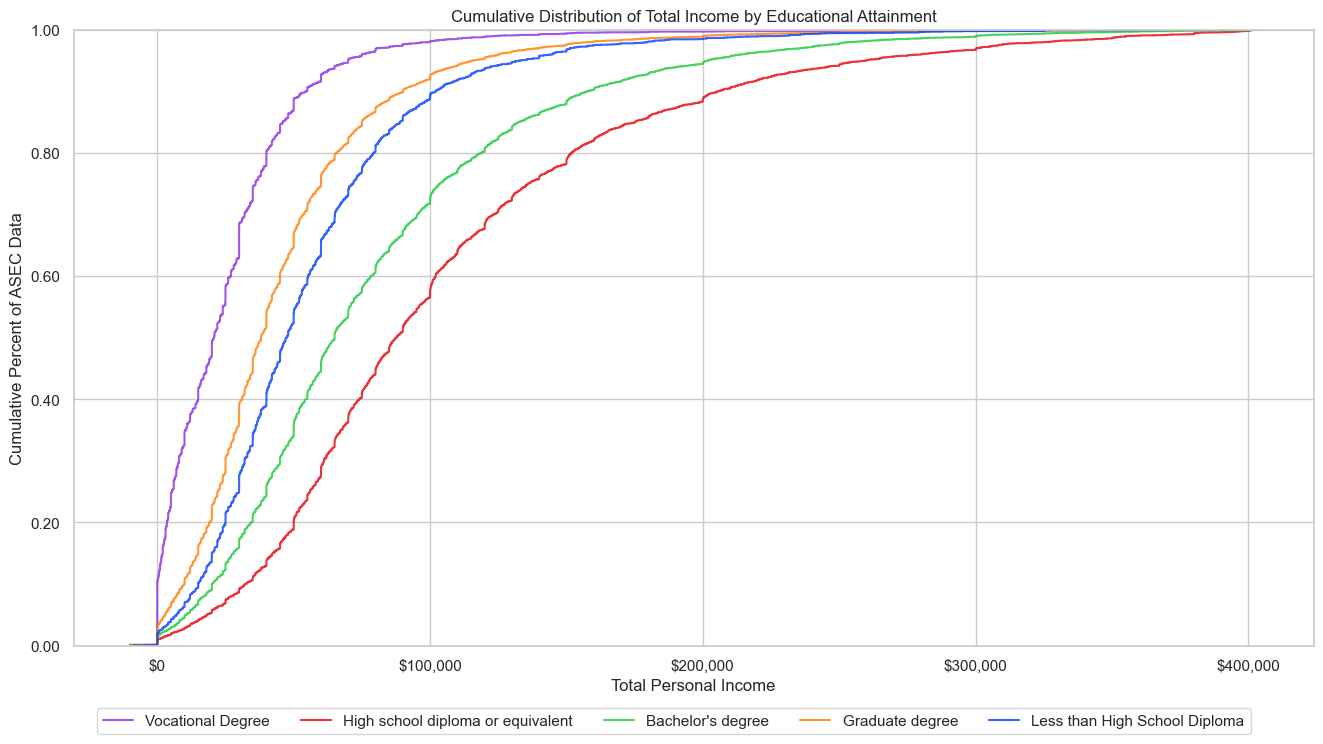

In [97]:
cdf_plot_by_x(df[df['LABFORCE']==2], 'Educational Attainment', 'INCTOT', 'ASECWT', 
                  k=None, bbox=(0.5, -0.01), legend_ncol=10, max_percentile=0.99)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/3067462159.py:108: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



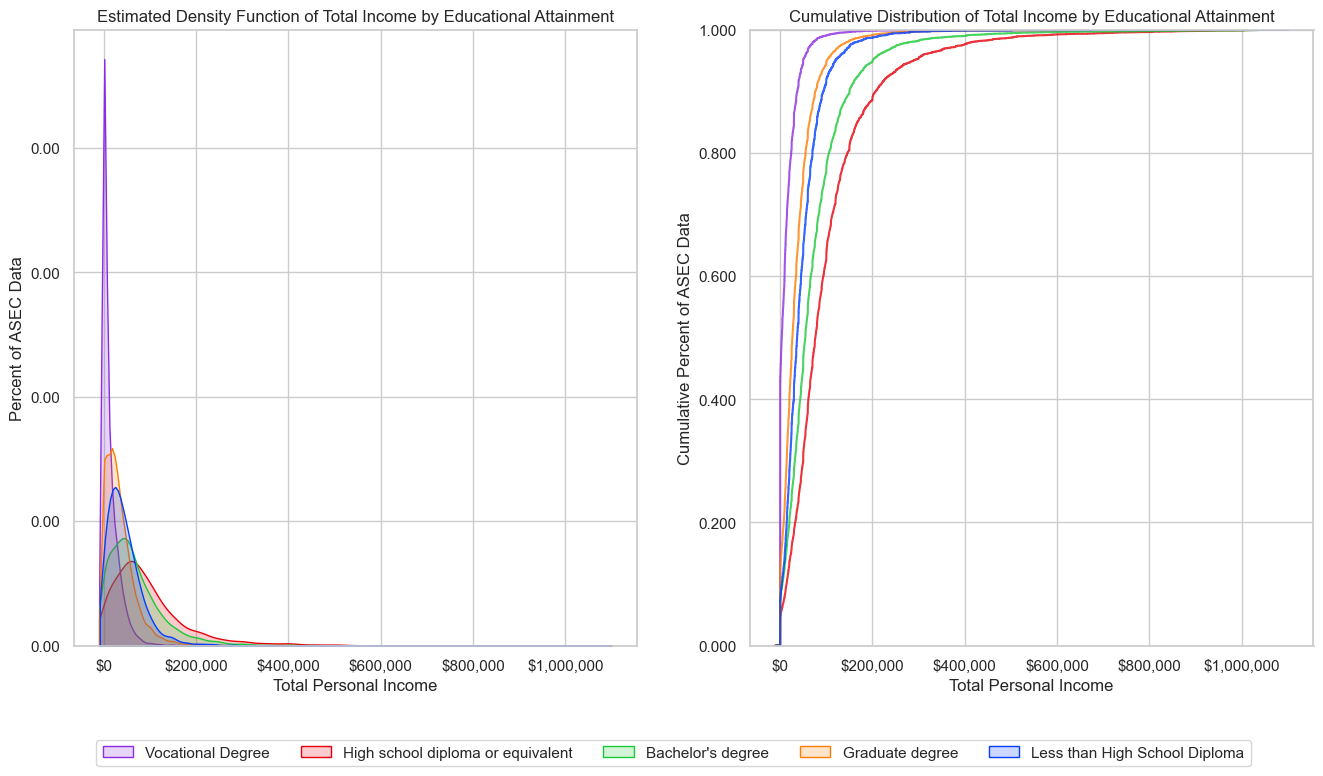

In [98]:
den_cdf_plot_by_x(df, 'Educational Attainment', 'INCTOT', 'ASECWT', 
                  k=None, bbox=(0.5, -0.05), legend_ncol=10, max_percentile=0.999)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/3067462159.py:108: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



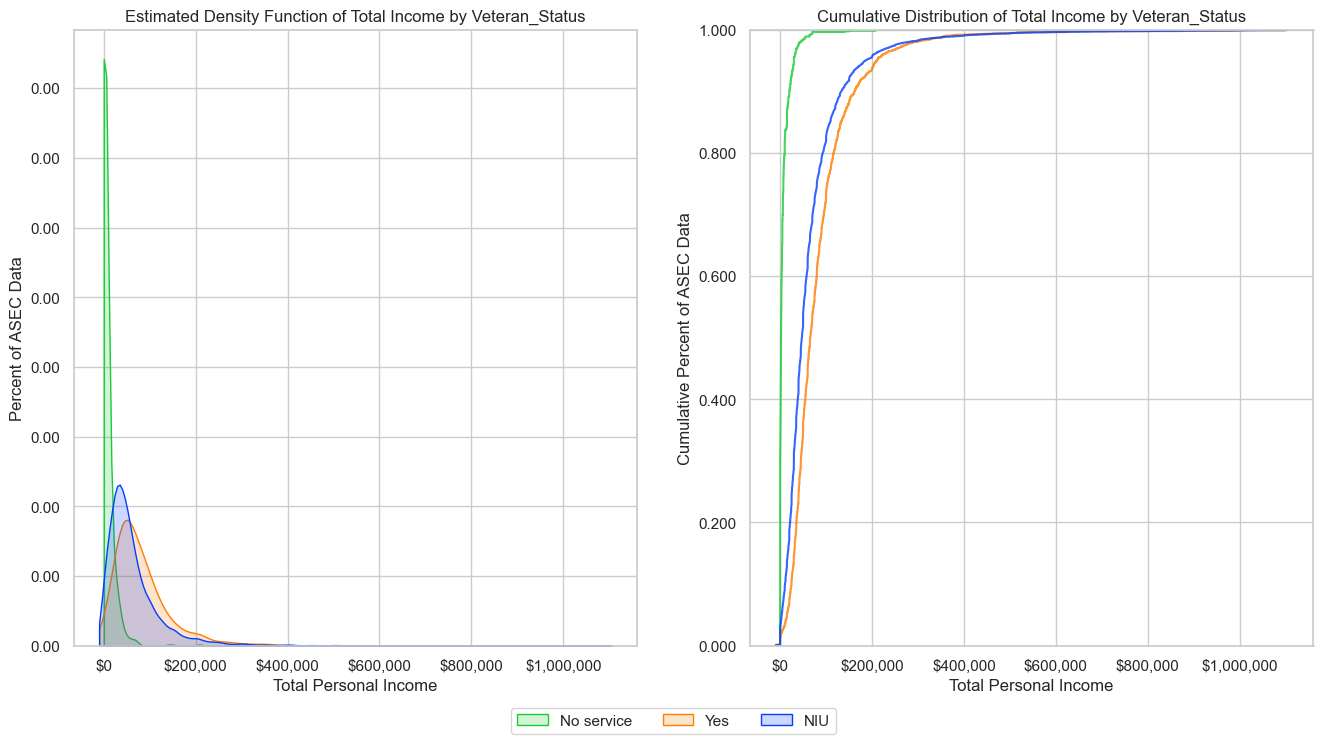

In [99]:
den_cdf_plot_by_x(
    df[df['LABFORCE']==2], 'Veteran_Status', 'INCTOT', 'ASECWT', 
    k=None, bbox=(0.5, -0.01), legend_ncol=5, 
    max_percentile=0.999,
)

reducing records from 73863 to 72717
reducing groups from 8 to 6


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/3067462159.py:108: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



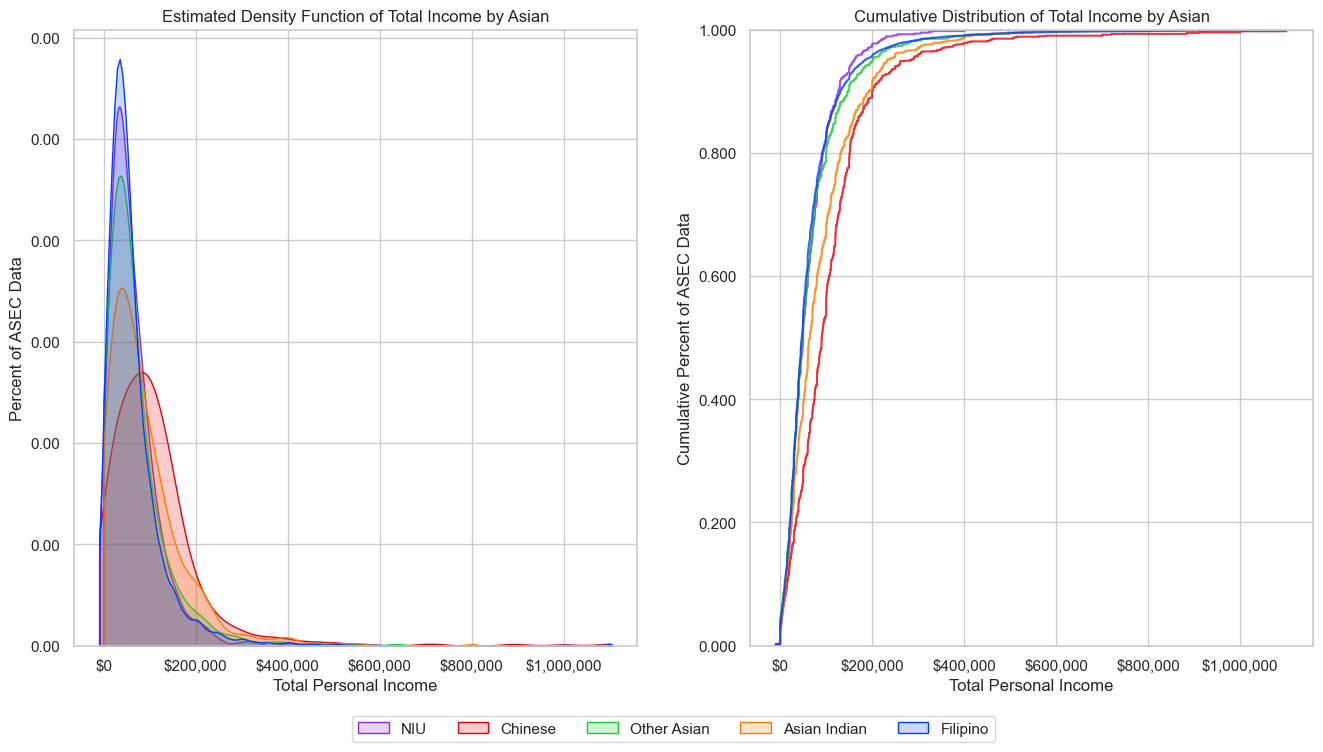

In [100]:
den_cdf_plot_by_x(
    df[df['LABFORCE']==2], 'Asian', 'INCTOT', 'ASECWT', k=6, 
    bbox=(0.5, -0.02), legend_ncol=10, max_percentile=0.999,
)

reducing records from 73863 to 71418
reducing groups from 9 to 6


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/3067462159.py:108: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



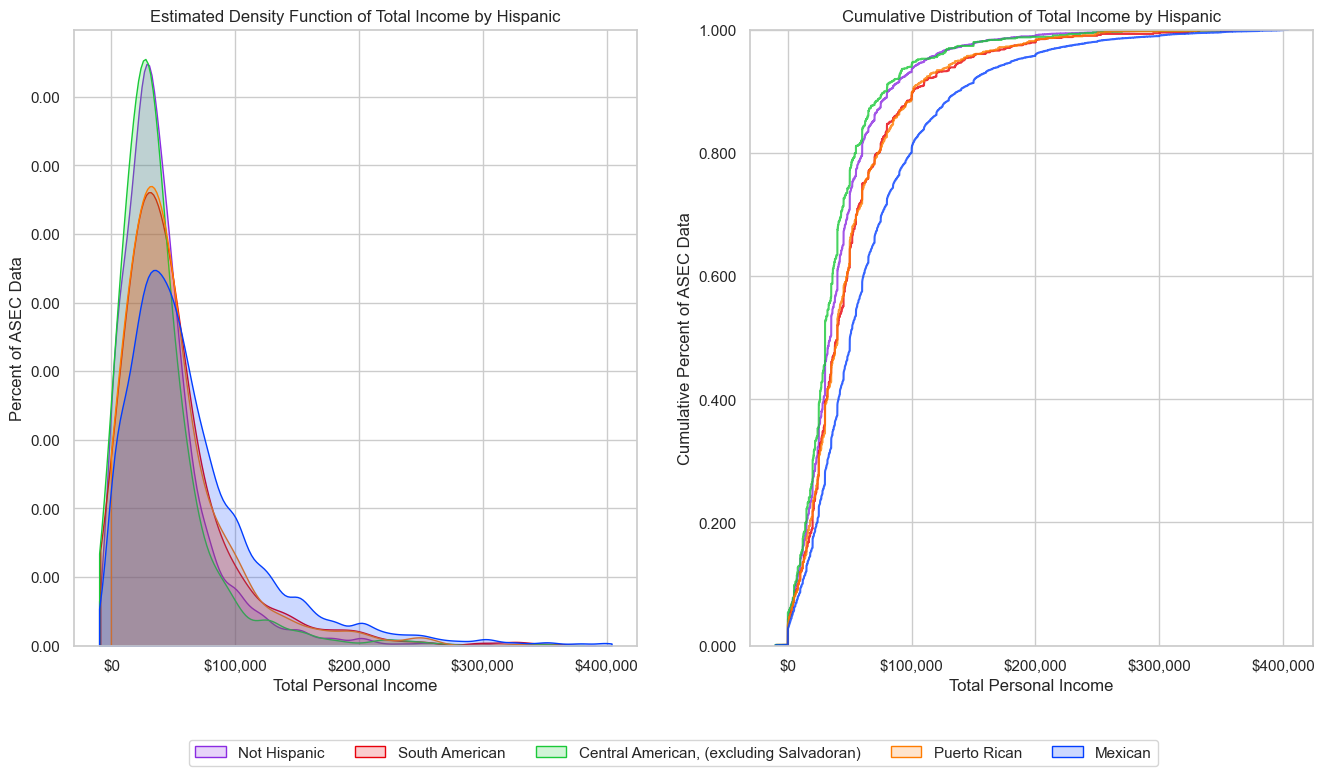

In [101]:
den_cdf_plot_by_x(
    df[df['LABFORCE']==2], 'Hispanic', 'INCTOT', 'ASECWT', 
    k=6, bbox=(0.5, -0.05), legend_ncol=5, 
    max_percentile=0.99,
)

reducing records from 73863 to 71486
reducing groups from 8 to 6


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/3067462159.py:108: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



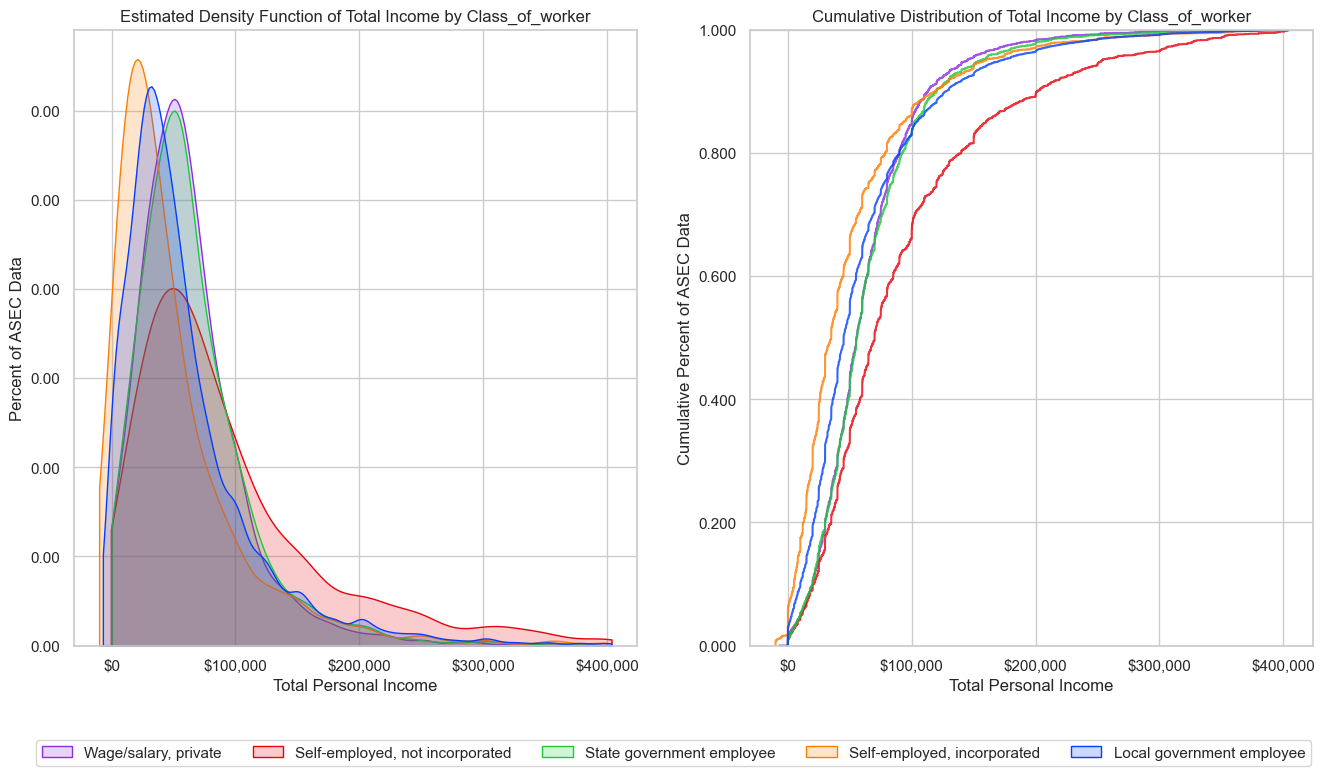

In [102]:
den_cdf_plot_by_x(df[df['LABFORCE']==2], 'Class_of_worker', 'INCTOT', 'ASECWT', k=6, bbox=(0.5, -0.05), legend_ncol=5, max_percentile=0.99)

reducing records from 73863 to 72772
reducing groups from 6 to 6


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/3067462159.py:108: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



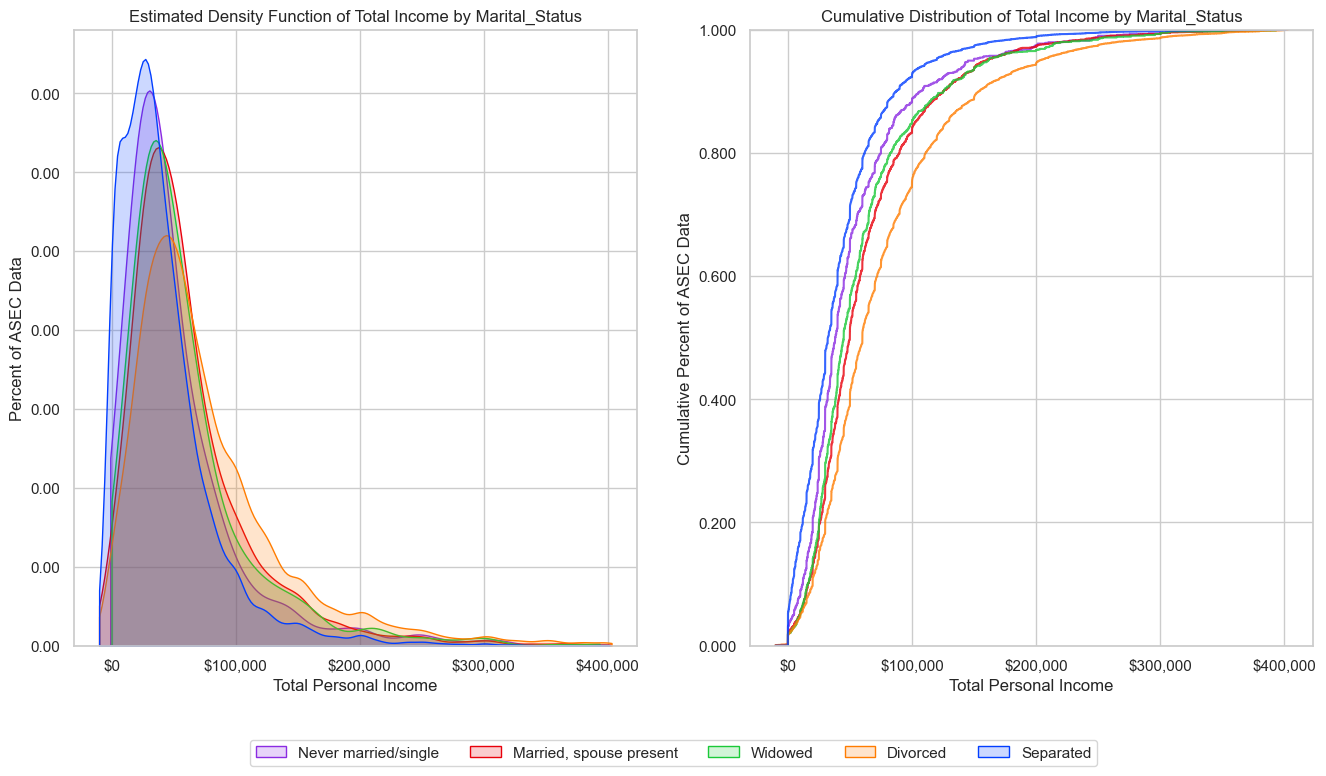

In [103]:
den_cdf_plot_by_x(
    df[df['LABFORCE']==2], 'Marital_Status', 'INCTOT', 'ASECWT', k=6, bbox=(0.5, -0.05), 
    legend_ncol=5, max_percentile=0.99
)

reducing records from 73863 to 67317
reducing groups from 160 to 10


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/3067462159.py:108: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



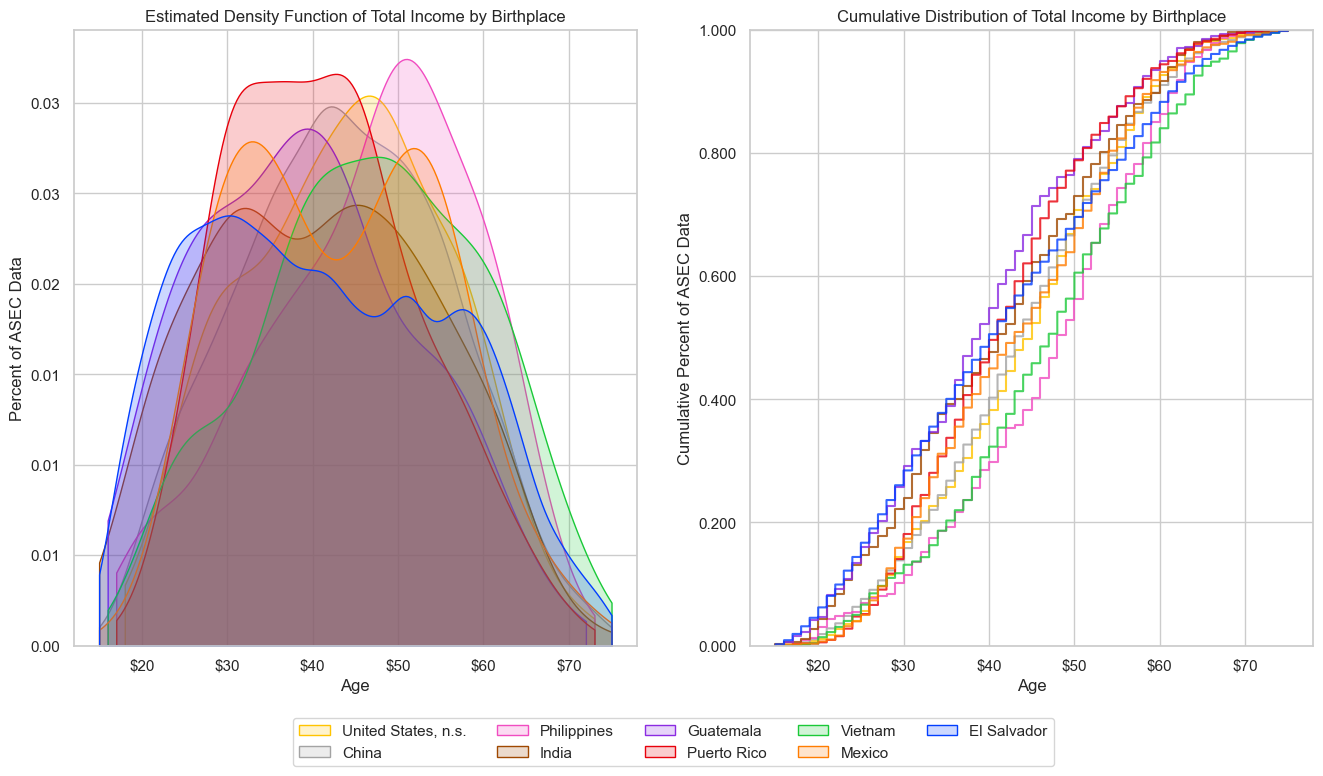

In [104]:
den_cdf_plot_by_x(df[df['LABFORCE']==2], 'Birthplace', 'Age', 'ASECWT', k=10, bbox=(0.5, -0.05), legend_ncol=5, max_percentile=0.99)

reducing records from 73863 to 67317
reducing groups from 160 to 10


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/3067462159.py:108: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



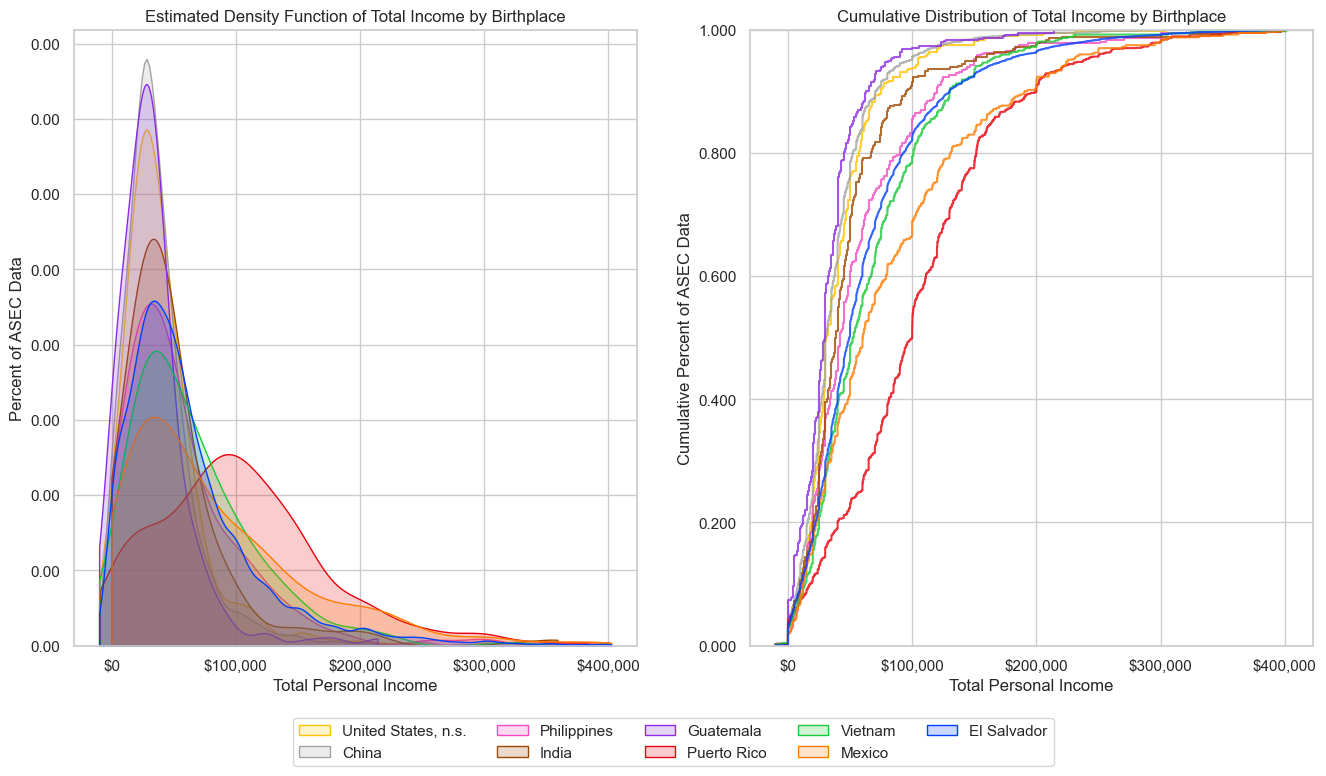

In [105]:
den_cdf_plot_by_x(df[df['LABFORCE']==2], 'Birthplace', 'INCTOT', 'ASECWT', k=10, bbox=(0.5, -0.05), legend_ncol=5, max_percentile=0.99)

reducing records from 73863 to 71682
reducing groups from 26 to 5


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_92091/3067462159.py:108: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



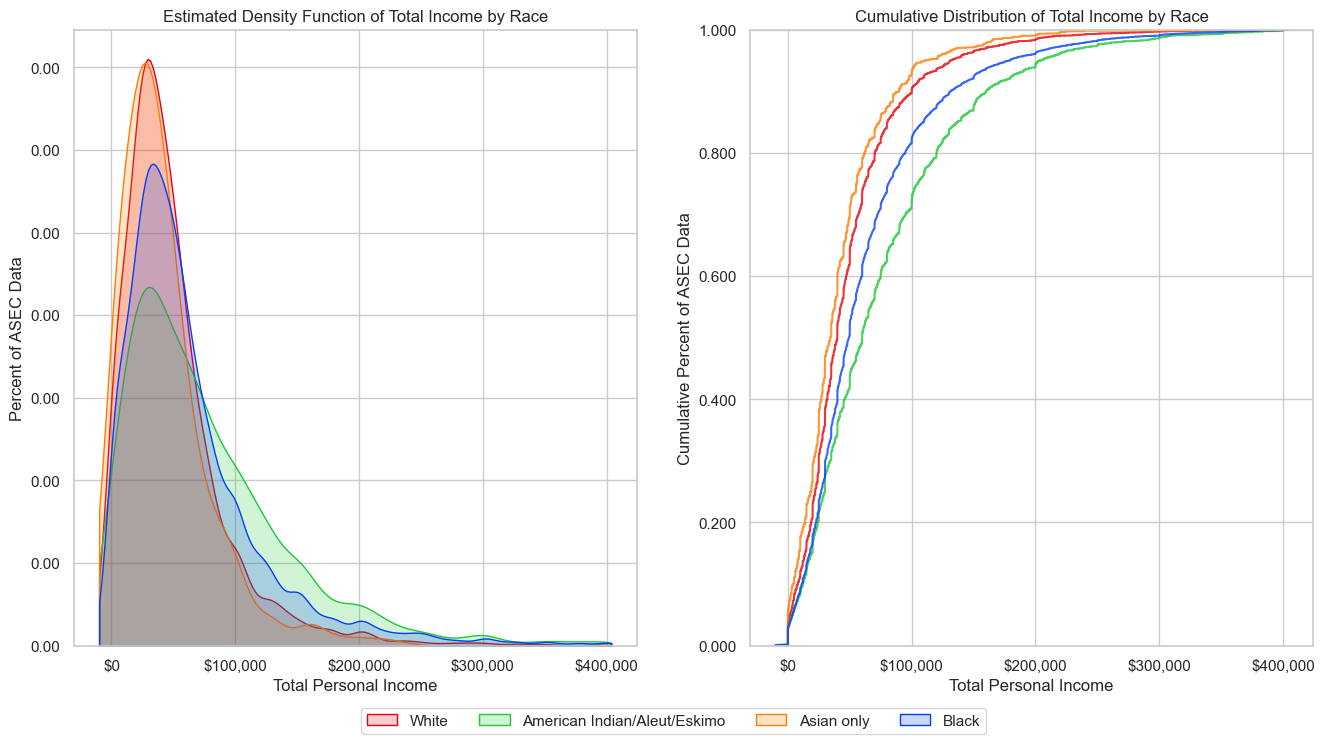

In [109]:
den_cdf_plot_by_x(df[df['LABFORCE']==2], 'Race', 'INCTOT', 'ASECWT', k=5, bbox=(0.5, -0.01), legend_ncol=5, max_percentile=0.99)

# Inheritance

In [433]:
inheritence = pd.read_html("https://budgetmodel.wharton.upenn.edu/issues/2021/7/16/inheritances-by-age-and-income-group")
idf = inheritence[0]
idff = pd.DataFrame(idf[['Income','All Ages']].values[0:-1], columns=['Income Percentile', 'Median Inheritance'])
idff['Median Inheritance'] = idff['Median Inheritance'].str.replace(",|\$", "").astype(int)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_5846/1434188404.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  idff['Median Inheritance'] = idff['Median Inheritance'].str.replace(",|\$", "").astype(int)


/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_5846/780848752.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


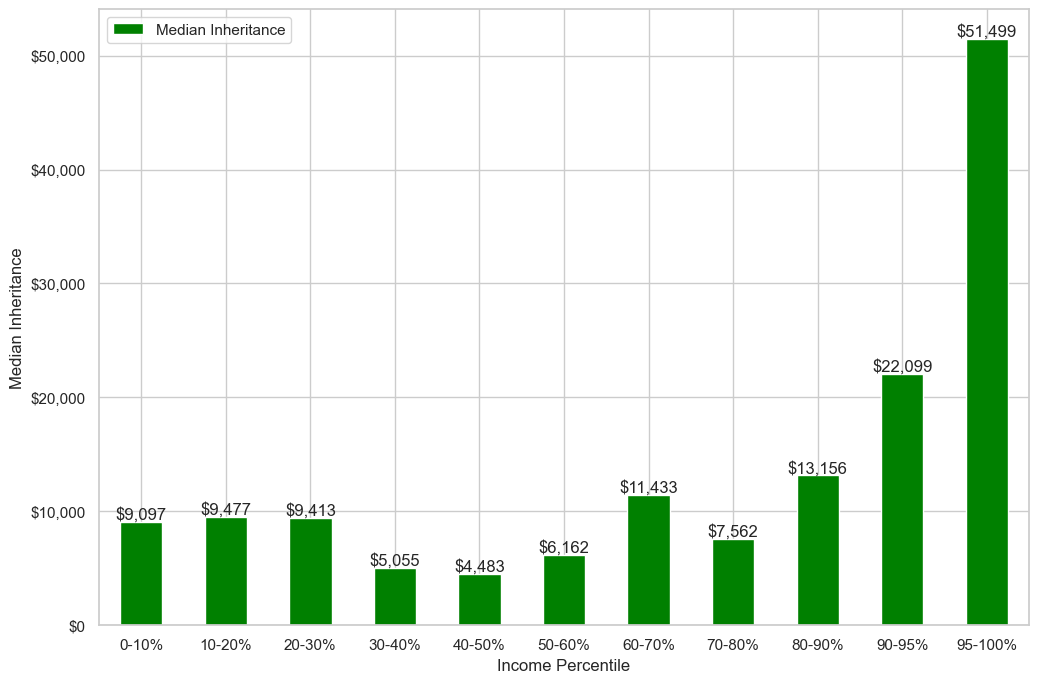

In [434]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
idff.plot(kind='bar', x='Income Percentile', y='Median Inheritance', ax=ax1, color='green', grid=True, zorder=1)
ax1.set_xlabel("Income Percentile")
ax1.set_ylabel(f"Median Inheritance")
ax1.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
ax1.bar_label(ax1.containers[0], label_type='edge',  fmt='${:,.0f}')

plt.xticks(rotation='horizontal')
fig.show()

# FICO

In [472]:
# Retrieved from:
# https://www.fico.com/blogs/average-us-fico-score-718

fico_scores_data = {
    "FICO_Score_Range": ["300-499", "500-549", "550-599", "600-649", "650-699", "700-749", "750-799", "800-850", "Total"],
    "April_2005": [6.8, 8.1, 8.7, 10.0, 13.1, 16.5, 20.4, 16.2, 100.0],
    "April_2006": [6.2, 8.0, 8.9, 10.2, 12.8, 16.5, 20.0, 17.4, 100.0],
    "April_2007": [6.3, 7.9, 8.9, 10.1, 12.5, 16.1, 19.9, 18.2, 100.0],
    "April_2008": [7.2, 8.2, 8.7, 9.6, 12.0, 16.0, 19.6, 18.7, 100.0],
    "April_2009": [7.3, 8.7, 9.1, 9.5, 12.0, 15.9, 19.3, 18.2, 100.0],
    "April_2010": [6.9, 9.0, 9.6, 9.5, 11.9, 15.7, 19.5, 17.9, 100.0],
    "April_2011": [6.3, 8.7, 9.9, 9.8, 12.1, 15.6, 19.6, 18.1, 100.0],
    "April_2012": [5.7, 8.4, 9.4, 10.1, 12.2, 16.3, 18.9, 18.5, 100.0],
    "April_2013": [5.6, 8.1, 9.6, 10.2, 12.8, 16.4, 18.2, 19.3, 100.0],
    "April_2014": [5.4, 7.6, 9.4, 10.3, 13.0, 16.6, 18.5, 19.9, 100.0],
    "April_2015": [4.9, 7.6, 9.4, 10.3, 13.3, 16.9, 18.5, 20.4, 100.0],
    "April_2016": [4.6, 7.1, 9.0, 10.0, 13.2, 17.1, 19.0, 20.7, 100.0],
    "April_2017": [4.7, 6.8, 8.5, 9.6, 13.2, 16.2, 20.2, 21.8, 100.0],
    "April_2018": [4.2, 6.8, 8.1, 9.6, 13.0, 16.2, 20.7, 22.3, 100.0],
    "April_2019": [4.3, 6.8, 7.8, 9.3, 12.5, 16.1, 20.7, 22.3, 100.0],
    "April_2020": [4.2, 6.8, 7.7, 9.1, 12.2, 16.1, 20.7, 23.0, 100.0],
    "April_2021": [3.0, 5.4, 7.1, 9.2, 12.4, 16.4, 23.1, 23.3, 100.0],
    "April_2022": [2.9, 5.5, 6.8, 9.1, 12.4, 16.4, 23.6, 23.3, 100.0],
    "April_2023": [2.8, 5.7, 6.8, 9.1, 12.4, 16.4, 23.6, 24.1, 100.0]
}

# Convert the dictionary into a Pandas DataFrame
fico_df = pd.DataFrame(fico_scores_data)

array(['300-499', '500-549', '550-599', '600-649', '650-699', '700-749',
       '750-799', '800-850'], dtype=object)

In [501]:
fico_df.head()

FICO_Score_Range  April_2005  April_2006  April_2007  April_2008  \
0          300-499         6.8         6.2         6.3         7.2   
1          500-549         8.1         8.0         7.9         8.2   
2          550-599         8.7         8.9         8.9         8.7   
3          600-649        10.0        10.2        10.1         9.6   
4          650-699        13.1        12.8        12.5        12.0   

   April_2009  April_2010  April_2011  April_2012  April_2013  April_2014  \
0         7.3         6.9         6.3         5.7         5.6         5.4   
1         8.7         9.0         8.7         8.4         8.1         7.6   
2         9.1         9.6         9.9         9.4         9.6         9.4   
3         9.5         9.5         9.8        10.1        10.2        10.3   
4        12.0        11.9        12.1        12.2        12.8        13.0   

   April_2015  April_2016  April_2017  April_2018  April_2019  April_2020  \
0         4.9         4.6         4.7         4.2         4.3         4.2   
1         7.6         7.1         6.8         6.8         6.8         6.8   
2         9.4         9.0         8.5         8.1         7.8         7.7   
3        10.3        10.0         9.6         9.6         9.3         9.1   
4        13.3        13.2        13.2        13.0        12.5        12.2   

   April_2021  April_2022  April_2023  
0         3.0         2.9         2.8  
1         5.4         5.5         5.7  
2         7.1         6.8         6.8  
3         9.2         9.1         9.1  
4        12.4        12.4        12.4

In [537]:
fdf = pd.DataFrame(fico_df.T.values[1:,:], columns=fico_df['FICO_Score_Range'].values).set_index(fico_df.columns[1:])

In [538]:
# fdf.index = [pd.to_datetime(j.replace("April_", "04-01-")) for j in fdf.index]
# fdf.index = [j.replace("April_", "04-01-") for j in fdf.index]
fdf.index = [int(j.replace("April_", "")) for j in fdf.index]

In [571]:
fdf.head()

300-499 500-549 550-599 600-649 650-699 700-749 750-799 800-850  Total
2005     6.8     8.1     8.7    10.0    13.1    16.5    20.4    16.2  100.0
2006     6.2     8.0     8.9    10.2    12.8    16.5    20.0    17.4  100.0
2007     6.3     7.9     8.9    10.1    12.5    16.1    19.9    18.2  100.0
2008     7.2     8.2     8.7     9.6    12.0    16.0    19.6    18.7  100.0
2009     7.3     8.7     9.1     9.5    12.0    15.9    19.3    18.2  100.0

In [563]:
fdf.tail()

300-499 500-549 550-599 600-649 650-699 700-749 750-799 800-850  Total
2019     4.3     6.8     7.8     9.3    12.5    16.1    20.7    22.3  100.0
2020     4.2     6.8     7.7     9.1    12.2    16.1    20.7    23.0  100.0
2021     3.0     5.4     7.1     9.2    12.4    16.4    23.1    23.3  100.0
2022     2.9     5.5     6.8     9.1    12.4    16.4    23.6    23.3  100.0
2023     2.8     5.7     6.8     9.1    12.4    16.4    23.6    24.1  100.0

In [598]:
fdf.tail(1)[fdf.columns[0:-1]].sum()

300-499     2.8
500-549     5.7
550-599     6.8
600-649     9.1
650-699    12.4
700-749    16.4
750-799    23.6
800-850    24.1
dtype: object

In [569]:
fdf.tail(1)[fdf.columns[0:-3]]

300-499 500-549 550-599 600-649 650-699 700-749
2023     2.8     5.7     6.8     9.1    12.4    16.4

In [599]:
fdf.tail(1)[fdf.columns[0:-3]].sum().sum() + 19

72.19999999999999

In [583]:
from matplotlib.ticker import FormatStrFormatter

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_5846/3817410186.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([f'{x:.0f}%' for x in ax1.get_yticks()])
/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_5846/3817410186.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


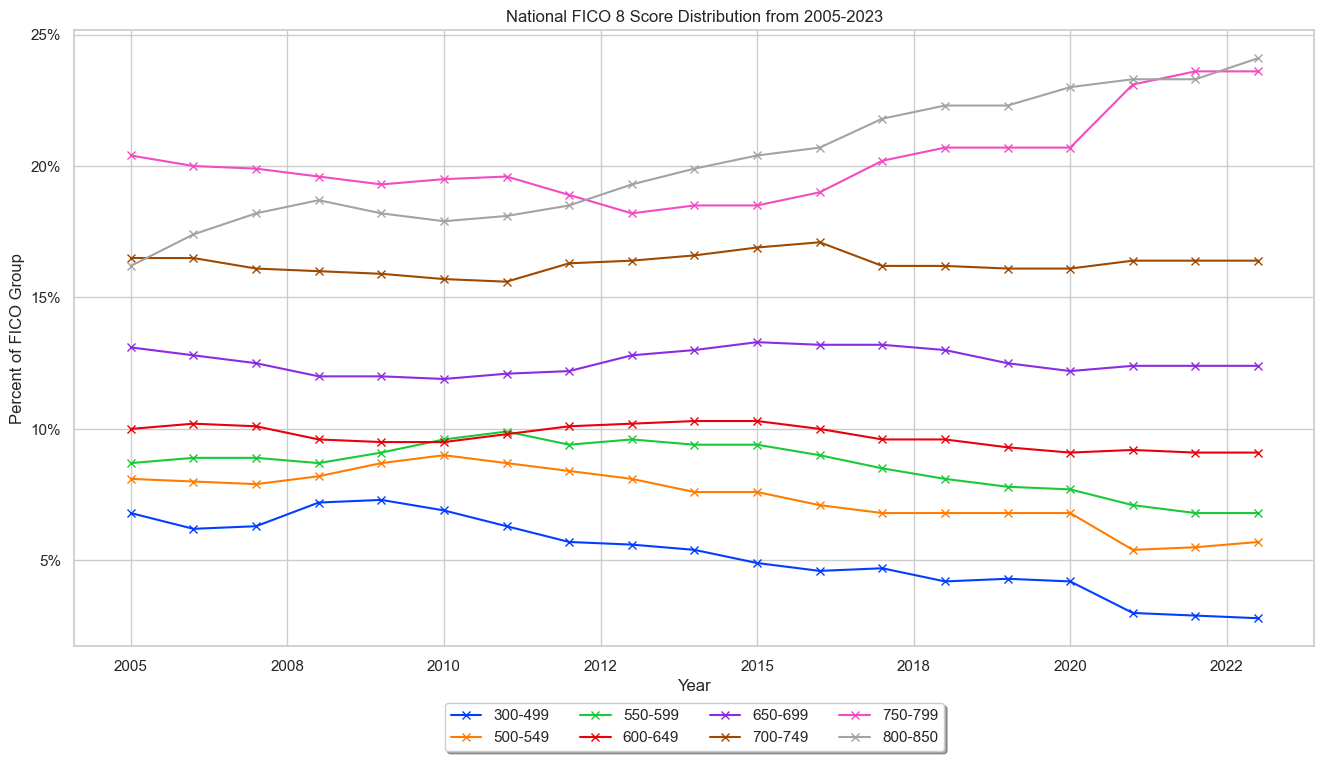

In [591]:
sns.set_palette("bright")
fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))
fdf.reset_index().drop('Total', axis=1).plot(x='index', kind='line', marker='x', ax=ax1, grid=True, title='National FICO 8 Score Distribution from 2005-2023')
ax1.set_xlabel("Year")
ax1.set_ylabel("Percent of FICO Group")
ax1.set_yticklabels([f'{x:.0f}%' for x in ax1.get_yticks()]) 
ax1.get_xaxis().set_major_formatter(FormatStrFormatter('%.0f')) 
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places


# ax1.set_xticklabels([j for j in fdf.index])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=4)

fig.show()